### Full DnW Conversion ###

Converting both temperature to demand and wind speed to wind power generation, then taking the difference to calculate demand net wind. All in the same notebook.

Wind speed -> Wind power generation conversion first

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import (
    plot_distributions_fidelity,
    plot_cdfs,
    plot_qq,
    plot_rp_extremes,
    estimate_period,
    sigmoid,
    apply_detrend_rolling,
)

In [3]:
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Load the model data
df_model_sfcWind = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv"
)

# set up the df obs sfcwing
df_obs_sfcWind_uk = pd.read_csv(
    "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_United_Kingdom_1960-2018_daily_2024-12-11.csv"
)

# set up the obs for the north sea region
df_obs_sfcWind_ns = pd.read_csv("/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_North_Sea_1960-2018_daily_2025-01-20.csv"
)

# Set up the canari model data for the north sea region
# df_canari_north_sea = pd.read_csv(
#     "/home/users/benhutch/unseen_multi_year/dfs/canari_sfcWind_North_Sea_1950-2014_hourly.csv"
# )

# Set up the canari model data for the UK region
df_canari_uk = pd.read_csv(
    "/home/users/benhutch/unseen_multi_year/dfs/canari_sfcWind_United_Kingdom_1950-2014_hourly.csv"
)

# load the clearheads data for wind generation
df_ch = pd.read_csv(
    "/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv"
)

In [4]:
# df_canari_north_sea.tail()
df_canari_uk.head()

member                 time  sfcWind_u  sfcWind_v
0       1  1950-01-01 01:00:00   2.353034   0.759652
1       1  1950-01-01 02:00:00   2.543308   0.659802
2       1  1950-01-01 03:00:00   2.679843   0.530104
3       1  1950-01-01 04:00:00   2.759284   0.369268
4       1  1950-01-01 05:00:00   2.780005   0.201016

In [5]:
# create a new column for sfcWind in the df_canari_north_sea
# df_canari_north_sea["sfcWind"] = np.sqrt(
#     df_canari_north_sea["sfcWind_u"] ** 2 + df_canari_north_sea["sfcWind_v"] ** 2
# )

# create a new column for sfcWind in the df_canari_uk
df_canari_uk["sfcWind"] = np.sqrt(
    df_canari_uk["sfcWind_u"] ** 2 + df_canari_uk["sfcWind_v"] ** 2
)

In [6]:
# # process the canari data into daily means
# (df_canari_north_sea["time"].values[0].split(" ")[0])

# add a new column for the date
# df_canari_north_sea["date"] = df_canari_north_sea["time"].apply(
#     lambda x: x.split(" ")[0]
# )

# add a new column for the date
df_canari_uk["date"] = df_canari_uk["time"].apply(
    lambda x: x.split(" ")[0]
)

In [7]:
df_canari_uk.head()

member                 time  sfcWind_u  sfcWind_v   sfcWind        date
0       1  1950-01-01 01:00:00   2.353034   0.759652  2.472619  1950-01-01
1       1  1950-01-01 02:00:00   2.543308   0.659802  2.627500  1950-01-01
2       1  1950-01-01 03:00:00   2.679843   0.530104  2.731770  1950-01-01
3       1  1950-01-01 04:00:00   2.759284   0.369268  2.783884  1950-01-01
4       1  1950-01-01 05:00:00   2.780005   0.201016  2.787263  1950-01-01

In [8]:
# aggregate the data to daily means
# df_canari_north_sea_daily = df_canari_north_sea.groupby("date").mean()

# make sure that member is formatted as a string
# df_canari_north_sea["member"] = df_canari_north_sea["member"].apply(
#     lambda x: str(x).zfill(2)
# )

# # Select only the numeric columns for aggregation
# numeric_columns = df_canari_north_sea.select_dtypes(include='number').columns

# # Aggregate the data to daily means for numeric columns, grouped by both date and member
# df_canari_north_sea_daily = df_canari_north_sea.groupby(["date", "member"])[numeric_columns].mean().reset_index()

# make sure the member is formatted as a string
df_canari_uk["member"] = df_canari_uk["member"].apply(
    lambda x: str(x).zfill(2)
)

# Select only the numeric columns for aggregation
numeric_columns = df_canari_uk.select_dtypes(include='number').columns

# Aggregate the data to daily means for numeric columns, grouped by both date and member
df_canari_uk_daily = df_canari_uk.groupby(["date", "member"])[numeric_columns].mean().reset_index()

# # If you want to keep the non-numeric columns, you can merge them back
# non_numeric_columns = df_canari_north_sea.select_dtypes(exclude='number').columns.difference(['date'])
# df_canari_north_sea_daily = df_canari_north_sea_daily.merge(df_canari_north_sea[non_numeric_columns].drop_duplicates(), on='date', how='left')

In [9]:
df_canari_uk_daily.head()

date member  sfcWind_u  sfcWind_v   sfcWind
0  1950-01-01     01   2.543828   0.414145  2.584878
1  1950-01-01     02   2.575286   0.402162  2.613892
2  1950-01-01     03   2.675272   0.368291  2.706784
3  1950-01-01     04   2.609812   0.385986  2.646321
4  1950-01-01     05   2.712348   0.424189  2.750092

In [10]:
# subset for ONDJFM
# df_canari_north_sea_daily_ondjfm = df_canari_north_sea_daily[
#     df_canari_north_sea_daily["date"].str.split("-").str[1].isin(["10", "11", "12", "01", "02", "03"])
# ]

# subset for ONDJFM
df_canari_uk_daily_ondjfm = df_canari_uk_daily[
    df_canari_uk_daily["date"].str.split("-").str[1].isin(["10", "11", "12", "01", "02", "03"])
]

# subset for DJF
df_canari_uk_daily_djf = df_canari_uk_daily[
    df_canari_uk_daily["date"].str.split("-").str[1].isin(["12", "01", "02"])
]

In [11]:
df_canari_uk_daily_ondjfm.head()

date member  sfcWind_u  sfcWind_v   sfcWind
0  1950-01-01     01   2.543828   0.414145  2.584878
1  1950-01-01     02   2.575286   0.402162  2.613892
2  1950-01-01     03   2.675272   0.368291  2.706784
3  1950-01-01     04   2.609812   0.385986  2.646321
4  1950-01-01     05   2.712348   0.424189  2.750092

In [12]:
# format member back as an int
# df_canari_north_sea_daily["member"] = df_canari_north_sea_daily["member"].apply(
#     lambda x: int(x)
# )

# format member back as an int
df_canari_uk_daily_ondjfm["member"] = df_canari_uk_daily_ondjfm["member"].apply(
    lambda x: int(x)
)

# do the same for the DJF subset
df_canari_uk_daily_djf["member"] = df_canari_uk_daily_djf["member"].apply(
    lambda x: int(x)
)

In [13]:
# # Set up a new df
# north_sea_df = pd.DataFrame()

# # /gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_North_Sea_1981_9_day.csv

# # loop over the years
# for year in tqdm(np.arange(1960, 2018 + 1)):
#     for member in np.arange(1, 11):
#         # Load the data
#         df_this = pd.read_csv(
#             f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_North_Sea_{year}_{member}_day.csv"
#         )

#         # Append to the new df
#         north_sea_df = pd.concat([north_sea_df, df_this])

In [14]:
# Clean the obs data
df_obs_sfcWind_uk["time"] = pd.to_datetime(
    df_obs_sfcWind_uk["time"], origin="1952-01-01", unit="D"
)

# subset the data to O, N, D, J, F, M
df_obs_sfcWind_uk = df_obs_sfcWind_uk[
    df_obs_sfcWind_uk["time"].dt.month.isin([10, 11, 12, 1, 2, 3])
]

# subset the data to DJF
df_obs_sfcWind_uk_djf = df_obs_sfcWind_uk[
    df_obs_sfcWind_uk["time"].dt.month.isin([12, 1, 2])
]

# same for the north sea
df_obs_sfcWind_ns["time"] = pd.to_datetime(
    df_obs_sfcWind_ns["time"], origin="1952-01-01", unit="D"
)

# Subset the data to D,J,F
df_obs_sfcWind_ns_djf = df_obs_sfcWind_ns[
    df_obs_sfcWind_ns["time"].dt.month.isin([12, 1, 2])
]

# subset the data to O, N, D, J, F, M
df_obs_sfcWind_ns = df_obs_sfcWind_ns[
    df_obs_sfcWind_ns["time"].dt.month.isin([10, 11, 12, 1, 2, 3])
]

In [15]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
import functions as funcs

In [16]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_uk_ondjfm = pd.DataFrame()
df_model_ondjfm_uk_djf = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads_ondjfm to extract
    leads_ondjfm = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # set up the leads_djf to extract
    leads_djf = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    # Extract the data
    df_model_leads_this_ondjfm = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads_ondjfm)]

    # extract the data for djf
    df_model_leads_this_djf = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads_djf)]

    # include a new column
    df_model_leads_this_ondjfm["winter_year"] = wyear

    # include a new column for the djf data
    df_model_leads_this_djf["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_uk_ondjfm = pd.concat([df_model_ondjfm_uk_ondjfm, df_model_leads_this_ondjfm])

    # Append to the new df
    df_model_ondjfm_uk_djf = pd.concat([df_model_ondjfm_uk_djf, df_model_leads_this_djf])

# set up a new df to append to
df_model_ondjfm_ns = pd.DataFrame()

# # Loop over the winter years
# for i, wyear in enumerate(winter_years):
#     # Set up the leads_ondjfm to extract
#     leads_ondjfm = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

#     # Extract the data
#     df_model_leads_this_ondjfm = north_sea_df[north_sea_df["lead"].isin(leads_ondjfm)]

#     # include a new column
#     df_model_leads_this_ondjfm["winter_year"] = wyear

#     # Append to the new df
#     df_model_ondjfm_ns = pd.concat([df_model_ondjfm_ns, df_model_leads_this_ondjfm])

Compare distributions and fidelity, UK vs North Sea sfcWind.

Compare the distribution of DJF DePreSys wind speed against that of the observations.

Compare the distribution of ONDJFM DePreSys against that of the observations

And compare the distribution of ONDJFM Canari against that of the observations

In [17]:
import functions as funcs

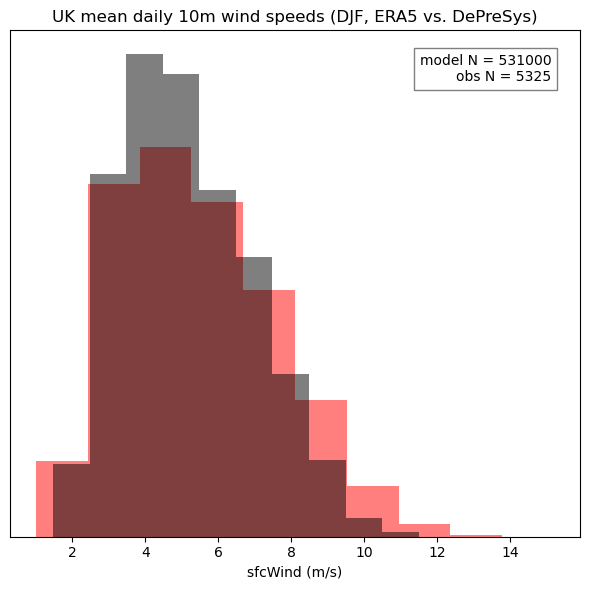

In [18]:
funcs.plot_distribution(
    obs_df=df_obs_sfcWind_uk_djf,
    model_df=df_model_ondjfm_uk_djf,
    xlabel="sfcWind (m/s)",
    nbins=30,
    title="UK mean daily 10m wind speeds (DJF, ERA5 vs. DePreSys)",
    obs_val_name="data",
    model_val_name="data",
    fname_prefix="UK_sfcWind_ERA5_vs_DePreSys",
)

In [19]:
df_canari_uk_daily_djf.head()

date  member  sfcWind_u  sfcWind_v   sfcWind
0  1950-01-01       1   2.543828   0.414145  2.584878
1  1950-01-01       2   2.575286   0.402162  2.613892
2  1950-01-01       3   2.675272   0.368291  2.706784
3  1950-01-01       4   2.609812   0.385986  2.646321
4  1950-01-01       5   2.712348   0.424189  2.750092

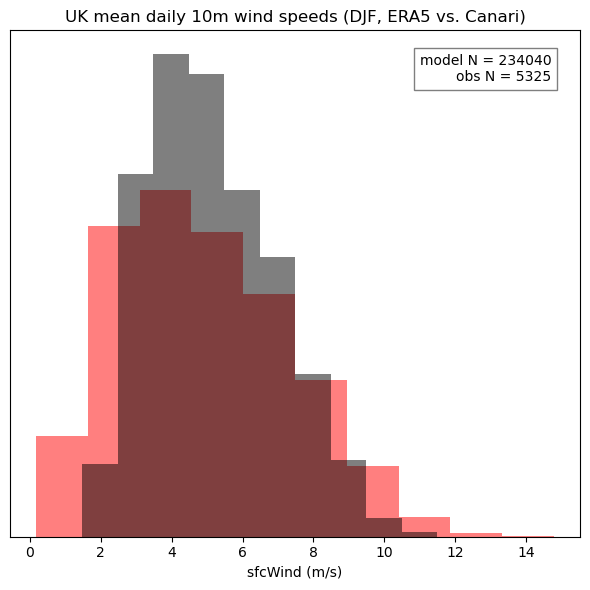

In [20]:
# now the same but for canari
funcs.plot_distribution(
    obs_df=df_obs_sfcWind_uk_djf,
    model_df=df_canari_uk_daily_djf,
    xlabel="sfcWind (m/s)",
    nbins=30,
    title="UK mean daily 10m wind speeds (DJF, ERA5 vs. Canari)",
    obs_val_name="data",
    model_val_name="sfcWind",
    fname_prefix="UK_sfcWind_ERA5_vs_Canari",
)

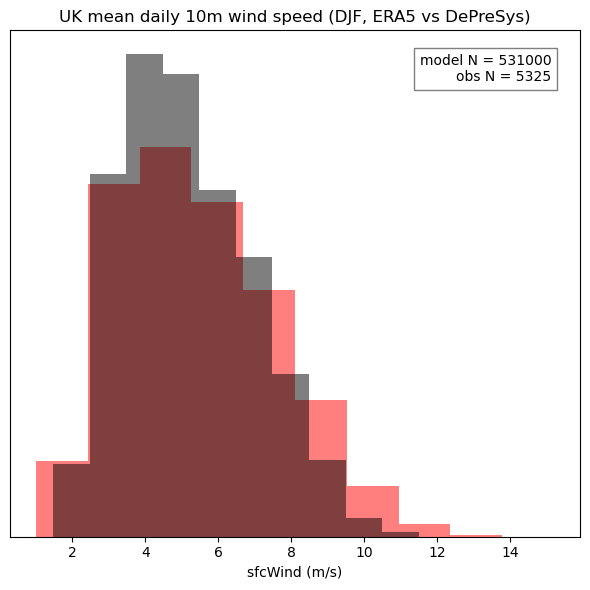

In [21]:
# plot the distribution of DePreSys north sea sfcWind against the obs
funcs.plot_distribution(
    obs_df=df_obs_sfcWind_uk_djf,
    model_df=df_model_ondjfm_uk_djf,
    xlabel="sfcWind (m/s)",
    nbins=30,
    title="UK mean daily 10m wind speed (DJF, ERA5 vs DePreSys)",
    obs_val_name="data",
    model_val_name="data",
    fname_prefix="djf_uk_sfcWind",
)

In [22]:
# # plot the distribution of DePreSys north sea sfcWind against the obs
# funcs.plot_distribution(
#     obs_df=df_obs_sfcWind_ns,
#     model_df=df_model_ondjfm_ns,
#     xlabel="sfcWind (m/s)",
#     nbins=30,
#     title="North Sea daily 10m wind speed (ERA5 vs DePreSys)",
#     obs_val_name="data",
#     model_val_name="data",
#     fname_prefix="ns_sfcWind",
# )

In [23]:
df_obs_sfcWind_ns["time"].dt.year.unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018], dtype=int32)

In [24]:
# # restrict canari to 1960 to 2018
# df_canari_north_sea_daily_ondjfm = df_canari_north_sea_daily_ondjfm[
#     df_canari_north_sea_daily_ondjfm["date"].str.split("-").str[0].astype(int).between(1960, 2018)
# ]

In [25]:
# # plot the distribution of DePreSys north sea sfcWind against the obs
# funcs.plot_distribution(
#     obs_df=df_obs_sfcWind_ns,
#     model_df=df_canari_north_sea_daily_ondjfm,
#     xlabel="sfcWind (m/s)",
#     nbins=30,
#     title="North Sea daily 10m wind speed (ERA5 vs Canari)",
#     obs_val_name="data",
#     model_val_name="sfcWind",
#     fname_prefix="ns_sfcWind",
# )

In [26]:
# # set up a figure with size 6x6
# fig, ax = plt.subplots(figsize=(6, 6))

# # plot a histogram of the model depresys data for the north sea
# ax.hist(
#     df_model_ondjfm_ns["data"],
#     alpha=0.5,
#     color="red",
#     label="DePreSys",
#     density=True,
# )

# # plot a histogram of the canari data for the north sea in blue
# ax.hist(
#     df_canari_north_sea_daily_ondjfm["sfcWind"],
#     alpha=0.5,
#     color="blue",
#     label="Canari",
#     density=True,
# )

# # include a texbox with the sample size
# ax.text(
#     0.95,
#     0.90,
#     f"DePreSys: {len(df_model_ondjfm_ns)}\nCanari: {len(df_canari_north_sea_daily_ondjfm)}",
#     transform=plt.gca().transAxes,
#     bbox=dict(facecolor="white", alpha=0.5),
#     horizontalalignment="right",
# )

# # remove the ticks for the y axis
# plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

# # remove the numbers from the y axis
# plt.yticks([])

# # Add a title
# # TODO: hard coded title
# plt.title("North Sea daily 10m wind speed (DePreSys vs Canari)")

# # set the x-axis label
# plt.xlabel("sfcWind (m/s)")

# # add a legend
# plt.legend()

# # show the plot
# plt.show()



In [27]:
# determine the effective dec year for canari data
# Define the custom function to determine the effective_dec_year
def determine_effective_dec_year(row):
    year = int(row["date"].split("-")[0])
    month = row["date"].split("-")[1]
    if month in ["01", "02", "03"]:
        return year - 1
    elif month in ["10", "11", "12"]:
        return year
    else:
        return None  # or some default value if needed
    
# Apply the custom function to the canari data
# df_canari_north_sea_daily_ondjfm["effective_dec_year"] = df_canari_north_sea_daily_ondjfm.apply(
#     determine_effective_dec_year, axis=1
# )
    
# Apply the custom function to the canari data
df_canari_uk_daily_ondjfm["effective_dec_year"] = df_canari_uk_daily_ondjfm.apply(
    determine_effective_dec_year, axis=1
)

# same for the djf data
df_canari_uk_daily_djf["effective_dec_year"] = df_canari_uk_daily_djf.apply(
    determine_effective_dec_year, axis=1
)

In [28]:
# df_canari_north_sea_daily_ondjfm.head()

df_canari_uk_daily_djf.tail()

date  member  sfcWind_u  sfcWind_v   sfcWind  effective_dec_year
936035  2015-01-01      36   2.832385   8.816010  9.259829                2014
936036  2015-01-01      37  -0.551418   1.649626  1.739347                2014
936037  2015-01-01      38   0.345165  -0.780019  0.852976                2014
936038  2015-01-01      39  -1.151551  -0.167884  1.163725                2014
936039  2015-01-01      40   2.039303  -6.159293  6.488116                2014

In [29]:
# # remove the rows for effective dec year 1959 and 2014 (both incomplete)
# df_canari_north_sea_daily_ondjfm = df_canari_north_sea_daily_ondjfm[
#     df_canari_north_sea_daily_ondjfm["effective_dec_year"].between(1960, 2013)
# ]

# remove the rows for effective dec year 1959 and 2014 (both incomplete)
df_canari_uk_daily_ondjfm = df_canari_uk_daily_ondjfm[
    df_canari_uk_daily_ondjfm["effective_dec_year"].between(1960, 2013)
]

# remove the rows for effective dec year 1959 and 2014 (both incomplete)
df_canari_uk_daily_djf = df_canari_uk_daily_djf[
    df_canari_uk_daily_djf["effective_dec_year"].between(1960, 2013)
]

In [30]:
df_model_ondjfm_uk_djf.head()

init_year  member  lead      data  winter_year
30       1960       1    31  5.412472            1
31       1960       1    32  7.334262            1
32       1960       1    33  9.739779            1
33       1960       1    34  8.534937            1
34       1960       1    35  5.980195            1

In [31]:
# calculate effective dec year for both model onfjfm dataframe
df_model_ondjfm_uk_ondjfm["effective_dec_year"] = df_model_ondjfm_uk_ondjfm["init_year"] + df_model_ondjfm_uk_ondjfm["winter_year"]
df_model_ondjfm_uk_djf["effective_dec_year"] = df_model_ondjfm_uk_djf["init_year"] + (df_model_ondjfm_uk_djf["winter_year"] - 1)

In [32]:
df_model_ondjfm_uk_djf.tail()

init_year  member  lead      data  winter_year  effective_dec_year
2212115       2018      10  3356  3.889863           10                2027
2212116       2018      10  3357  2.128456           10                2027
2212117       2018      10  3358  5.327908           10                2027
2212118       2018      10  3359  5.538287           10                2027
2212119       2018      10  3360  5.109356           10                2027

In [33]:
# # do the same for the north sea
# df_model_ondjfm_ns["effective_dec_year"] = df_model_ondjfm_ns["init_year"] + df_model_ondjfm_ns["winter_year"]

In [34]:
import importlib
sys.path.append("/home/users/benhutch/unseen_functions")
import functions as func

In [35]:
# create a new column for the effective_dec_year in df_obs_tas
# write a function to determine the effective_dec_year
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None

In [36]:
df_obs_sfcWind_uk_djf.head()

time      data
0 1960-01-01  5.291350
1 1960-01-02  2.538070
2 1960-01-03  3.692958
3 1960-01-04  4.943725
4 1960-01-05  5.288300

In [37]:
# apply this function to the df_obs_sfcWind_uk
# first ensure the time column is in datetime format
# df_obs_sfcWind_uk["time"] = pd.to_datetime(df_obs_sfcWind_uk["time"])
# df_obs_sfcWind_uk_djf["time"] = pd.to_datetime(df_obs_sfcWind_uk_djf["time"])
df_obs_sfcWind_uk["time"] = pd.to_datetime(df_obs_sfcWind_uk["time"])

# apply the function
df_obs_sfcWind_uk["effective_dec_year"] = df_obs_sfcWind_uk.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

# apply the function to the north sea region
# df_obs_sfcWind_ns["effective_dec_year"] = df_obs_sfcWind_ns.apply(
#     lambda row: determine_effective_dec_year(row), axis=1
# )

# make sure that time is a datetime
df_obs_sfcWind_uk_djf["time"] = pd.to_datetime(df_obs_sfcWind_uk_djf["time"])

# apply the function to the djf data
df_obs_sfcWind_uk_djf["effective_dec_year"] = df_obs_sfcWind_uk_djf.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

In [38]:
df_obs_sfcWind_uk_djf.head()

time      data  effective_dec_year
0 1960-01-01  5.291350                1959
1 1960-01-02  2.538070                1959
2 1960-01-03  3.692958                1959
3 1960-01-04  4.943725                1959
4 1960-01-05  5.288300                1959

In [39]:
# remove first and last effective dec year
# df_obs_sfcWind_uk = df_obs_sfcWind_uk[
#     (df_obs_sfcWind_uk["effective_dec_year"] > 1960)
#     & (df_obs_sfcWind_uk["effective_dec_year"] < 2018)
# # ]

# remove first and last effective dec year
# df_obs_sfcWind_uk = df_obs_sfcWind_uk[
#     (df_obs_sfcWind_uk["effective_dec_year"] > 1960)
#     & (df_obs_sfcWind_uk["effective_dec_year"] < 2018)
# ]

# same for the djf data
df_obs_sfcWind_uk_djf = df_obs_sfcWind_uk_djf[
    (df_obs_sfcWind_uk_djf["effective_dec_year"] > 1960)
    & (df_obs_sfcWind_uk_djf["effective_dec_year"] < 2018)
]

In [40]:
# limit the dataframes to winter_year 1
# df_model_ondjfm_uk_first = df_model_ondjfm_uk[df_model_ondjfm_uk["winter_year"] == 1]
# df_model_ondjfm_ns_first = df_model_ondjfm_ns[df_model_ondjfm_ns["winter_year"] == 1]

# limit the dataframes to winter_year 1
df_model_ondjfm_uk_djf_first = df_model_ondjfm_uk_djf[df_model_ondjfm_uk_djf["winter_year"] == 1]
df_model_ondjfm_uk_djf_second = df_model_ondjfm_uk_djf[df_model_ondjfm_uk_djf["winter_year"] == 2]

# limit the dataframes to winter_year 1
# df_model_ondjfm_uk_ondjfm_first = df_model_ondjfm_uk_ondjfm[df_model_ondjfm_uk_ondjfm["winter_year"] == 1]
# df_model_ondjfm_uk_ondjfm_second = df_model_ondjfm_uk_ondjfm[df_model_ondjfm_uk_ondjfm["winter_year"] == 2]

In [41]:
df_model_ondjfm_uk_djf_second.head()

init_year  member  lead      data  winter_year  effective_dec_year
390       1960       1   391  3.876318            2                1961
391       1960       1   392  3.895657            2                1961
392       1960       1   393  3.473139            2                1961
393       1960       1   394  3.531538            2                1961
394       1960       1   395  2.667478            2                1961

In [42]:
import importlib
sys.path.append("/home/users/benhutch/unseen_functions")
import functions as func

In [43]:
importlib.reload(func)

<module 'functions' from '/home/users/benhutch/unseen_functions/functions.py'>

In [44]:
print(np.unique(df_model_ondjfm_uk_djf["effective_dec_year"]))

[1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020 2021 2022 2023 2024 2025 2026 2027]


In [45]:
print(df_obs_sfcWind_uk_djf["effective_dec_year"].unique())

[1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]


In [46]:
# limit the df_model_ondjfm_uk_djf_first to the same effective dec years as the obs
# df_model_ondjfm_uk_djf_first_subset = df_model_ondjfm_uk_djf_first[
#     df_model_ondjfm_uk_djf_first["effective_dec_year"].isin(df_obs_sfcWind_uk_djf["effective_dec_year"].unique())
# ]

# limit the df_model_ondjfm_uk_ondjfm_first to the same effective dec years as the obs
# df_model_ondjfm_uk_ondjfm_first_subset = df_model_ondjfm_uk_ondjfm_first[
#     df_model_ondjfm_uk_ondjfm_first["effective_dec_year"].isin(df_obs_sfcWind_uk["effective_dec_year"].unique())
# ]

# # same for the second year
# df_model_ondjfm_uk_ondjfm_second_subset = df_model_ondjfm_uk_ondjfm_second[
#     df_model_ondjfm_uk_ondjfm_second["effective_dec_year"].isin(df_obs_sfcWind_uk["effective_dec_year"].unique())
# ]

# same for the djf data
df_model_ondjfm_uk_djf_second_subset = df_model_ondjfm_uk_djf_second[
    df_model_ondjfm_uk_djf_second["effective_dec_year"].isin(df_obs_sfcWind_uk_djf["effective_dec_year"].unique())
]

df_model_ondjfm_djf_first_subset = df_model_ondjfm_uk_djf_first[
    df_model_ondjfm_uk_djf_first["effective_dec_year"].isin(df_obs_sfcWind_uk_djf["effective_dec_year"].unique())
]

In [47]:
# # process df_model_ondfjfm_uk_djf_first_subset
# # into winter means
# # by grouping by effective_dec_year
# df_model_tas_djf_first_wyear = df_model_ondjfm_uk_djf_first_subset.groupby(
#     [
#         "effective_dec_year",
#         "member",
#         "init_year",
#     ]
# ).mean().reset_index()

In [48]:
# df_model_tas_djf_first_wyear.head()

In [49]:
# df_obs_sfcWind_uk_djf.head()

In [50]:
# # set time as the index for the obs
# # first make sure that time is datetime
# df_obs_sfcWind_uk_djf["time"] = pd.to_datetime(df_obs_sfcWind_uk_djf["time"])

# # set time as the index
# df_obs_sfcWind_uk_djf.set_index("time", inplace=True)

In [51]:
# # process the obs to de djf means
# df_obs_sfcWind_uk_djf_wyear = df_obs_sfcWind_uk_djf.shift(
#     periods=-2,
#     freq=pd.DateOffset(months=2)
# ).resample("A").mean()

In [52]:
# df_obs_sfcWind_uk_djf_wyear.head()

In [53]:
df_obs_sfcWind_uk_djf["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [54]:
df_model_ondjfm_djf_first_subset["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [55]:
df_obs_sfcWind_uk_djf.head()

time      data  effective_dec_year
700 1961-12-01  4.513512                1961
701 1961-12-02  5.581043                1961
702 1961-12-03  3.052315                1961
703 1961-12-04  5.685448                1961
704 1961-12-05  8.769668                1961

In [56]:
# Process the observations into a new datfframe
df_obs_lowest_wind_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_obs_sfcWind_uk_djf["effective_dec_year"].unique():
    # subset the data
    df_this = df_obs_sfcWind_uk_djf[
        df_obs_sfcWind_uk_djf["effective_dec_year"] == year
    ]

    # find the lowest wind day
    lowest_wind_day = df_this["data"].idxmin()

    # Create a new dataframe
    df_new = pd.DataFrame(
        {
            "effective_dec_year": [year],
            "time": [lowest_wind_day],
            "data": [df_this.loc[lowest_wind_day, "data"]],
        }
    )

    # Append to the new dataframe
    df_obs_lowest_wind_day_djf = pd.concat([df_obs_lowest_wind_day_djf, df_new])

In [57]:
df_obs_lowest_wind_day_djf.shape

(57, 3)

Now do the same with the model data

In [58]:
df_model_ondjfm_djf_first_subset.head()

init_year  member  lead       data  winter_year  effective_dec_year
37530       1961       1    31   5.175840            1                1961
37531       1961       1    32   8.804393            1                1961
37532       1961       1    33   7.076096            1                1961
37533       1961       1    34   5.052654            1                1961
37534       1961       1    35  10.168852            1                1961

In [59]:
# Process the model data into a new dataframe
df_model_lowest_wind_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_model_ondjfm_djf_first_subset["effective_dec_year"].unique():
    for member in df_model_ondjfm_djf_first_subset["member"].unique():
        # subset the data
        df_this = df_model_ondjfm_djf_first_subset[
            (df_model_ondjfm_djf_first_subset["effective_dec_year"] == year)
            & (df_model_ondjfm_djf_first_subset["member"] == member)
        ]

        # find the lowest wind day
        lowest_wind_day = df_this["data"].idxmin()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "effective_dec_year": [year],
                "member": [member],
                "time": [lowest_wind_day],
                "data": [df_this.loc[lowest_wind_day, "data"]],
            }
        )

        # Append to the new dataframe
        df_model_lowest_wind_day_djf = pd.concat([df_model_lowest_wind_day_djf, df_new])

In [60]:
(df_model_lowest_wind_day_djf["effective_dec_year"].unique())

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

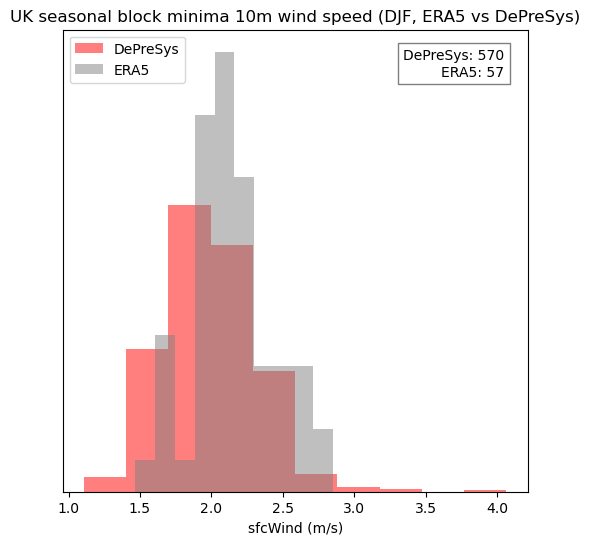

In [61]:
# Set up a figure
# set up a figure with size 6x6
fig, ax = plt.subplots(figsize=(6, 6))

# plot a histogram of the model depresys data for the north sea
ax.hist(
    df_model_lowest_wind_day_djf["data"],
    alpha=0.5,
    color="red",
    label="DePreSys",
    density=True,
)

# plot a histogram of the canari data for the north sea in blue
ax.hist(
    df_obs_lowest_wind_day_djf["data"],
    alpha=0.5,
    color="grey",
    label="ERA5",
    density=True,
)

# include a texbox with the sample size
ax.text(
    0.95,
    0.90,
    f"DePreSys: {len(df_model_lowest_wind_day_djf)}\nERA5: {len(df_obs_lowest_wind_day_djf)}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
)

# remove the ticks for the y axis
plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

# remove the numbers from the y axis
plt.yticks([])

# Add a title
# TODO: hard coded title
plt.title("UK seasonal block minima 10m wind speed (DJF, ERA5 vs DePreSys)")

# set the x-axis label
plt.xlabel("sfcWind (m/s)")

# add a legend
plt.legend()

# show the plot
plt.show()

Text(0.5, 1.0, 'ERA5 UK seasonal block minima 10m wind speed (DJF)')

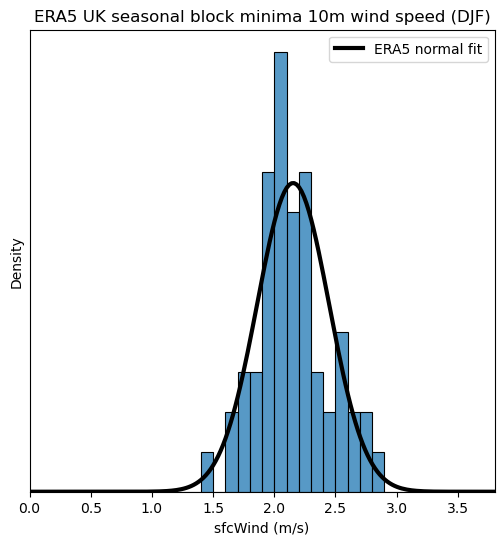

In [62]:
import seaborn as sns
from scipy import stats

# Set up another figure
# set up a figure with size 6x6
fig, ax = plt.subplots(figsize=(6, 6))

# set up x values
x_r100 = np.linspace(0, 20, 1000)

# Set up the bins
bins = np.arange(0, df_obs_lowest_wind_day_djf["data"].max() + 1, 0.1)

# make histogram
sns.histplot(df_obs_lowest_wind_day_djf["data"], bins=bins, stat="density", ax=ax)

# plot PDF
ax.plot(
    x_r100,
    stats.norm.pdf(x_r100, df_obs_lowest_wind_day_djf["data"].mean(), df_obs_lowest_wind_day_djf["data"].std()),
    c="k",
    lw=3,
    label="ERA5 normal fit",
)

ax.set_xlim(bins[0], bins[-1])
ylim = ax.get_ylim()

# include a legend
ax.legend()

# remove the ticks for the y axis
plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

# remove the numbers from the y axis
plt.yticks([])

# set the xlabel
plt.xlabel("sfcWind (m/s)")

# Add a title
plt.title("ERA5 UK seasonal block minima 10m wind speed (DJF)")


((array([-2.2543577 , -1.890737  , -1.6770949 , -1.52048793, -1.39421445,
         -1.28693393, -1.19271302, -1.10803605, -1.03063778, -0.95896738,
         -0.89191286, -0.82864714, -0.76853641, -0.71108263, -0.65588597,
         -0.60261932, -0.55101057, -0.50082983, -0.45188011, -0.40399034,
         -0.35701005, -0.31080516, -0.26525476, -0.22024843, -0.17568408,
         -0.13146609, -0.08750379, -0.04371004,  0.        ,  0.04371004,
          0.08750379,  0.13146609,  0.17568408,  0.22024843,  0.26525476,
          0.31080516,  0.35701005,  0.40399034,  0.45188011,  0.50082983,
          0.55101057,  0.60261932,  0.65588597,  0.71108263,  0.76853641,
          0.82864714,  0.89191286,  0.95896738,  1.03063778,  1.10803605,
          1.19271302,  1.28693393,  1.39421445,  1.52048793,  1.6770949 ,
          1.890737  ,  2.2543577 ]),
  array([1.46830999, 1.62948253, 1.68324888, 1.71058109, 1.71393593,
         1.73053843, 1.86590668, 1.88961699, 1.89821649, 1.91860668,
         1.

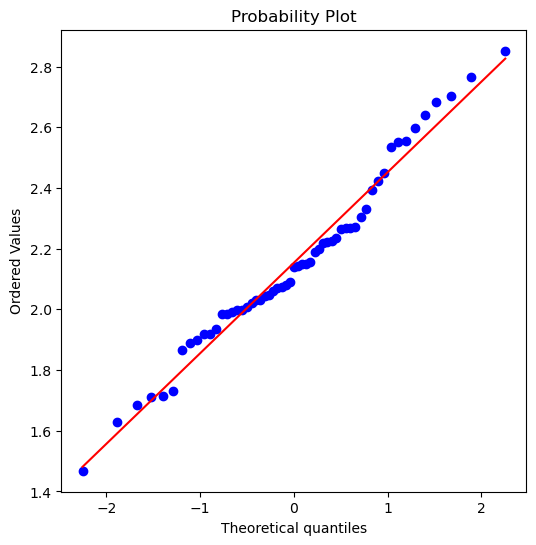

In [63]:
# do a qq plot for the normal distribution
fig, ax = plt.subplots(figsize=(6, 6))

# plot the qq plot
stats.probplot(df_obs_lowest_wind_day_djf["data"], dist="norm", plot=ax)

shape: 0.21644928168060734, loc: 2.0429087519116127, scale: 0.2788473076625245


Text(0.5, 1.0, 'ERA5 UK seasonal block minima 10m wind speed (DJF)')

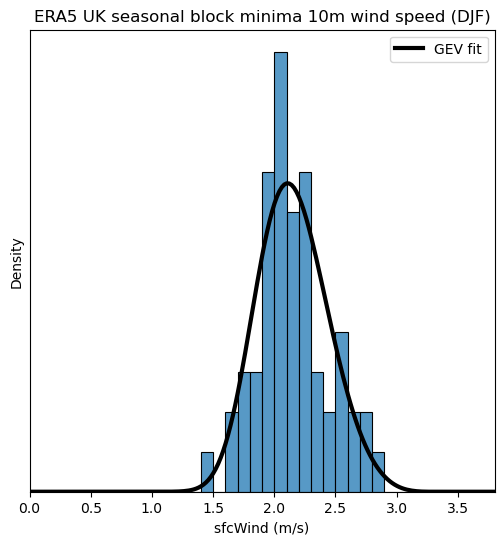

In [64]:
from scipy.stats import genextreme as gev

# Do the same
# Set up another figure
# set up a figure with size 6x6
fig, ax = plt.subplots(figsize=(6, 6))

# set up the histogram
sns.histplot(df_obs_lowest_wind_day_djf["data"], bins=bins, stat="density", ax=ax)

shape, loc, scale = gev.fit(df_obs_lowest_wind_day_djf["data"])

# print the shape, loc and scale
print(f"shape: {shape}, loc: {loc}, scale: {scale}")

# plot the gev fit
ax.plot(
    x_r100,
    gev.pdf(x_r100, shape, loc, scale),
    c="k",
    lw=3,
    label="GEV fit",
)

ax.set_xlim(bins[0], bins[-1])

# include a legend
ax.legend()

# remove the ticks for the y axis
plt.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)

# remove the numbers from the y axis
plt.yticks([])

# set the xlabel
plt.xlabel("sfcWind (m/s)")

# Add a title
plt.title("ERA5 UK seasonal block minima 10m wind speed (DJF)")


((array([1.55447013, 1.63859328, 1.68974207, 1.72808623, 1.75954354,
         1.78665669, 1.81076793, 1.83267849, 1.85290801, 1.8718144 ,
         1.88965575, 1.9066251 , 1.92287122, 1.93851171, 1.95364155,
         1.96833896, 1.98266949, 1.99668896, 2.01044558, 2.02398166,
         2.03733479, 2.05053883, 2.06362473, 2.07662109, 2.08955478,
         2.10245131, 2.11533525, 2.12823061, 2.14116112, 2.15415057,
         2.16722312, 2.18040362, 2.19371793, 2.20719329, 2.22085877,
         2.23474569, 2.24888824, 2.26332409, 2.27809526, 2.2932491 ,
         2.30883962, 2.32492909, 2.34159025, 2.35890913, 2.37698901,
         2.39595578, 2.41596569, 2.43721665, 2.45996541, 2.4845547 ,
         2.51145838, 2.54136132, 2.57531266, 2.61505405, 2.66384222,
         2.72910648, 2.83516882]),
  array([1.46830999, 1.62948253, 1.68324888, 1.71058109, 1.71393593,
         1.73053843, 1.86590668, 1.88961699, 1.89821649, 1.91860668,
         1.92032806, 1.93489777, 1.98358675, 1.98623599, 1.99004654,

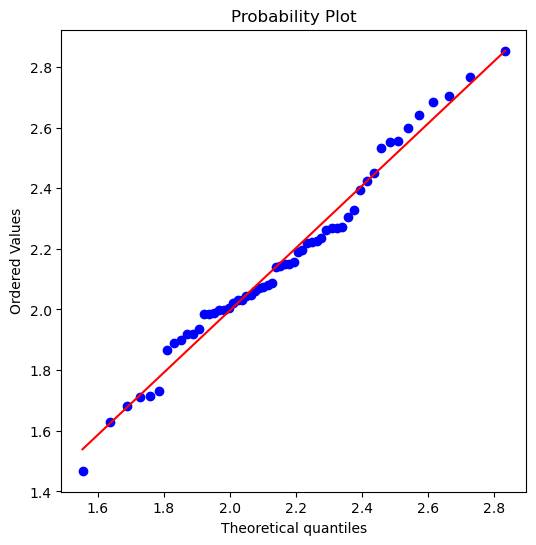

In [65]:
# now plot the quantile-quantile plot
fig, ax = plt.subplots(figsize=(6, 6))

# plot the qq plot
stats.probplot(df_obs_lowest_wind_day_djf["data"], dist=gev, sparams=(shape, loc, scale), plot=ax)

In [66]:
# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 1000

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_ondjfm_djf_first_subset["member"].nunique()

#

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_wind_day_djf["data"].values)
    for y, year in enumerate(df_obs_sfcWind_uk_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_lowest_wind_day_djf[
            df_model_lowest_wind_day_djf["effective_dec_year"] == year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            df_model_this["member"] == random_member
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


In [67]:
len(gev_params["shape"][0])

1000

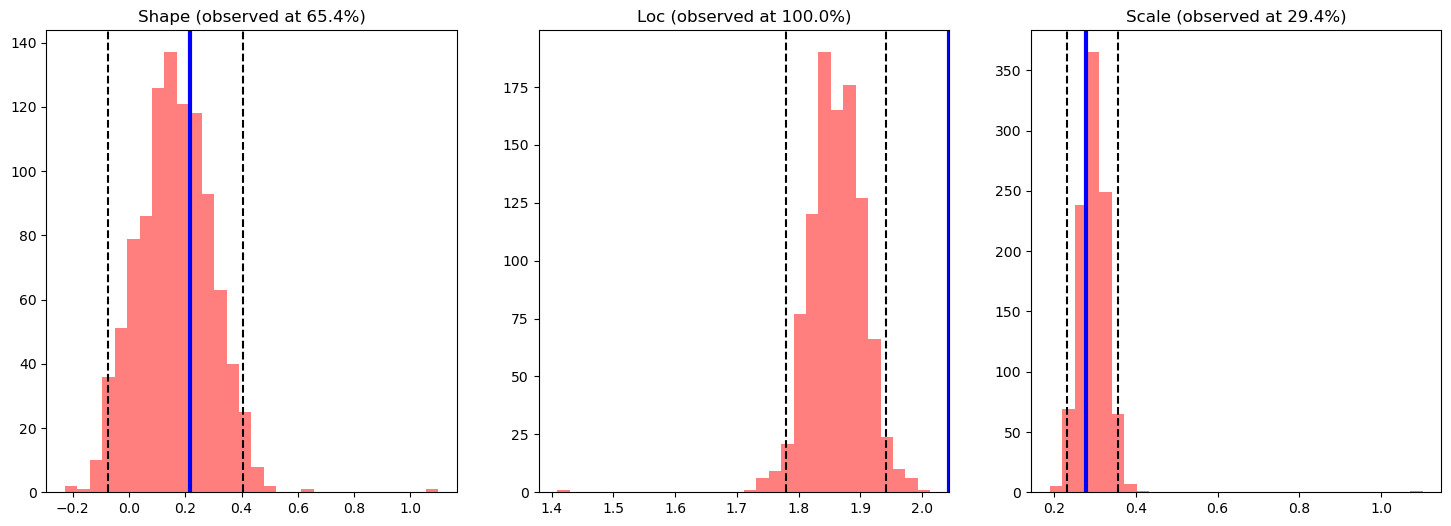

In [68]:
# Set up a subfigure
# with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# for the first one plot the histogram of shape values in red
axs[0].hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[0].axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[0].axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape)

axs[0].set_title("Shape (observed at {:.1f}%)".format(obs_percentile_shape))

# plot the observed value as a vertical line
axs[0].axvline(shape, color="blue", label="ERA5", lw=3)

# for the second one plot the histogram of loc values in red
axs[1].hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[1].axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[1].axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc)

axs[1].set_title("Loc (observed at {:.1f}%)".format(obs_percentile_loc))

# plot the observed value as a vertical line
axs[1].axvline(loc, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
axs[2].hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[2].axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[2].axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale)

axs[2].set_title("Scale (observed at {:.1f}%)".format(obs_percentile_scale))

# plot the observed value as a vertical line
axs[2].axvline(scale, color="blue", label="ERA5", lw=3)

### Same but for temperature block min ###

In [69]:
# import the temperature data
df_model_tas = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv"
)

# set up the djf winter years
djf_winter_years = np.arange(1, 11 + 1)

# set up a new dataframe to append to
df_model_tas_djf = pd.DataFrame()

# loop over the winter years
for i, wyear in enumerate(djf_winter_years):
    # set up the leads to extract
    leads = np.arange(31 + (i * 360), 31 + 90 + (i * 360))

    # extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_tas_djf = pd.concat([df_model_tas_djf, df_model_leads_this])

In [71]:
# load in the canari tas data
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# set up canari_years
canari_years = np.arange(1950, 2014 + 1)
canari_period = "HIST2"

# set up the empty dataframe
model_df_full_canari = pd.DataFrame()

# Check that there are csv files for all of the years
# loop ovber the years
for year in tqdm(canari_years):
    # create the fpath
    fpath = os.path.join(output_dir_dfs, f"canari-le-tas-United_Kingdom-{year}-{canari_period}.csv")
    # check if the file exists
    if not os.path.exists(fpath):
        print(f"Missing file for {year}")
        sys.exit()

    # Load the dataframe
    model_df_this = pd.read_csv(fpath)

    # concatenate the dataframes
    model_df_full_canari = pd.concat([model_df_full_canari, model_df_this], ignore_index=True)

# remove the hh:mm:ss from the time
# time is a str
model_df_full_canari['time'] = model_df_full_canari['time'].str.split(" ").str[0]

# subset the canari model data to D, J, F
# where time is a string
# in the format YYYY-MM-DD
model_df_full_canari_djf = model_df_full_canari[model_df_full_canari['time'].str.split("-").str[1].isin(["12", "01", "02"])]

100%|██████████| 65/65 [00:06<00:00,  9.40it/s]


In [70]:
# import the observed data
# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to D, J, F
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([12, 1, 2])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [90]:
model_df_full_canari_djf_subset.tail()

member        time         tas  effective_dec_year
935995      40  2014-12-26  276.647215                2014
935996      40  2014-12-27  274.838709                2014
935997      40  2014-12-28  275.233602                2014
935998      40  2014-12-29  275.932057                2014
935999      40  2014-12-30  275.815959                2014

In [99]:
df_obs_tas_subset.head()

time        data    data_c  effective_dec_year
335 1960-12-01  281.183557  8.033557                1960
336 1960-12-02  279.261101  6.111101                1960
337 1960-12-03  281.323831  8.173831                1960
338 1960-12-04  279.943259  6.793259                1960
339 1960-12-05  277.735919  4.585919                1960

In [94]:
df_model_tas_djf_first_subset.tail()

init_year  member  lead        data  winter_year  effective_dec_year  \
2021375       2013      10   116  277.211595            1                2013   
2021376       2013      10   117  279.285864            1                2013   
2021377       2013      10   118  280.787285            1                2013   
2021378       2013      10   119  277.388151            1                2013   
2021379       2013      10   120  277.213174            1                2013   

           data_c  
2021375  4.061595  
2021376  6.135864  
2021377  7.637285  
2021378  4.238151  
2021379  4.063174

In [77]:
# subset model djf tas to the first winter
df_model_tas_djf_first = df_model_tas_djf[df_model_tas_djf["winter_year"] == 1]

In [78]:
# add the column for effective dec year to the model data
df_model_tas_djf_first["effective_dec_year"] = df_model_tas_djf_first["init_year"] + (df_model_tas_djf_first["winter_year"] - 1)

In [91]:
# limit all of the datasets to effective dec years 1960 to 2013
df_model_tas_djf_first_subset = df_model_tas_djf_first[
    df_model_tas_djf_first["effective_dec_year"].between(1960, 2013)
]

# limit the obs data to the same effective dec years
df_obs_tas_subset = df_obs_tas[
    df_obs_tas["effective_dec_year"].between(1960, 2013)
]

# limit the canari data to the same effective dec years
model_df_full_canari_djf_subset = model_df_full_canari_djf[
    model_df_full_canari_djf["effective_dec_year"].between(1960, 2013)
]

In [93]:
# create new columns for data_c inh df_model_tas_djf_first_subset
df_model_tas_djf_first_subset["data_c"] = df_model_tas_djf_first_subset["data"] - 273.15

# same for the canari data
model_df_full_canari_djf_subset["data_c"] = model_df_full_canari_djf_subset["tas"] - 273.15

In [81]:
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None

# apply the function to the obs data
df_obs_tas["effective_dec_year"] = df_obs_tas.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

In [83]:
# do the same for the canari data
def determine_effective_dec_year_canari(row):
    year = int(row["time"].split("-")[0])
    month = int(row["time"].split("-")[1])
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
# apply the function to the canari data
model_df_full_canari_djf["effective_dec_year"] = model_df_full_canari_djf.apply(
    lambda row: determine_effective_dec_year_canari(row), axis=1
)

In [102]:
df_obs_tas_subset["effective_dec_year"].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

In [95]:
# Now calculate the lowest temperature day for each effective dec year
df_obs_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_obs_tas_subset["effective_dec_year"].unique():
    # subset the data
    df_this = df_obs_tas_subset[
        df_obs_tas_subset["effective_dec_year"] == year
    ]

    # find the lowest wind day
    lowest_tas_day = df_this["data_c"].idxmin()

    # Create a new dataframe
    df_new = pd.DataFrame(
        {
            "effective_dec_year": [year],
            "time": [lowest_tas_day],
            "data": [df_this.loc[lowest_tas_day, "data_c"]],
        }
    )

    # Append to the new dataframe
    df_obs_lowest_tas_day_djf = pd.concat([df_obs_lowest_tas_day_djf, df_new])

In [104]:
df_obs_lowest_tas_day_djf.tail()

effective_dec_year   time      data
0                2009  18269 -4.169264
0                2010  18616 -4.233131
0                2011  19026 -1.630203
0                2012  19374 -1.522083
0                2013  19753  2.701735

In [105]:
# same for the model data
df_model_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in df_model_tas_djf_first_subset["effective_dec_year"].unique():
    for member in df_model_tas_djf_first_subset["member"].unique():
        # subset the data
        df_this = df_model_tas_djf_first_subset[
            (df_model_tas_djf_first_subset["effective_dec_year"] == year)
            & (df_model_tas_djf_first_subset["member"] == member)
        ]

        # find the lowest wind day
        lowest_tas_day = df_this["data_c"].idxmin()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "effective_dec_year": [year],
                "member": [member],
                "time": [lowest_tas_day],
                "data": [df_this.loc[lowest_tas_day, "data_c"]],
            }
        )

        # Append to the new dataframe
        df_model_lowest_tas_day_djf = pd.concat([df_model_lowest_tas_day_djf, df_new])

In [106]:
# do the same for the canari data
df_canari_lowest_tas_day_djf = pd.DataFrame()

# loop over the effective dec years
for year in model_df_full_canari_djf_subset["effective_dec_year"].unique():
    for member in model_df_full_canari_djf_subset["member"].unique():
        # subset the data
        df_this = model_df_full_canari_djf_subset[
            (model_df_full_canari_djf_subset["effective_dec_year"] == year)
            & (model_df_full_canari_djf_subset["member"] == member)
        ]

        # find the lowest wind day
        lowest_tas_day = df_this["data_c"].idxmin()

        # Create a new dataframe
        df_new = pd.DataFrame(
            {
                "effective_dec_year": [year],
                "member": [member],
                "time": [lowest_tas_day],
                "data": [df_this.loc[lowest_tas_day, "data_c"]],
            }
        )

        # Append to the new dataframe
        df_canari_lowest_tas_day_djf = pd.concat([df_canari_lowest_tas_day_djf, df_new])

In [107]:
df_canari_lowest_tas_day_djf.head()

effective_dec_year  member    time      data
0                1960       1  144350 -1.445395
0                1960       2  158791 -3.529893
0                1960       3  159132 -6.243748
0                1960       4  159502 -5.877452
0                1960       5  159842 -4.750289

In [108]:
df_model_lowest_tas_day_djf.head()

effective_dec_year  member   time      data
0                1960       1     92 -0.088807
0                1960       2   3809 -0.894575
0                1960       3   7583  0.071863
0                1960       4  11364  0.448920
0                1960       5  15054 -0.451000

In [109]:
df_obs_lowest_tas_day_djf.head()

effective_dec_year  time      data
0                1960   376 -0.392873
0                1961   731 -3.468196
0                1962  1107 -6.757083
0                1963  1449 -2.562683
0                1964  1823 -3.339781

Now we want to plot the trend and residual for each of the different datasets.

Start with the obs.

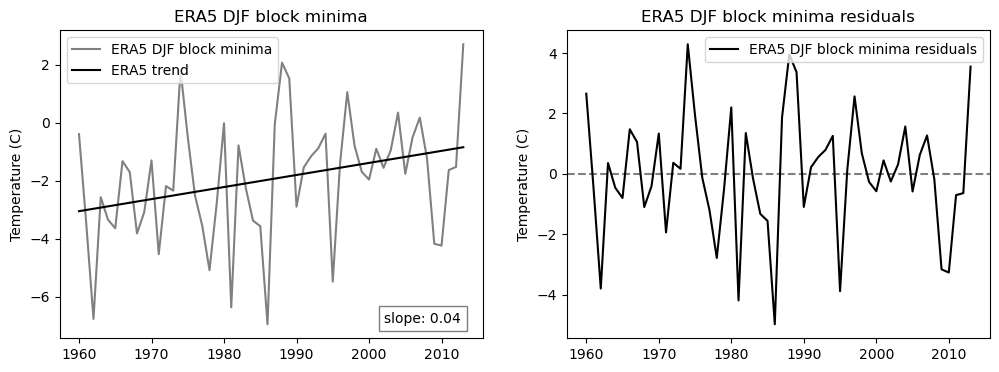

In [124]:
# set up a figure with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# plot the time series of the lowest temperature days
# for the obs
axs[0].plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data"], label="ERA5 DJF block minima", color="grey")

# fit a linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_obs_lowest_tas_day_djf["effective_dec_year"],
    df_obs_lowest_tas_day_djf["data"],
)

# plot the linear regression
axs[0].plot(
    df_obs_lowest_tas_day_djf["effective_dec_year"],
    intercept + slope * df_obs_lowest_tas_day_djf["effective_dec_year"],
    label=f"ERA5 trend",
    color="black",
)

# include the slope value in the bottom right
axs[0].text(
    0.95,
    0.05,
    f"slope: {slope:.2f}",
    transform=axs[0].transAxes,
    bbox=dict(facecolor="white", alpha=0.5),
    horizontalalignment="right",
)

# add a legend in the top left
axs[0].legend(loc="upper left")

# set the title
axs[0].set_title("ERA5 DJF block minima")

# Set the ylabel
axs[0].set_ylabel("Temperature (C)")

# include a horizontal line at 0
axs[1].axhline(0, color="grey", linestyle="--")

# plot the residuals
axs[1].plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data"] - (intercept + slope * df_obs_lowest_tas_day_djf["effective_dec_year"]), label="ERA5 DJF block minima residuals", color="black")

# set the title
axs[1].set_title("ERA5 DJF block minima residuals")

# set the ylabel
axs[1].set_ylabel("Temperature (C)")

# incude the legend
axs[1].legend()

Ensemble mean slope: 0.022927719846827746
Ensemble mean intercept: -47.15670044102235


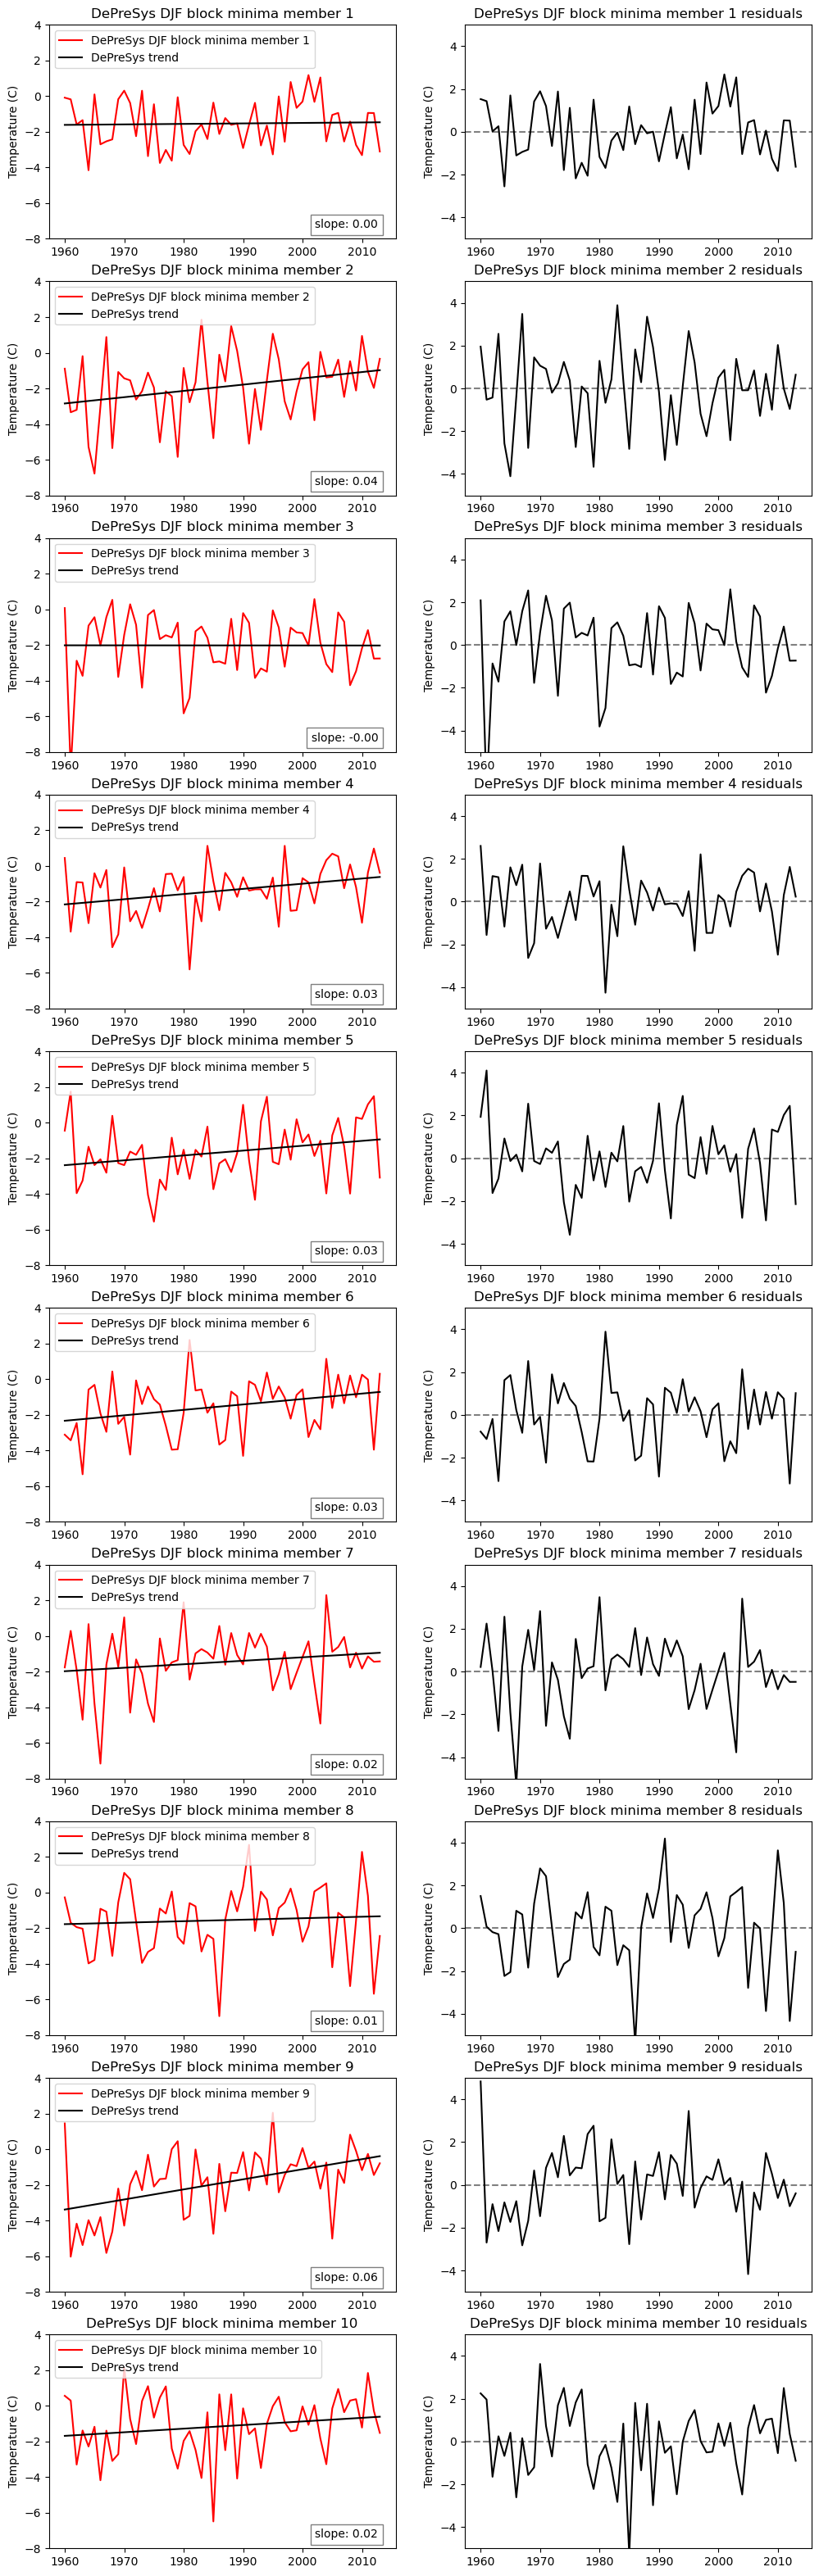

In [129]:
# Do the same, bu for all ensemble members of the model data
# set up a figure with 10 rows and two columns
fig, axs = plt.subplots(10, 2, figsize=(12, 40))

# set up the slopes
slopes = np.zeros(10)
intercepts = np.zeros(10)

# loop over the members
for i, member in enumerate(df_model_lowest_tas_day_djf["member"].unique()):
    # subset the data
    df_this = df_model_lowest_tas_day_djf[
        df_model_lowest_tas_day_djf["member"] == member
    ]

    # plot the time series of the lowest temperature days
    # for the obs
    axs[i, 0].plot(df_this["effective_dec_year"], df_this["data"], label=f"DePreSys DJF block minima member {member}", color="red")

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["effective_dec_year"],
        df_this["data"],
    )

    slopes[i] = slope
    intercepts[i] = intercept

    # plot the linear regression
    axs[i, 0].plot(
        df_this["effective_dec_year"],
        intercept + slope * df_this["effective_dec_year"],
        label=f"DePreSys trend",
        color="black",
    )

    # include the slope value in the bottom right
    axs[i, 0].text(
        0.95,
        0.05,
        f"slope: {slope:.2f}",
        transform=axs[i, 0].transAxes,
        bbox=dict(facecolor="white", alpha=0.5),
        horizontalalignment="right",
    )

    # add a legend in the top left
    axs[i, 0].legend(loc="upper left")

    # set the title
    axs[i, 0].set_title(f"DePreSys DJF block minima member {member}")

    # Set the ylabel
    axs[i, 0].set_ylabel("Temperature (C)")

    # set constant ylims (-6, +6)
    axs[i, 0].set_ylim(-8, 4)

    # include a horizontal line at 0
    axs[i, 1].axhline(0, color="grey", linestyle="--")

    # plot the residuals
    axs[i, 1].plot(df_this["effective_dec_year"], df_this["data"] - (intercept + slope * df_this["effective_dec_year"]), label=f"DePreSys DJF block minima member {member} residuals", color="black")

    # set the title
    axs[i, 1].set_title(f"DePreSys DJF block minima member {member} residuals")

    # set the ylabel
    axs[i, 1].set_ylabel("Temperature (C)")

    # set constant ylims (-6, +6)
    axs[i, 1].set_ylim(-5, 5)

# print the ensemble mean slope
print(f"Ensemble mean slope: {slopes.mean()}")
print(f"Ensemble mean intercept: {intercepts.mean()}")

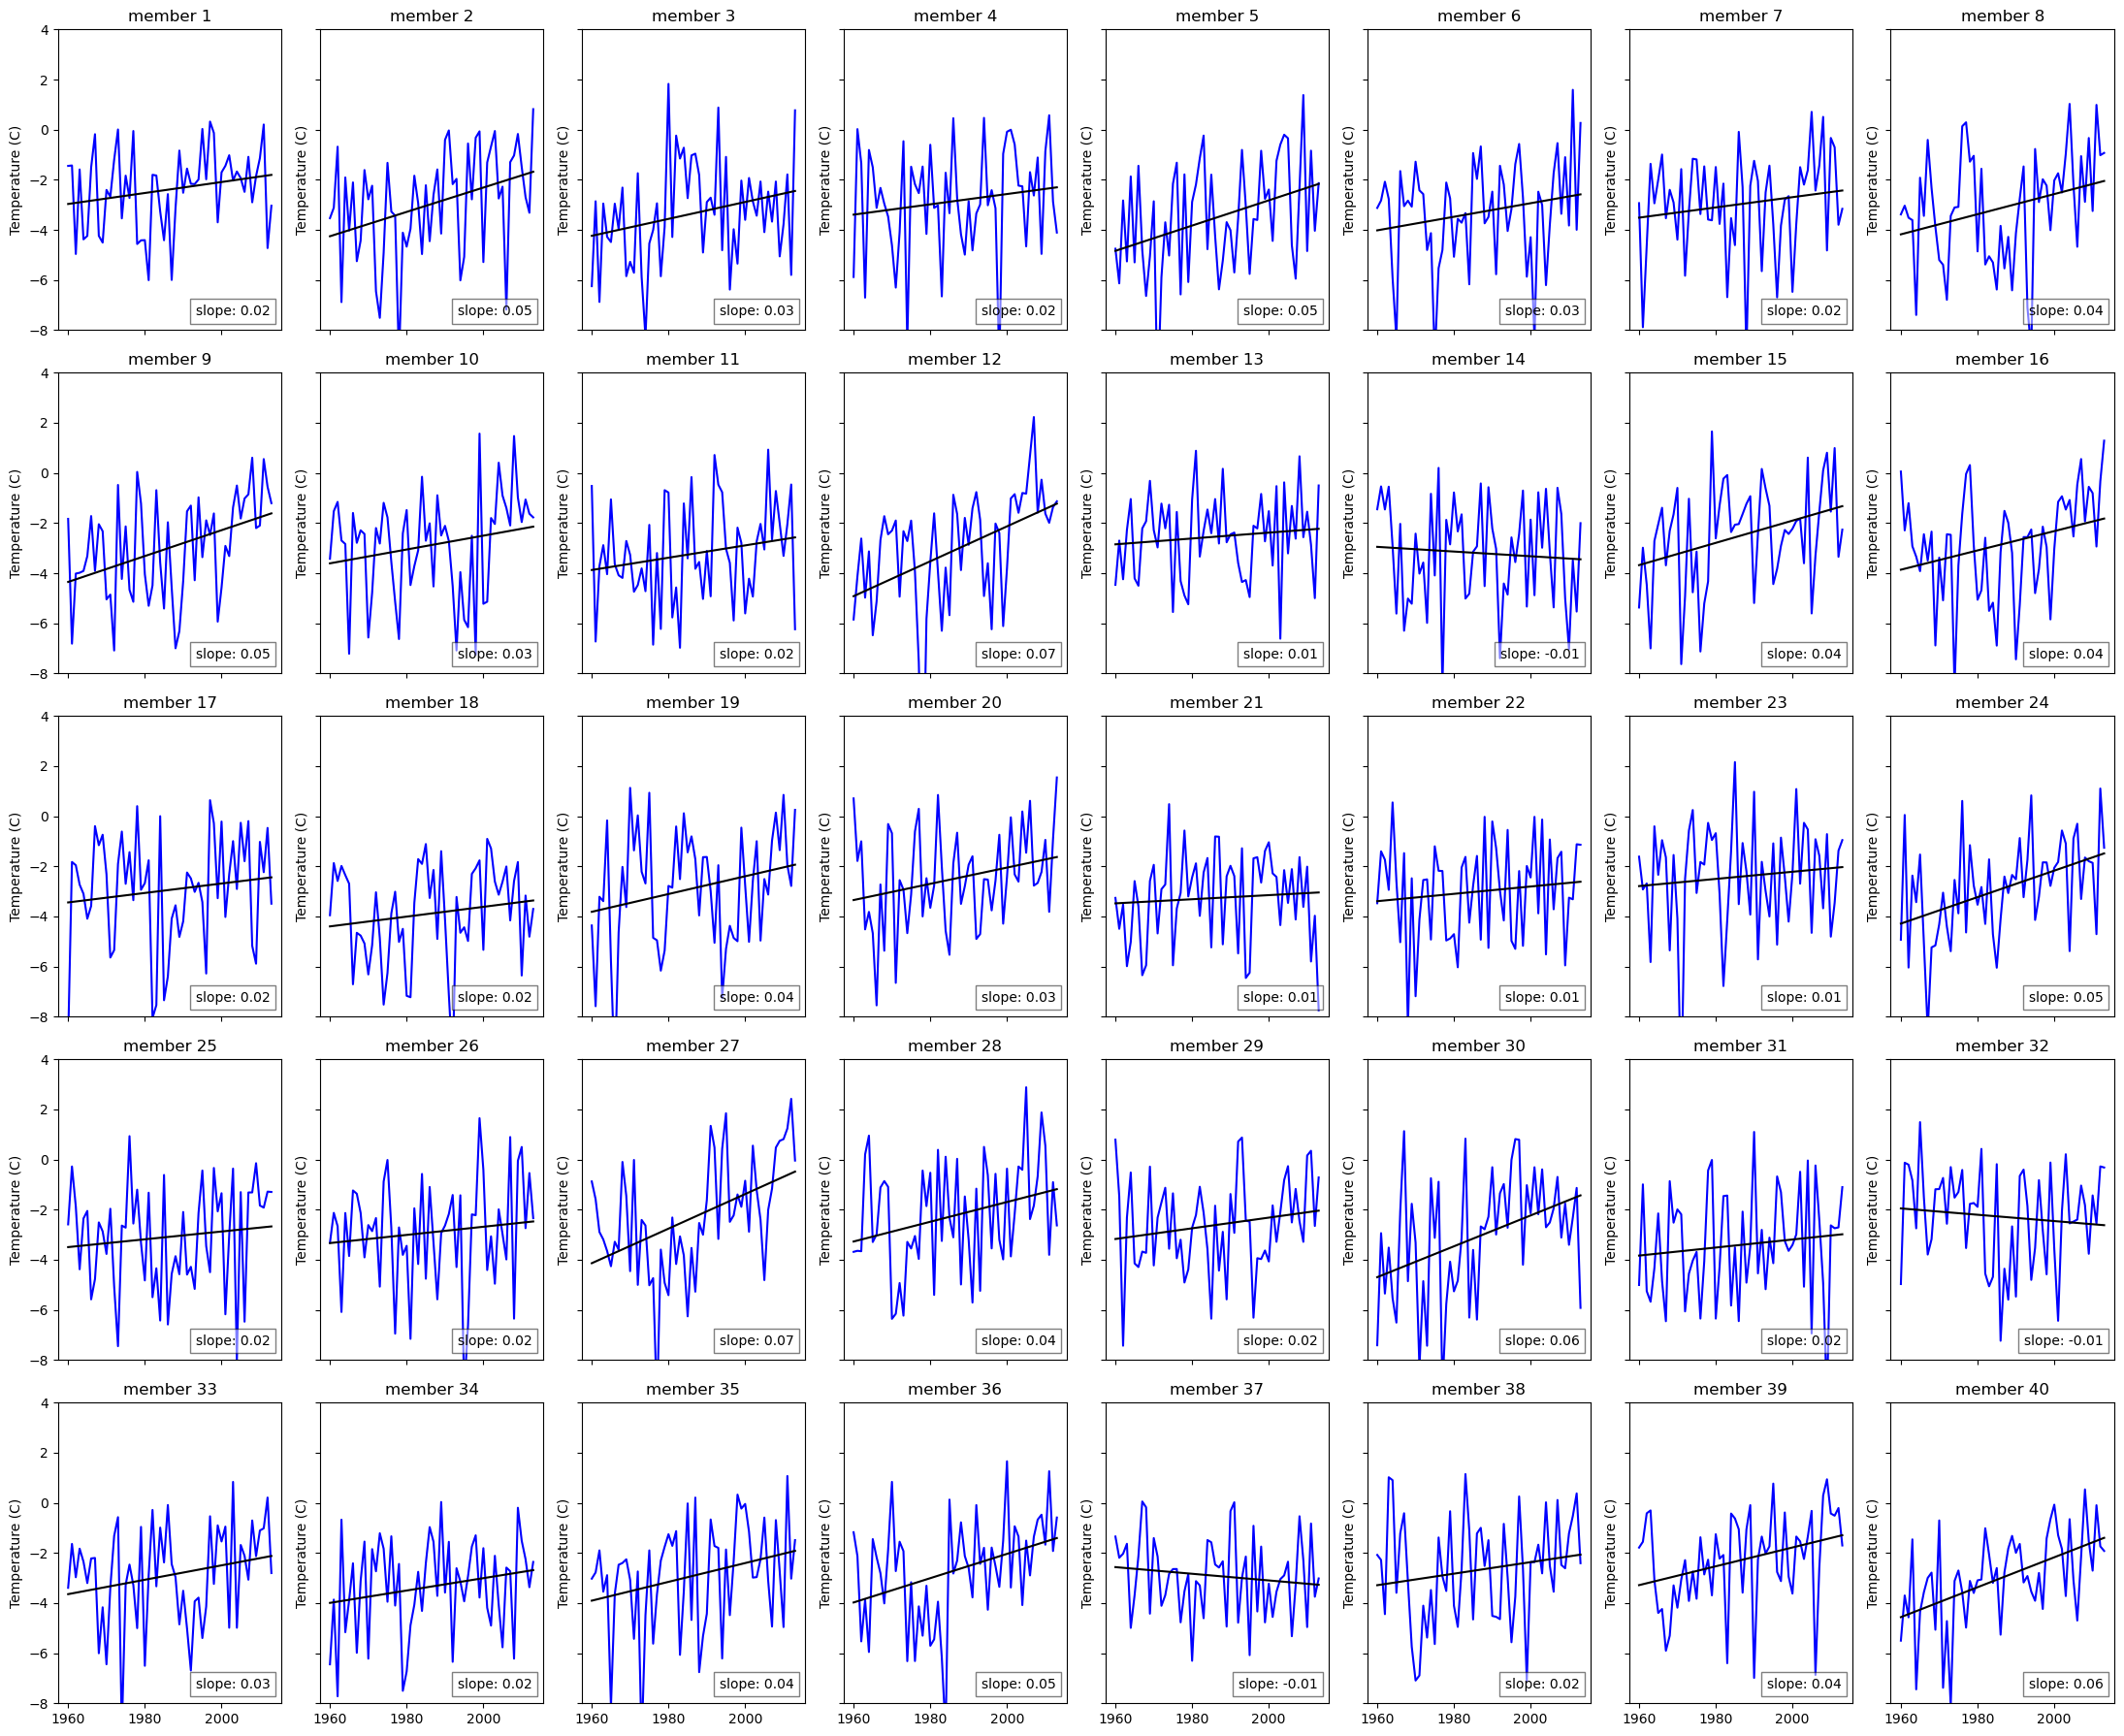

In [136]:
# do the same for the canari data

# set up a figure with 4 rows and 8 columns
fig, axs = plt.subplots(5, 8, figsize=(22, 18), sharex=True, sharey=True)

# set up the slopes
slopes = np.zeros(40)
intercepts = np.zeros(40)

# loop over the members
for i, member in enumerate(df_canari_lowest_tas_day_djf["member"].unique()):
    # subset the data
    df_this = df_canari_lowest_tas_day_djf[
        df_canari_lowest_tas_day_djf["member"] == member
    ]

    # plot the time series of the lowest temperature days
    # for the obs
    axs[i // 8, i % 8].plot(df_this["effective_dec_year"], df_this["data"], label=f"Canari DJF block minima member {member}", color="blue")

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["effective_dec_year"],
        df_this["data"],
    )

    slopes[i] = slope
    intercepts[i] = intercept

    # plot the linear regression
    axs[i // 8, i % 8].plot(
        df_this["effective_dec_year"],
        intercept + slope * df_this["effective_dec_year"],
        label=f"Canari trend",
        color="black",
    )

    # include the slope value in the bottom right
    axs[i // 8, i % 8].text(
        0.95,
        0.05,
        f"slope: {slope:.2f}",
        transform=axs[i // 8, i % 8].transAxes,
        bbox=dict(facecolor="white", alpha=0.5),
        horizontalalignment="right",
    )

    # # add a legend in the top left
    # axs[i // 8, i % 8].legend(loc="upper left")

    # set the title
    axs[i // 8, i % 8].set_title(f"member {member}")

    # Set the ylabel
    axs[i // 8, i % 8].set_ylabel("Temperature (C)")

    # set constant ylims (-6, +6)
    axs[i // 8, i % 8].set_ylim(-8, 4)

    # # include a horizontal line at 0
    # axs[i // 8, i % 8].axhline(0, color="grey", linestyle="--")

    # # plot the residuals
    # axs[i // 8, i % 8].plot(df_this["effective_dec_year"], df_this["data"] - (intercept + slope * df_this["effective_dec_year"]), label=f"Canari DJF block minima member {member} residuals", color="black")

    # specify a tight layout
    plt.tight_layout()

In [138]:
# print the ensmean slope and intercept
print(f"Ensemble mean slope: {slopes.mean()}")
print(f"Ensemble mean intercept: {intercepts.mean()}")

Ensemble mean slope: 0.02976368509777843
Ensemble mean intercept: -62.0242259806545


In [140]:
# create a new column in df_obs_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
obs_slope, obs_intercept, r_value, p_value, std_err = stats.linregress(
    df_obs_lowest_tas_day_djf["effective_dec_year"],
    df_obs_lowest_tas_day_djf["data"],
)

df_obs_lowest_tas_day_djf["data_dt"] = df_obs_lowest_tas_day_djf["data"] - (obs_intercept + obs_slope * df_obs_lowest_tas_day_djf["effective_dec_year"])

In [142]:
# calulate the ensemble mean trend for the model data
dps_slopes = np.zeros(10)
dps_intercepts = np.zeros(10)

# loop over the members
for i, member in enumerate(df_model_lowest_tas_day_djf["member"].unique()):
    # subset the data
    df_this = df_model_lowest_tas_day_djf[
        df_model_lowest_tas_day_djf["member"] == member
    ]

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["effective_dec_year"],
        df_this["data"],
    )

    dps_slopes[i] = slope
    dps_intercepts[i] = intercept

# calculate the ensemble mean slope and intercept
dps_slope = dps_slopes.mean()
dps_intercept = dps_intercepts.mean()

# create a new column in df_model_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
df_model_lowest_tas_day_djf["data_dt"] = df_model_lowest_tas_day_djf["data"] - (dps_intercept + dps_slope * df_model_lowest_tas_day_djf["effective_dec_year"])

In [143]:
# do the same for the canari data
canari_slopes = np.zeros(40)
canari_intercepts = np.zeros(40)

# loop over the members
for i, member in enumerate(df_canari_lowest_tas_day_djf["member"].unique()):
    # subset the data
    df_this = df_canari_lowest_tas_day_djf[
        df_canari_lowest_tas_day_djf["member"] == member
    ]

    # fit a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_this["effective_dec_year"],
        df_this["data"],
    )

    canari_slopes[i] = slope
    canari_intercepts[i] = intercept

# calculate the ensemble mean slope and intercept
canari_slope = canari_slopes.mean()
canari_intercept = canari_intercepts.mean()

# create a new column in df_canari_lowest_tas_day_djf for the data_dt
# which is the residual after the linear trend has been removed
df_canari_lowest_tas_day_djf["data_dt"] = df_canari_lowest_tas_day_djf["data"] - (canari_intercept + canari_slope * df_canari_lowest_tas_day_djf["effective_dec_year"])

In [160]:
df_canari_lowest_tas_day_djf.head()

effective_dec_year  member    time      data   data_dt
0                1960       1  144350 -1.445395  2.242008
0                1960       2  158791 -3.529893  0.157511
0                1960       3  159132 -6.243748 -2.556345
0                1960       4  159502 -5.877452 -2.190049
0                1960       5  159842 -4.750289 -1.062886

(-8.0, 8.0)

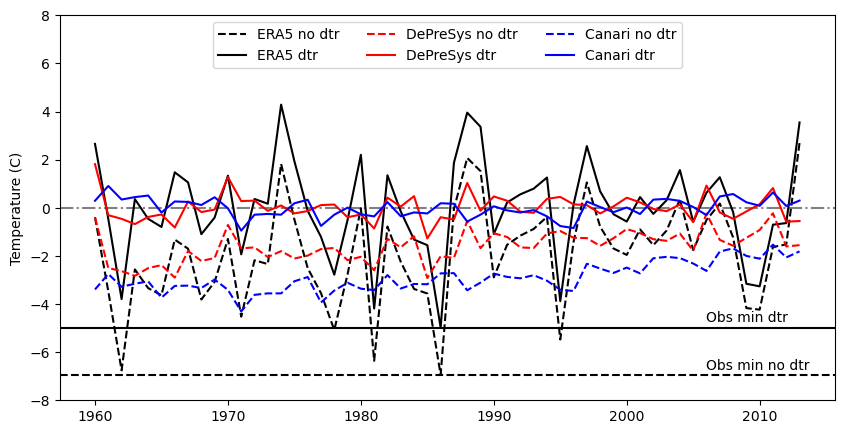

In [165]:
# set up a figure
# set up a figure with size 10x5
fig, ax = plt.subplots(figsize=(10, 5))

# include a horizontal line at 0
ax.axhline(0, color="grey", linestyle="-.")

# plot the observed time series (no dt) as a black dashed line
ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data"], color="black", linestyle="--", label="ERA5 no dtr")

# plot the observed time series (dt) as a black solid line
ax.plot(df_obs_lowest_tas_day_djf["effective_dec_year"], df_obs_lowest_tas_day_djf["data_dt"], color="black", label="ERA5 dtr")

# include a dashed solid black line for the min value of the observed data (no dt)
ax.axhline(df_obs_lowest_tas_day_djf["data"].min(), color="black", linestyle="--")

# include a solid black line for the min value of the observed data (dt)
ax.axhline(df_obs_lowest_tas_day_djf["data_dt"].min(), color="black")

# include text on these lines
ax.text(
    2006,
    df_obs_lowest_tas_day_djf["data"].min() + 0.1,
    f"Obs min no dtr",
    color="black",
    verticalalignment="bottom",
)

ax.text(
    2006,
    df_obs_lowest_tas_day_djf["data_dt"].min() + 0.1,
    f"Obs min dtr",
    color="black",
    verticalalignment="bottom",
)

# ad a red line for the ensemble mean of the model data (no dt)
# mean over all of the members
ax.plot(df_model_lowest_tas_day_djf["effective_dec_year"].unique(), df_model_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="red", linestyle="--", label="DePreSys no dtr")

# add a red line for the ensemble mean of the model data (dt)
# mean over all of the members
ax.plot(df_model_lowest_tas_day_djf["effective_dec_year"].unique(), df_model_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="red", label="DePreSys dtr")

# Do the same for the canari data
# mean over all of the members
ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data"].mean(), color="blue", linestyle="--", label="Canari no dtr")

# add a red line for the ensemble mean of the model data (dt)
# mean over all of the members
ax.plot(df_canari_lowest_tas_day_djf["effective_dec_year"].unique(), df_canari_lowest_tas_day_djf.groupby("effective_dec_year")["data_dt"].mean(), color="blue", label="Canari dtr")

# Include the y label
ax.set_ylabel("Temperature (C)")

# include a legend
# in the top centre
ax.legend(loc="upper center", ncol=3)

# set the ylims
ax.set_ylim(-8, 8)

Now do the fidelity testing on the detrended data

In [168]:
# First fit a model to the observations
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_tas_day_djf["data_dt"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 1000

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_model_lowest_tas_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_tas_day_djf["data_dt"].values)
    for y, year in enumerate(df_obs_lowest_tas_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_model_lowest_tas_day_djf[
            df_model_lowest_tas_day_djf["effective_dec_year"] == year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            df_model_this["member"] == random_member
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data_dt"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

  1%|          | 6/1000 [00:00<00:41, 24.10it/s]

100%|██████████| 1000/1000 [00:37<00:00, 26.70it/s]


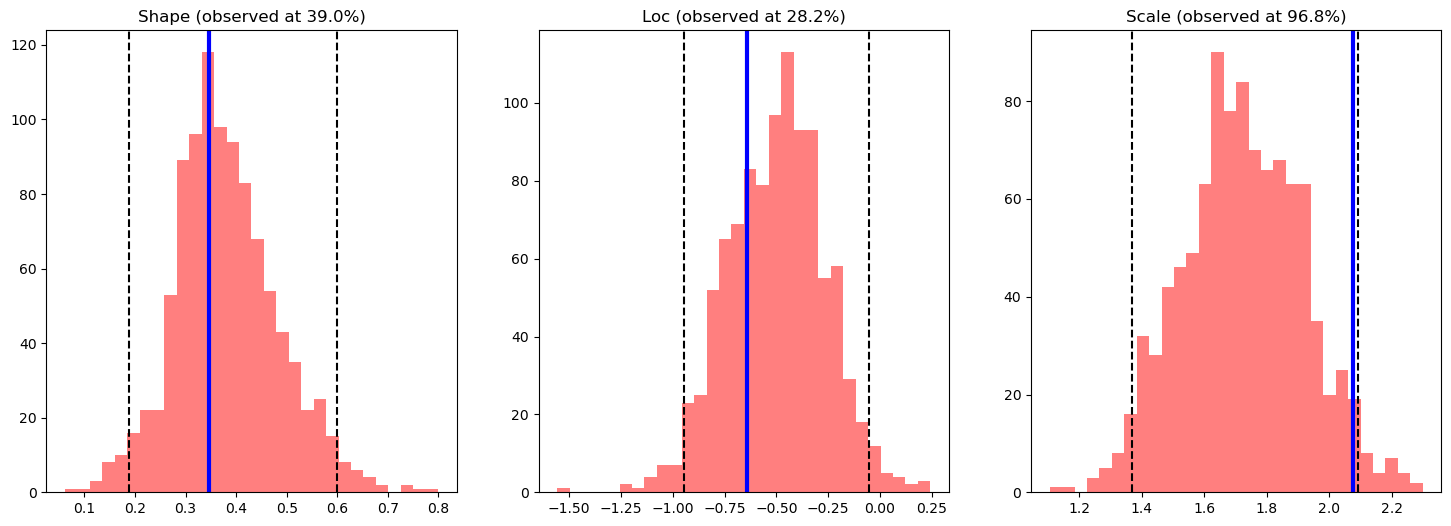

In [169]:
# Set up a subfigure
# with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# for the first one plot the histogram of shape values in red
axs[0].hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[0].axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[0].axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

axs[0].set_title("Shape (observed at {:.1f}%)".format(obs_percentile_shape))

# plot the observed value as a vertical line
axs[0].axvline(shape_obs, color="blue", label="ERA5", lw=3)

# for the second one plot the histogram of loc values in red
axs[1].hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[1].axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[1].axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

axs[1].set_title("Loc (observed at {:.1f}%)".format(obs_percentile_loc))

# plot the observed value as a vertical line
axs[1].axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
axs[2].hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[2].axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[2].axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

axs[2].set_title("Scale (observed at {:.1f}%)".format(obs_percentile_scale))

# plot the observed value as a vertical line
axs[2].axvline(scale_obs, color="blue", label="ERA5", lw=3)

In [170]:
# First fit a model to the observations
shape_obs, loc_obs, scale_obs = gev.fit(df_obs_lowest_tas_day_djf["data_dt"])

# Now resample the obs to get a distribution of the lowest wind days
# Set up the nboot
nboot = 1000

# set up a dictionary to store the gev params
gev_params = {
    "shape": [np.zeros(nboot)],
    "loc": [np.zeros(nboot)],
    "scale": [np.zeros(nboot)],
}

# set up the number of unique members in the model data
n_members = df_canari_lowest_tas_day_djf["member"].nunique()

# loop over the nboot
for i in tqdm(range(nboot)):
    pseudo_timeseries_this = np.zeros_like(df_obs_lowest_tas_day_djf["data_dt"].values)
    for y, year in enumerate(df_obs_lowest_tas_day_djf["effective_dec_year"].unique()):
        # Subset the data
        df_model_this = df_canari_lowest_tas_day_djf[
            df_canari_lowest_tas_day_djf["effective_dec_year"] == year
        ]

        # pick a random memebr
        random_member = np.random.choice(np.arange(1, n_members + 1))

        # subset the data
        df_model_this = df_model_this[
            df_model_this["member"] == random_member
        ]

        # get the data
        pseudo_timeseries_this[y] = df_model_this["data_dt"].values[0]

    # fit the gev distribution
    shape_this, loc_this, scale_this = gev.fit(pseudo_timeseries_this)

    # store the gev params
    gev_params["shape"][0][i] = shape_this
    gev_params["loc"][0][i] = loc_this
    gev_params["scale"][0][i] = scale_this

100%|██████████| 1000/1000 [00:37<00:00, 26.57it/s]


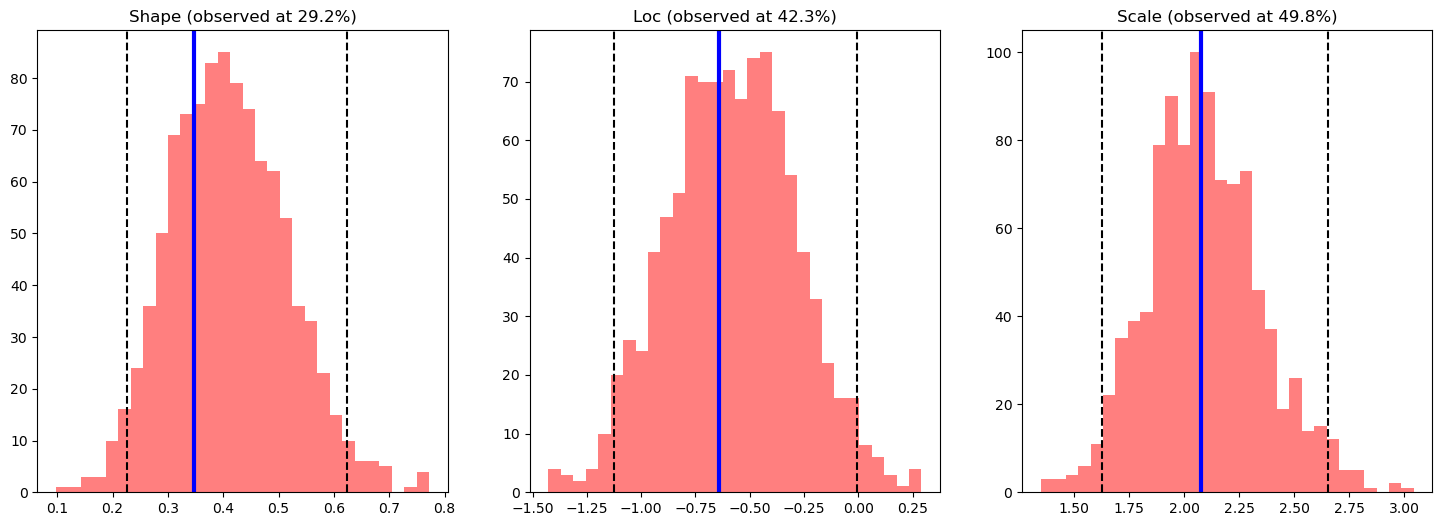

In [171]:
# Set up a subfigure
# with three subplots side by side
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# for the first one plot the histogram of shape values in red
axs[0].hist(gev_params["shape"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[0].axvline(
    np.percentile(gev_params["shape"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[0].axvline(
    np.percentile(gev_params["shape"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for shape
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_shape = stats.percentileofscore(gev_params["shape"][0], shape_obs)

axs[0].set_title("Shape (observed at {:.1f}%)".format(obs_percentile_shape))

# plot the observed value as a vertical line
axs[0].axvline(shape_obs, color="blue", label="ERA5", lw=3)

# for the second one plot the histogram of loc values in red
axs[1].hist(gev_params["loc"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[1].axvline(
    np.percentile(gev_params["loc"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[1].axvline(
    np.percentile(gev_params["loc"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for loc
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_loc = stats.percentileofscore(gev_params["loc"][0], loc_obs)

axs[1].set_title("Loc (observed at {:.1f}%)".format(obs_percentile_loc))

# plot the observed value as a vertical line
axs[1].axvline(loc_obs, color="blue", label="ERA5", lw=3)

# for the third one plot the histogram of scale values in red
axs[2].hist(gev_params["scale"][0], color="red", alpha=0.5, bins=30)

# mark the 2.5%tile as a dashed vertical line
axs[2].axvline(
    np.percentile(gev_params["scale"][0], 2.5),
    color="black",
    linestyle="--",
    label="2.5%tile",
)

# mark the 97.5%tile as a dashed vertical line
axs[2].axvline(
    np.percentile(gev_params["scale"][0], 97.5),
    color="black",
    linestyle="--",
    label="97.5%tile",
)

# include a title for scale
# indicate the position of the observed value as a % of the way through the model distribution
obs_percentile_scale = stats.percentileofscore(gev_params["scale"][0], scale_obs)

axs[2].set_title("Scale (observed at {:.1f}%)".format(obs_percentile_scale))

# plot the observed value as a vertical line
axs[2].axvline(scale_obs, color="blue", label="ERA5", lw=3)

Now do the dot plot using both the detrended DePreSys and Canari data.

-4.975475025387624
lowest value in 1986
the chance of a 1986-like winter event occuring each winter in DePreSys is 1 in 180 years
the chance of a 1986-like winter event occuring each winter in Canari is 1 in 80 years


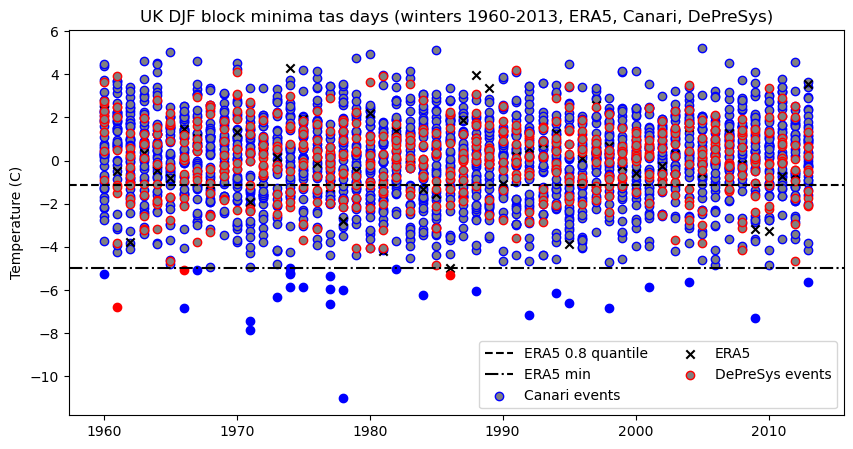

In [190]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# add a horizontal black dashed line for the 0.8 quantile of the observations
ax.axhline(
    df_obs_lowest_tas_day_djf["data_dt"].quantile(0.2),
    color="black",
    linestyle="--",
    label="ERA5 0.8 quantile",
)

# add a horizontal black dashed dotted line for the min value of the observations
ax.axhline(
    df_obs_lowest_tas_day_djf["data_dt"].min(),
    color="black",
    linestyle="-.",
    label="ERA5 min",
)

# set up the very bad events for canari
very_bad_events_canari = df_canari_lowest_tas_day_djf[
    df_canari_lowest_tas_day_djf["data_dt"] < df_obs_lowest_tas_day_djf["data_dt"].min()
]

# set up the events for canari
events_canari = df_canari_lowest_tas_day_djf[
    df_canari_lowest_tas_day_djf["data_dt"] > df_obs_lowest_tas_day_djf["data_dt"].min()
]

# plot the scatter points for the very bad events as blue circles
ax.scatter(
    very_bad_events_canari["effective_dec_year"],
    very_bad_events_canari["data_dt"],
    color="blue",
    marker="o",
)

# plot the scatter points for the events as grey circles
# plot the scatter points for the events as grey circles with a blue outline
ax.scatter(
    events_canari["effective_dec_year"],
    events_canari["data_dt"],
    facecolor="grey",
    edgecolor="blue",
    marker="o",
    label="Canari events",
)

# plot the scatter points for the observations
# as black crosses
ax.scatter(
    df_obs_lowest_tas_day_djf["effective_dec_year"],
    df_obs_lowest_tas_day_djf["data_dt"],
    color="black",
    marker="x",
    label="ERA5",
)

# subset the model data to very bad events
very_bad_events_dps = df_model_lowest_tas_day_djf[
    df_model_lowest_tas_day_djf["data_dt"] < df_obs_lowest_tas_day_djf["data_dt"].min()
]

# set uip the events for dps
events_dps = df_model_lowest_tas_day_djf[
    df_model_lowest_tas_day_djf["data_dt"] > df_obs_lowest_tas_day_djf["data_dt"].min()
]

# plot the scatter points for the very bad events as red circles
ax.scatter(
    very_bad_events_dps["effective_dec_year"],
    very_bad_events_dps["data_dt"],
    color="red",
    marker="o",
)

# plot the scatter points for the events as grey circles
# plot the scatter points for the events as grey circles with a red outline
ax.scatter(
    events_dps["effective_dec_year"],
    events_dps["data_dt"],
    facecolor="grey",
    edgecolor="red",
    marker="o",
    label="DePreSys events",
)

# Set up the ylabel
ax.set_ylabel("Temperature (C)")

# set up the title
ax.set_title("UK DJF block minima tas days (winters 1960-2013, ERA5, Canari, DePreSys)")

# include a legend in the bottom right
ax.legend(loc="lower right", ncol=2)

# print the obs min value and the year
print(df_obs_lowest_tas_day_djf["data_dt"].min())
print(f"lowest value in {df_obs_lowest_tas_day_djf[df_obs_lowest_tas_day_djf['data_dt'] == df_obs_lowest_tas_day_djf['data_dt'].min()]['effective_dec_year'].values[0]}")

# print the empirical return period of 1986 using only the obs data
# for the DePreSys data
print(f"the chance of a 1986-like winter event occuring each winter in DePreSys is 1 in {round(len(df_model_lowest_tas_day_djf) / len(very_bad_events_dps))} years")

# for the Canari data
print(f"the chance of a 1986-like winter event occuring each winter in Canari is 1 in {round(len(df_canari_lowest_tas_day_djf) / len(very_bad_events_canari))} years")

In [ ]:
# find 

the number of unique winters is:  57
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Number of days in a model winter: 90
Number of days to resample for: 5130


Calculating bootstrap statistics:   1%|          | 7/1000 [00:00<00:14, 66.35it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:15<00:00, 65.62it/s]


(1000,)
shape of obs df obs_val_name:  (5144,)


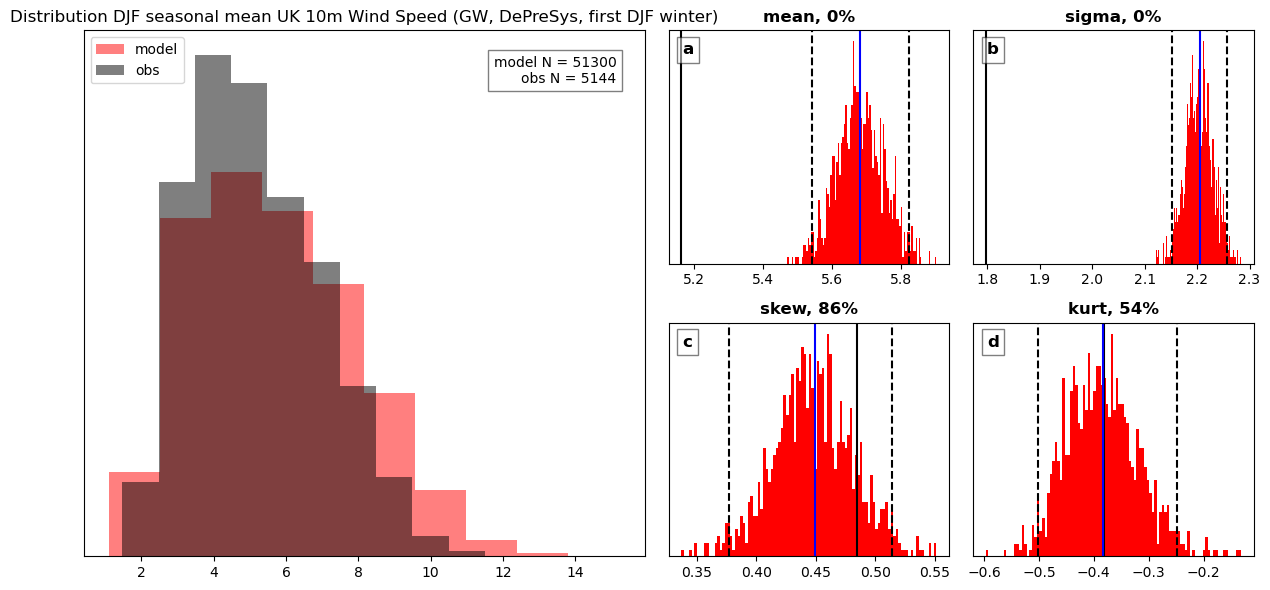

In [ ]:
# Plot the distribution of 10m wind speed for the UK
func.plot_distributions_fidelity(
    obs_df=df_obs_sfcWind_uk_djf,
    model_df=df_model_ondjfm_djf_first_subset, # first ONDJFM winter
    obs_val_name="data",
    model_val_name="data",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name="winter_year",
    title="Distribution DJF seasonal mean UK 10m Wind Speed (GW, DePreSys, first DJF winter)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="UK_10m_wind_speed_DJF_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [54]:
df_canari_uk_daily_djf["effective_dec_year"].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

In [55]:
df_obs_sfcWind_uk_djf["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [56]:
# throw away rows for effective dec year 1960 for canari
# df_canari_uk_daily_ondjfm_subset = df_canari_uk_daily_ondjfm[
#     df_canari_uk_daily_ondjfm["effective_dec_year"].between(1961, 2014)
# ]

# throw away rows for effective dec year 1960 for canari
df_canari_uk_daily_djf_subset = df_canari_uk_daily_djf[
    df_canari_uk_daily_djf["effective_dec_year"].between(1961, 2014)
]


In [57]:
# subset the obs data to the same effective years as the model
# df_obs_sfcWind_uk_subset = df_obs_sfcWind_uk[
#     df_obs_sfcWind_uk["effective_dec_year"].isin(df_canari_uk_daily_ondjfm_subset["effective_dec_year"].unique())
# ]

# subset the obs data to the same effective years as the model
df_obs_sfcWind_uk_djf_subset = df_obs_sfcWind_uk_djf[
    df_obs_sfcWind_uk_djf["effective_dec_year"].isin(df_canari_uk_daily_djf_subset["effective_dec_year"].unique())
]

In [58]:
df_canari_uk_daily_djf_subset.head()

date  member  sfcWind_u  sfcWind_v   sfcWind  effective_dec_year
171600  1961-12-01       1   0.138264   3.288632  3.464413                1961
171601  1961-12-01       2  -5.651360   1.246951  5.821988                1961
171602  1961-12-01       3   5.408591  -6.831989  8.770637                1961
171603  1961-12-01       4   0.545443   2.074062  2.433958                1961
171604  1961-12-01       5   3.318214   5.711458  6.652096                1961

the number of unique winters is:  53
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
Number of days in a model winter: 90
Number of days to resample for: 4770


Calculating bootstrap statistics:   1%|          | 7/1000 [00:00<00:16, 60.64it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:16<00:00, 60.50it/s]


(1000,)
shape of obs df obs_val_name:  (4783,)


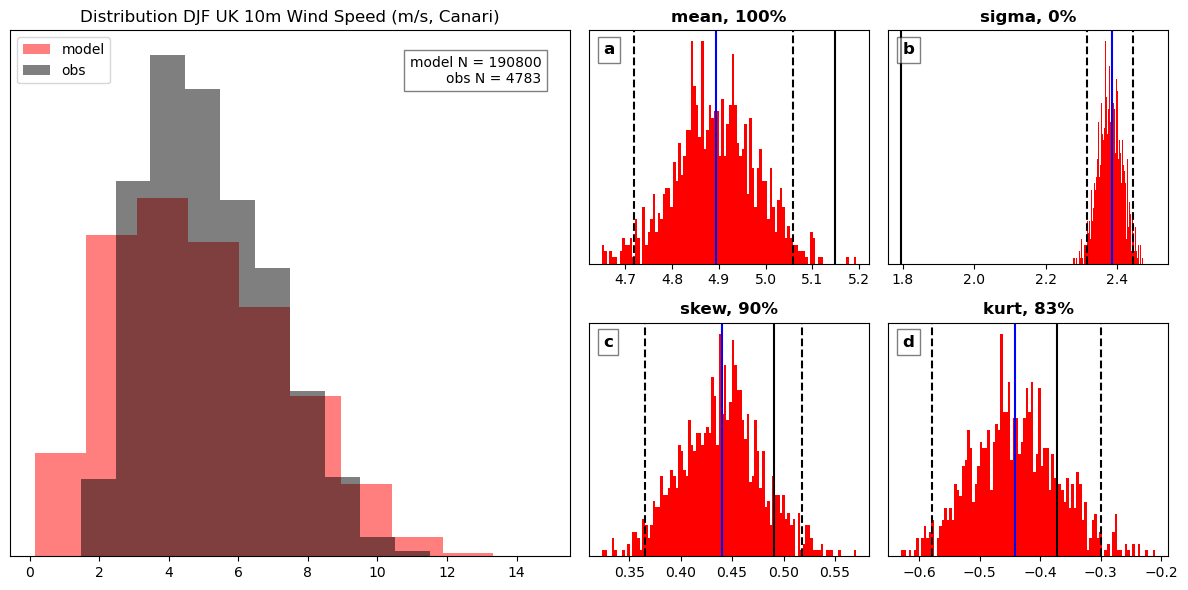

In [59]:
# do the same but for canari
# do the same but for the north sea
func.plot_distributions_fidelity(
    obs_df=df_obs_sfcWind_uk_djf_subset,
    model_df=df_canari_uk_daily_djf_subset,
    model_val_name="sfcWind",
    obs_val_name="data",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name=None,
    title="Distribution DJF UK 10m Wind Speed (m/s, Canari)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="UK_10m_wind_speed_DJF_fidelity_canari",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [27]:
df_obs_sfcWind_ns["time"] = pd.to_datetime(df_obs_sfcWind_ns["time"])

# apply the function
df_obs_sfcWind_ns["effective_dec_year"] = df_obs_sfcWind_ns.apply(
    lambda row: determine_effective_dec_year(row), axis=1
)

In [85]:
# subset df_model_ondjfm_ns to the same effective dec years as the obs
df_model_ondjfm_ns = df_model_ondjfm_ns[
    df_model_ondjfm_ns["effective_dec_year"].isin(df_obs_sfcWind_ns["effective_dec_year"].unique())
]

the number of unique winters is:  54
the unique times are:  [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
Number of days in a model winter: 180
Number of days to resample for: 9720


Calculating bootstrap statistics:   0%|          | 2/1000 [00:00<00:58, 17.18it/s]

Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:57<00:00, 17.38it/s]


(1000,)
shape of obs df obs_val_name:  (9841,)
Obs stats: 
{'mean': np.float64(8.769760214205872), 'sigma': np.float64(2.7013283516807847), 'skew': np.float64(0.24715394961025483), 'kurt': np.float64(-0.4189805032081808)}
Model stats full: 
{'mean': np.float64(9.38199017453826), 'sigma': np.float64(2.9019327397072967), 'skew': np.float64(0.28615216738268096), 'kurt': np.float64(-0.34260075321071337)}


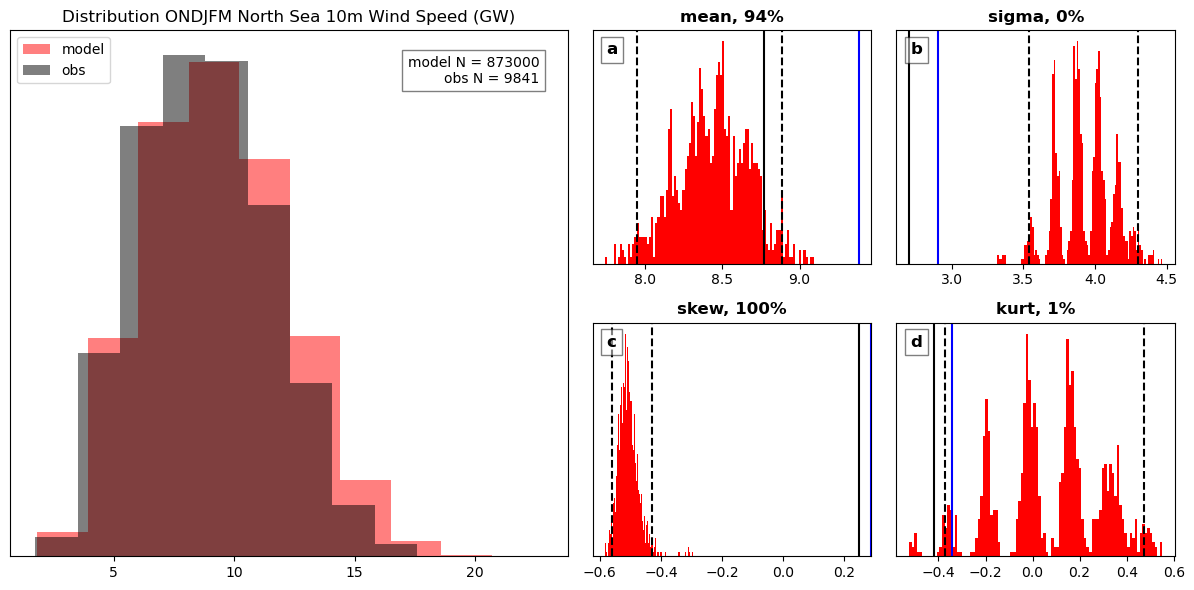

In [86]:
# do the same but for the north sea
func.plot_distributions_fidelity(
    obs_df=df_obs_sfcWind_ns,
    model_df=df_model_ondjfm_ns,
    model_val_name="data",
    obs_val_name="data",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="winter_year",
    title="Distribution ONDJFM North Sea 10m Wind Speed (GW)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="North_Sea_10m_wind_speed_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [74]:
# print the unique effective dec years in df_obs_ns
df_obs_sfcWind_ns["effective_dec_year"].unique()

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013])

In [75]:
# print the unique effective dec years in canari
df_canari_north_sea_daily_ondjfm.columns

Index(['date', 'member', 'sfcWind_u', 'sfcWind_v', 'sfcWind',
       'effective_dec_year'],
      dtype='object')

In [73]:
# subset df_obs_sfcWind_ns to 1960 to 2013 (inclusive)
# to be inline with canari
df_obs_sfcWind_ns = df_obs_sfcWind_ns[
    df_obs_sfcWind_ns["effective_dec_year"].between(1960, 2013)
]

Now perform fidelity testing

the number of unique winters is:  54
the unique times are:  [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
Number of days in a model winter: 180
Number of days to resample for: 9720


Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:23<00:00, 42.16it/s]


(1000,)
shape of obs df obs_val_name:  (9841,)
Obs stats: 
{'mean': np.float64(8.769760214205872), 'sigma': np.float64(2.7013283516807847), 'skew': np.float64(0.24715394961025483), 'kurt': np.float64(-0.4189805032081808)}
Model stats full: 
{'mean': np.float64(8.120483520972849), 'sigma': np.float64(3.161610908511617), 'skew': np.float64(0.20951965911303727), 'kurt': np.float64(-0.4241513734710658)}


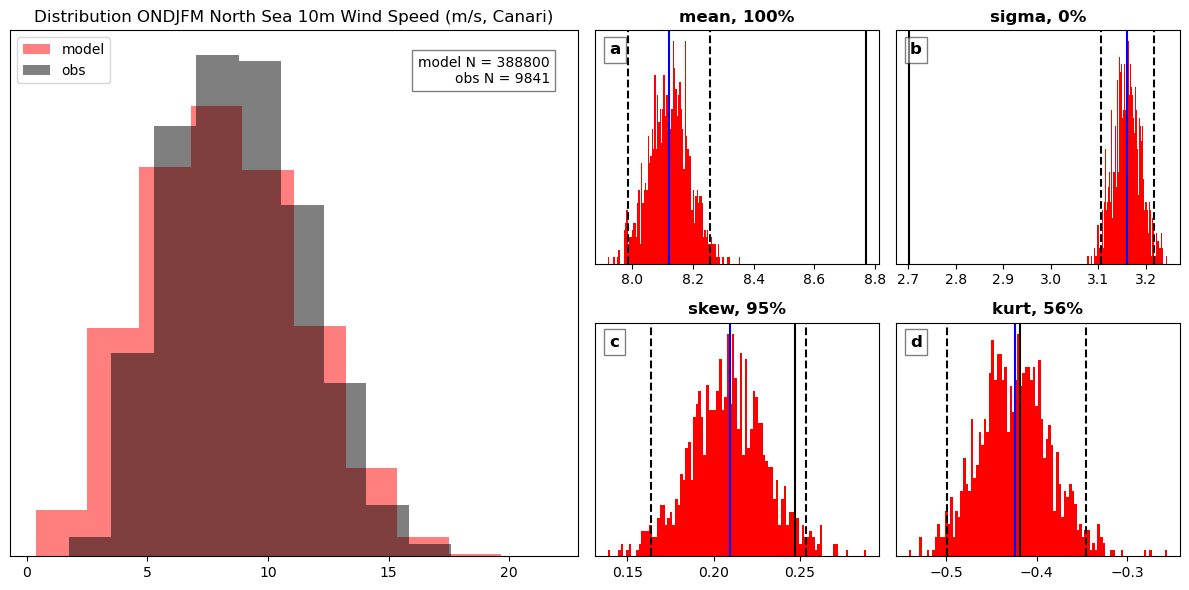

In [76]:
# do the same but for the north sea
func.plot_distributions_fidelity(
    obs_df=df_obs_sfcWind_ns,
    model_df=df_canari_north_sea_daily_ondjfm,
    model_val_name="sfcWind",
    obs_val_name="data",
    obs_time_name="effective_dec_year",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name=None,
    title="Distribution ONDJFM North Sea 10m Wind Speed (m/s, Canari)",
    nboot=1000,
    figsize=(12, 6),
    fname_prefix="North_Sea_10m_wind_speed_ONDJFM_fidelity_canari",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now fit the sigmoid

In [89]:
df_ch.head()

date  solar_power  100m_wind_speed  10m_wind_speed  solar_irradiance  \
0  1960-01-01     0.017302         7.625868        5.137020         47.696808   
1  1960-01-02     0.016300         4.930154        3.186221         44.535210   
2  1960-01-03     0.014511         7.249626        4.753627         39.765705   
3  1960-01-04     0.016632         9.558028        6.228839         46.044937   
4  1960-01-05     0.026247         8.874397        6.005377         71.949350   

    ofs_cfs   ons_cfs  t2m_no_detrend  t2m_2020_detrend  \
0  0.766016  0.298726        6.577980          7.835584   
1  0.161353  0.101100        3.956466          5.214012   
2  0.298246  0.266276        5.730921          6.988410   
3  0.526643  0.363619        7.894082          9.151514   
4  0.798906  0.376032        5.362875          6.620249   

   United_Kingdom_demand  United_Kingdom_wd_demand   wind_gen  \
0              40.766836                 41.666578  15.744187   
1              40.019199                 43.863111   3.883881   
2              37.949476                 42.640292   8.359369   
3              39.775870                 40.584140  13.176714   
4              42.761398                 42.761398  17.378747   

   demand_net_wind  wd_demand_net_wind  offshore_generation  
0        25.022648           25.922391            11.303329  
1        36.135318           39.979230             2.380931  
2        29.590107           34.280923             4.400911  
3        26.599156           27.407426             7.771149  
4        25.382651           25.382651            11.788657

In [88]:
installed_ofs_2023 = 14.756  # GW

# set up a new column in df_ch for the offshore generation
df_ch["offshore_generation"] = df_ch["ofs_cfs"] * installed_ofs_2023

In [93]:
# limit df_ch to the same dates as df_obs_sfcWind_uk
df_ch = df_ch[
    df_ch["date"].between(
        df_obs_sfcWind_uk["time"].min().strftime("%Y-%m-%d"),
        df_obs_sfcWind_uk["time"].max().strftime("%Y-%m-%d"),
    )
]

In [94]:
# Set up an initial guess for the parameters based on the observed data
p0 = [
    max(df_ch["wind_gen"]),
    np.median(df_obs_sfcWind_uk["data"]),
    1,
    min(df_ch["wind_gen"]),
]

# Fit the sigmoid curve to the data
popt, pcov = curve_fit(
    sigmoid, df_obs_sfcWind_uk["data"], df_ch["wind_gen"], p0=p0, method="dogbox"
)

Density range: 0.0 to 0.05668307932312077
Contour interval: 0.01889435977437359


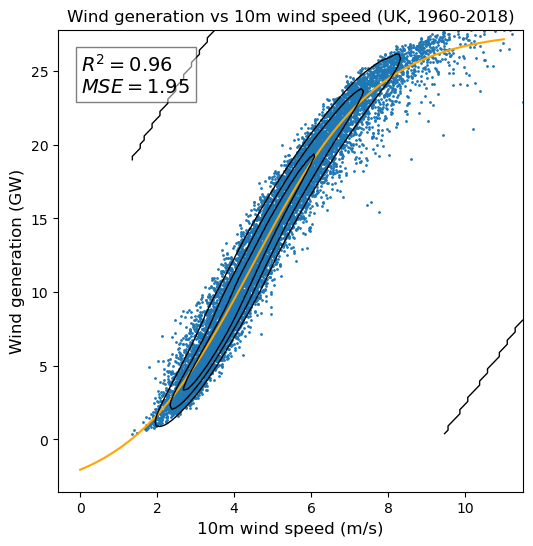

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error


# Assuming sigmoid and popt are already defined
# Define the sigmoid function if not already defined
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b


# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind_uk["data"], df_ch["wind_gen"], s=1)

# Plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_sfcWind_uk["data"])), 100)
ax.plot(
    x,
    sigmoid(x, *popt),
    "r-",
    label="fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f" % tuple(popt),
    color="orange",
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind_uk["data"], df_ch["wind_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_sfcWind_uk["data"].min(), df_obs_sfcWind_uk["data"].max()
ymin, ymax = df_ch["wind_gen"].min(), df_ch["wind_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch["wind_gen"], sigmoid(df_obs_sfcWind_uk["data"], *popt))

# Calculate the mean squared error
mse = mean_squared_error(df_ch["wind_gen"], sigmoid(df_obs_sfcWind_uk["data"], *popt))

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("10m wind speed (m/s)", fontsize=12)
ax.set_ylabel("Wind generation (GW)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

In [100]:
# limit the df_ch to the same dates as df_obs_sfcWind_ns
df_ch_ns = df_ch[
    df_ch["date"].between(
        df_obs_sfcWind_ns["time"].min().strftime("%Y-%m-%d"),
        df_obs_sfcWind_ns["time"].max().strftime("%Y-%m-%d"),
    )
]

In [103]:
df_ch_ns.tail()

date  solar_power  100m_wind_speed  10m_wind_speed  \
9927  2014-03-27     0.142803         7.150202        5.005030   
9928  2014-03-28     0.114444         7.307439        5.048453   
9929  2014-03-29     0.132387         8.366550        5.619438   
9930  2014-03-30     0.143641         6.918531        4.578981   
9931  2014-03-31     0.139653         5.884430        4.025882   

      solar_irradiance   ofs_cfs   ons_cfs  t2m_no_detrend  t2m_2020_detrend  \
9927         252.61443  0.401234  0.330437        5.152052          5.272882   
9928         203.07706  0.463009  0.398713        5.853786          5.974557   
9929         238.06123  0.645220  0.415594        8.081070          8.201785   
9930         258.52603  0.471834  0.277104        8.753799          8.874455   
9931         234.20345  0.244377  0.166510        8.759690          8.880290   

      United_Kingdom_demand  United_Kingdom_wd_demand   wind_gen  \
9927              43.103122                 43.103122  10.832894   
9928              41.476010                 42.375753  12.759432   
9929              36.521775                 40.365687  15.699086   
9930              35.002102                 39.692918  11.081807   
9931              38.845785                 39.654055   6.081364   

      demand_net_wind  wd_demand_net_wind  offshore_generation  
9927        32.270229           32.270229             5.920614  
9928        28.716578           29.616321             6.832166  
9929        20.822689           24.666600             9.520860  
9930        23.920295           28.611111             6.962380  
9931        32.764421           33.572691             3.606033

In [104]:
df_obs_sfcWind_ns["time"].min().strftime("%Y-%m-%d")

'1960-10-01'

In [106]:
df_obs_sfcWind_ns["time"].max().strftime("%Y-%m-%d")

'2014-03-31'

In [110]:
df_ch_ns["date"].min()

Timestamp('1961-10-01 00:00:00')

In [109]:
# Convert the date columns to datetime if they are not already
df_obs_sfcWind_ns['time'] = pd.to_datetime(df_obs_sfcWind_ns['time'])
df_ch_ns['date'] = pd.to_datetime(df_ch_ns['date'])

# Find the unique dates in both dataframes
dates_obs = set(df_obs_sfcWind_ns['time'].unique())
dates_ch = set(df_ch_ns['date'].unique())

# Find the missing dates in each dataframe
missing_in_obs = dates_ch - dates_obs
missing_in_ch = dates_obs - dates_ch

print("Dates missing in df_obs_sfcWind_ns:", missing_in_obs)
print("Dates missing in df_ch_ns:", missing_in_ch)

Dates missing in df_obs_sfcWind_ns: set()
Dates missing in df_ch_ns: {Timestamp('1960-12-31 00:00:00'), Timestamp('1961-01-25 00:00:00'), Timestamp('1960-12-02 00:00:00'), Timestamp('1961-02-27 00:00:00'), Timestamp('1961-03-04 00:00:00'), Timestamp('1961-02-28 00:00:00'), Timestamp('1960-11-09 00:00:00'), Timestamp('1961-02-17 00:00:00'), Timestamp('1961-02-06 00:00:00'), Timestamp('1961-01-04 00:00:00'), Timestamp('1961-01-14 00:00:00'), Timestamp('1961-01-11 00:00:00'), Timestamp('1960-12-03 00:00:00'), Timestamp('1961-01-18 00:00:00'), Timestamp('1960-10-26 00:00:00'), Timestamp('1961-02-11 00:00:00'), Timestamp('1961-01-23 00:00:00'), Timestamp('1961-01-24 00:00:00'), Timestamp('1960-11-15 00:00:00'), Timestamp('1960-11-03 00:00:00'), Timestamp('1961-01-12 00:00:00'), Timestamp('1961-03-19 00:00:00'), Timestamp('1960-10-12 00:00:00'), Timestamp('1961-02-03 00:00:00'), Timestamp('1960-11-28 00:00:00'), Timestamp('1961-01-02 00:00:00'), Timestamp('1960-10-25 00:00:00'), Timestamp('1

In [111]:
# subset df_obs_sfcWind_ns to the same dates as df_ch_ns
df_obs_sfcWind_ns = df_obs_sfcWind_ns[
    df_obs_sfcWind_ns["time"].between(
        df_ch_ns["date"].min(),
        df_ch_ns["date"].max(),
    )
]

In [112]:
# now perform the curve fitting for the north sea
# Set up an initial guess for the parameters based on the observed data
p0 = [
    max(df_ch_ns["offshore_generation"]),
    np.median(df_obs_sfcWind_ns["data"]),
    1,
    min(df_ch_ns["offshore_generation"]),
]

# Fit the sigmoid curve to the data
popt, pcov = curve_fit(
    sigmoid, df_obs_sfcWind_ns["data"], df_ch_ns["offshore_generation"], p0=p0, method="dogbox"
)

Density range: 1.961227659396157e-69 to 0.021120385432760635
Contour interval: 0.0070401284775868786


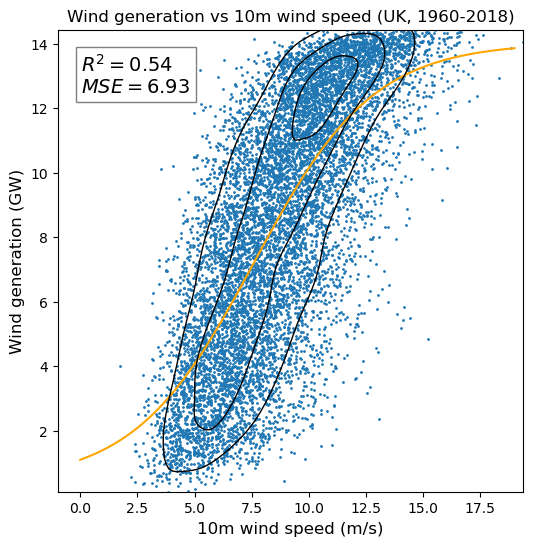

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error


# Assuming sigmoid and popt are already defined
# Define the sigmoid function if not already defined
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind_ns["data"], df_ch_ns["offshore_generation"], s=1)

# Plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_sfcWind_ns["data"])), 100)
ax.plot(
    x,
    sigmoid(x, *popt),
    "r-",
    label="fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f" % tuple(popt),
    color="orange",
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind_ns["data"], df_ch_ns["offshore_generation"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_sfcWind_ns["data"].min(), df_obs_sfcWind_ns["data"].max()
ymin, ymax = df_ch_ns["offshore_generation"].min(), df_ch_ns["offshore_generation"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch_ns["offshore_generation"], sigmoid(df_obs_sfcWind_ns["data"], *popt))

# Calculate the mean squared error
mse = mean_squared_error(df_ch_ns["offshore_generation"], sigmoid(df_obs_sfcWind_ns["data"], *popt))

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("10m wind speed (m/s)", fontsize=12)
ax.set_ylabel("Wind generation (GW)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

Fit looks good. Now we want to evaluate the performance of the converted model wind generation in terms of statistics.

In [12]:
# First create a column in the obs using the sigmoid function
df_obs_sfcWind["wind_gen_sigmoid"] = sigmoid(df_obs_sfcWind["data"], *popt)

Density range: 0.0 to 0.013703024744784043
Contour interval: 0.004567674914928014


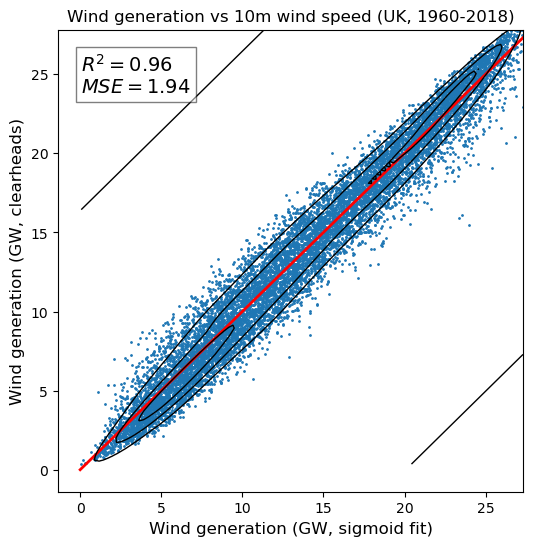

In [13]:
# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind["wind_gen_sigmoid"], df_ch["wind_gen"], s=1)

# plot the 1:1 line as a solid black line
ax.plot(
    [0, max(df_obs_sfcWind["wind_gen_sigmoid"])],
    [0, max(df_obs_sfcWind["wind_gen_sigmoid"])],
    color="red",
    linestyle="-",
    linewidth=2,
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind["wind_gen_sigmoid"], df_ch["wind_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = (
    df_obs_sfcWind["wind_gen_sigmoid"].min(),
    df_obs_sfcWind["wind_gen_sigmoid"].max(),
)
ymin, ymax = df_ch["wind_gen"].min(), df_ch["wind_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch["wind_gen"], df_obs_sfcWind["wind_gen_sigmoid"])

# Calculate the mean squared error
mse = mean_squared_error(df_ch["wind_gen"], df_obs_sfcWind["wind_gen_sigmoid"])

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("Wind generation (GW, sigmoid fit)", fontsize=12)
ax.set_ylabel("Wind generation (GW, clearheads)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

Sigmoid fit does a pretty good job of replicating the clearheads wind generation, albeit with +- 2/3 GW of uncertainty.

Now apply the same sigmoid fit to the model 10m wind speed data.

In [14]:
df_model_ondjfm_sfcWind = df_model_ondjfm.copy()

In [15]:
df_model_ondjfm_sfcWind.shape

(1062000, 4)

In [16]:
df_obs_sfcWind.columns

Index(['time', 'data', 'wind_gen_sigmoid'], dtype='object')

In [17]:
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
# Apply the function to the obs data
df_obs_sfcWind["effective_dec_year"] = df_obs_sfcWind.apply(
    determine_effective_dec_year, axis=1
)

In [20]:
df_model_ondjfm_wyear.head()

init_year  member  lead      data  winter_year
330       1960       1   331  4.469876            1
331       1960       1   332  5.489894            1
332       1960       1   333  6.172364            1
333       1960       1   334  4.134217            1
334       1960       1   335  4.603901            1

In [19]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm_sfcWind[df_model_ondjfm_sfcWind["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

Check the fidelity testing for sfcWind relative to our observed sfcWind.

In [22]:
df_obs_sfcWind.head()

time      data  wind_gen_sigmoid  effective_dec_year
0 1960-01-01  5.291350         15.742722                1959
1 1960-01-02  2.538070          3.372730                1959
2 1960-01-03  3.692958          8.085504                1959
3 1960-01-04  4.943725         14.107607                1959
4 1960-01-05  5.288300         15.728691                1959

In [23]:
df_model_ondjfm_wyear.head()

init_year  member  lead      data  winter_year
330       1960       1   331  4.469876            1
331       1960       1   332  5.489894            1
332       1960       1   333  6.172364            1
333       1960       1   334  4.134217            1
334       1960       1   335  4.603901            1

the number of unique winters is:  60
Number of days in a model winter: 180
Number of days to resample for: 10800


Calculating bootstrap statistics: 100%|██████████| 1000/1000 [01:35<00:00, 10.43it/s]


(1000,)


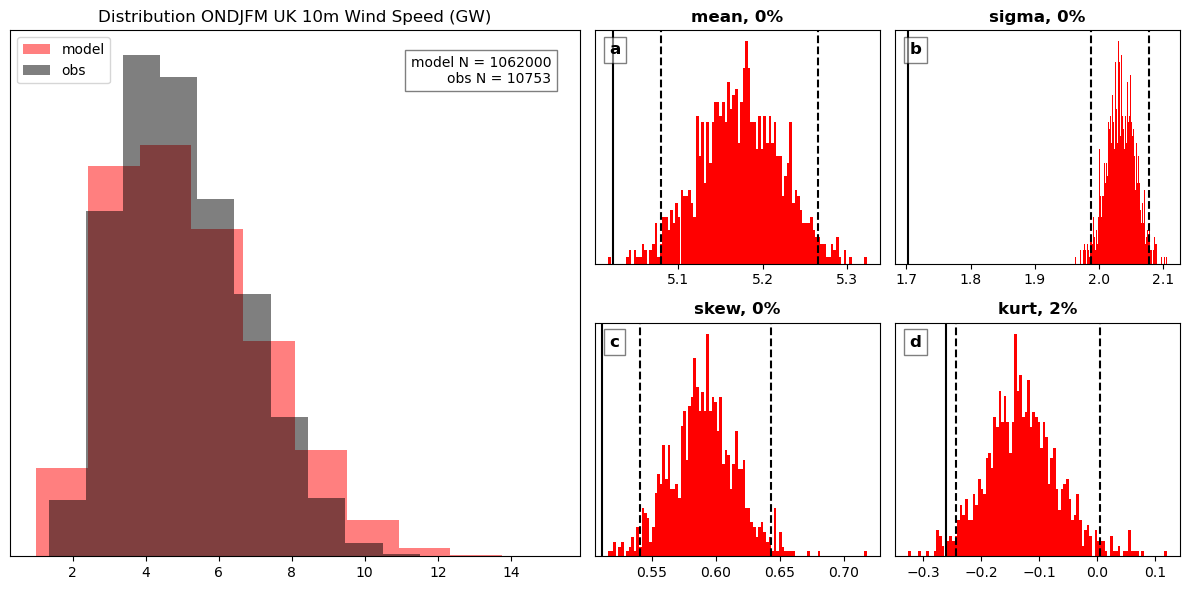

In [21]:
plot_distributions_fidelity(
    obs_df=df_obs_sfcWind,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data",
    model_val_name="data",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="winter_year",
    title="Distribution ONDJFM UK 10m Wind Speed (GW)",
    nboot=1000, # For checking purposes
    figsize=(12, 6),
    fname_prefix="UK_10m_wind_speed_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Model 10m wind speed is overspread and biased high in the mean, so we want to correct this.

In [18]:
from functions import bc_linear_scaling

# # Correct the variance and mean
# df_model_ondjfm_sfcWind = bc_linear_scaling(
#     obs_df=df_obs_sfcWind,
#     model_df=df_model_ondjfm_sfcWind,
#     obs_val_name="data",
#     model_val_name="data",
# )

Calculating bootstrap statistics:  26%|██▌       | 26/100 [00:02<00:06, 11.67it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


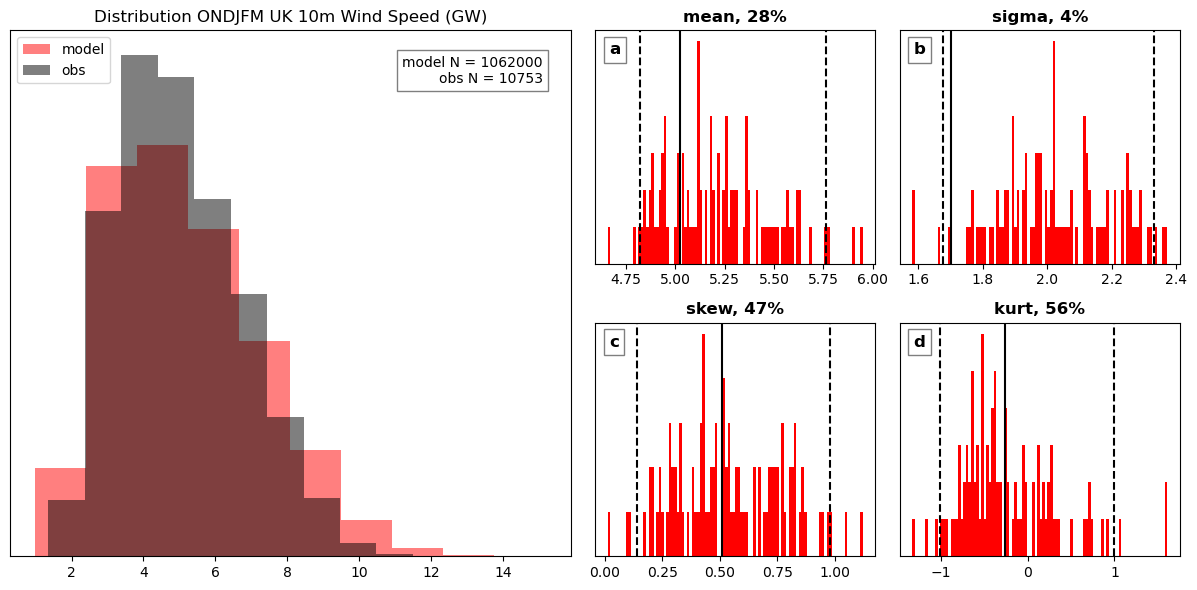

In [19]:
plot_distributions_fidelity(
    obs_df=df_obs_sfcWind,
    model_df=df_model_ondjfm_sfcWind,
    obs_val_name="data",
    model_val_name="data",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK 10m Wind Speed (GW)",
    nboot=100, # For checking purposes
    figsize=(12, 6),
    fname_prefix="UK_10m_wind_speed_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Mean and spread much closer to the observed value. Now we can move on to the next step, which is to apply the sigmoid function to the model data.

In [20]:
df_model_ondjfm_sfcWind["wind_gen_sigmoid"] = sigmoid(
    df_model_ondjfm_sfcWind["data"], *popt
)

Calculating bootstrap statistics:   2%|▏         | 2/100 [00:00<00:08, 11.51it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:08<00:00, 11.84it/s]


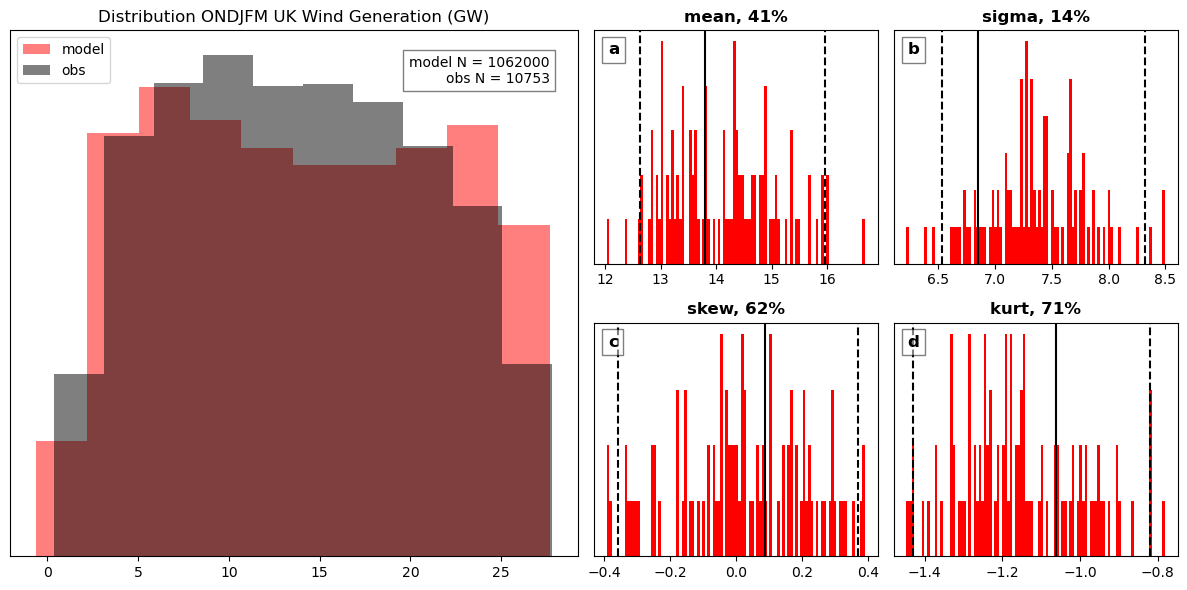

In [21]:
# Compare the wind generation distribution from the model and the obs
plot_distributions_fidelity(
    obs_df=df_ch,
    model_df=df_model_ondjfm_sfcWind,
    obs_val_name="wind_gen", # CLEARHEADS ground-truth
    model_val_name="wind_gen_sigmoid", # 10m wind speed sigmoid fit
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK Wind Generation (GW)",
    nboot=100,
    figsize=(12, 6),
    fname_prefix="UK_wind_generation_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Spread correction has fixed the bimodal model distribution. Obs and model distributions appear much more realistic

### Temperature -> demand ###

Do the conversion from temperature to demand.

In [22]:
# load the model data
df_model_tas = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv"
)

# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

# add a new column for temp c in the model data
df_model_ondjfm_wyear["data_c"] = df_model_ondjfm_wyear["data"] - 273.15

# create a new column in df_model_ondjfm_wyear - effective_dec_year
df_model_ondjfm_wyear["effective_dec_year"] = (
    df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]
)

# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([10, 11, 12, 1, 2, 3])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [23]:
# Ensure time is a datetime object
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"])

# Set time as the index
df_obs_tas.set_index("time", inplace=True)

df_obs_tas.head()

data    data_c
time                            
1960-01-01  280.004414  6.854414
1960-01-02  276.900436  3.750436
1960-01-03  278.757843  5.607843
1960-01-04  281.210861  8.060861
1960-01-05  278.524161  5.374161

In [24]:
%%time

# Apply the detrend function to the data
df_model_tas, df_obs_tas = apply_detrend_rolling(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name="lead",
    window_years=10,
    centered=True,
    min_periods=1,
)

(10753,)
obs slope  0.029402536911068346
obs intercept  -52.7402047343747
(10753,)
CPU times: user 48 ms, sys: 9.95 ms, total: 57.9 ms
Wall time: 57.7 ms


Look at the distributions for temperature.

Calculating bootstrap statistics:   2%|▏         | 2/100 [00:00<00:09, 10.46it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


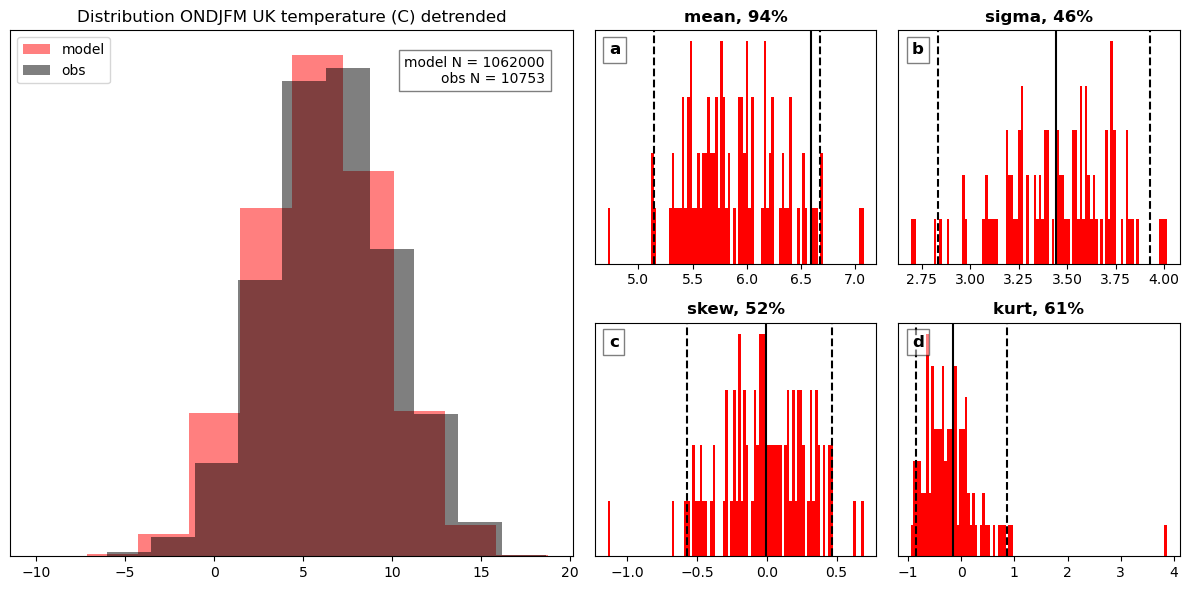

In [25]:
# Validate the detrended temperature
plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="data_c_dt",
    model_val_name="data_c_dt",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK temperature (C) detrended",
    nboot=100,
    figsize=(12, 6),
    fname_prefix="UK_detr_temp_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Would benefit from a mean correction prior to demand conversion.

In [26]:
from functions import bc_linear_scaling

# Apply the bias correction
df_model_tas = bc_linear_scaling(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="data_c_dt",
    model_val_name="data_c_dt",
)

Calculating bootstrap statistics:   6%|▌         | 6/100 [00:00<00:08, 11.24it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:08<00:00, 11.43it/s]


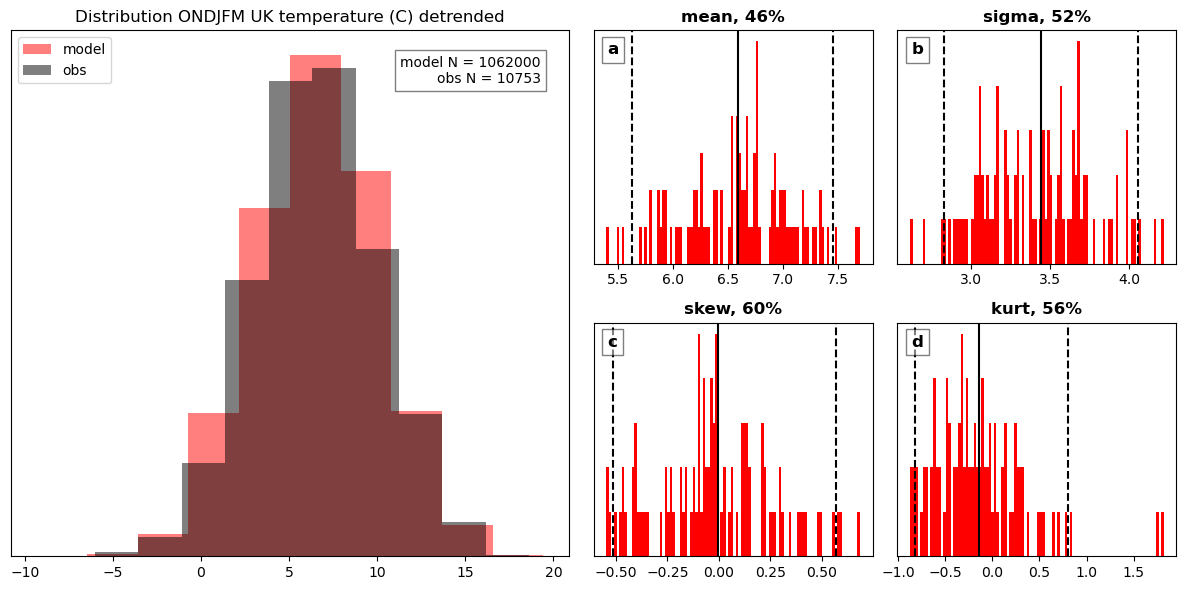

In [27]:
# Validate the detrended temperature
plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="data_c_dt",
    model_val_name="data_c_dt_bc", # Mean bias corrected data
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK temperature (C) detrended",
    nboot=100,
    figsize=(12, 6),
    fname_prefix="UK_detr_temp_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [28]:
df_model_tas.columns

Index(['init_year', 'member', 'lead', 'data', 'winter_year', 'data_c',
       'effective_dec_year', 'data_c_dt', 'data_c_dt_bc'],
      dtype='object')

Now convert to demand through HDD, CDD, and the regression relationships.

In [29]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas["hdd_dt"] = df_obs_tas["data_c_dt"].apply(lambda x: max(0, hdd_base - x))
df_obs_tas["cdd_dt"] = df_obs_tas["data_c_dt"].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas["hdd_dt"] = df_model_tas["data_c_dt_bc"].apply(lambda x: max(0, hdd_base - x))
df_model_tas["cdd_dt"] = df_model_tas["data_c_dt_bc"].apply(lambda x: max(0, x - cdd_base))

In [30]:
# Set up the path to the regression coeffs
regr_coeffs = (
    "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"
)

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand detrended
df_obs_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017)  # demand year which the model is based on
    + (hdd_coeff_uk * df_obs_tas["hdd_dt"])
    + (cdd_coeff_uk * df_obs_tas["cdd_dt"])
)

# Calculate the model demand detrended
df_model_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017)  # demand year which the model is based on
    + (hdd_coeff_uk * df_model_tas["hdd_dt"])
    + (cdd_coeff_uk * df_model_tas["cdd_dt"])
)

Calculating bootstrap statistics:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


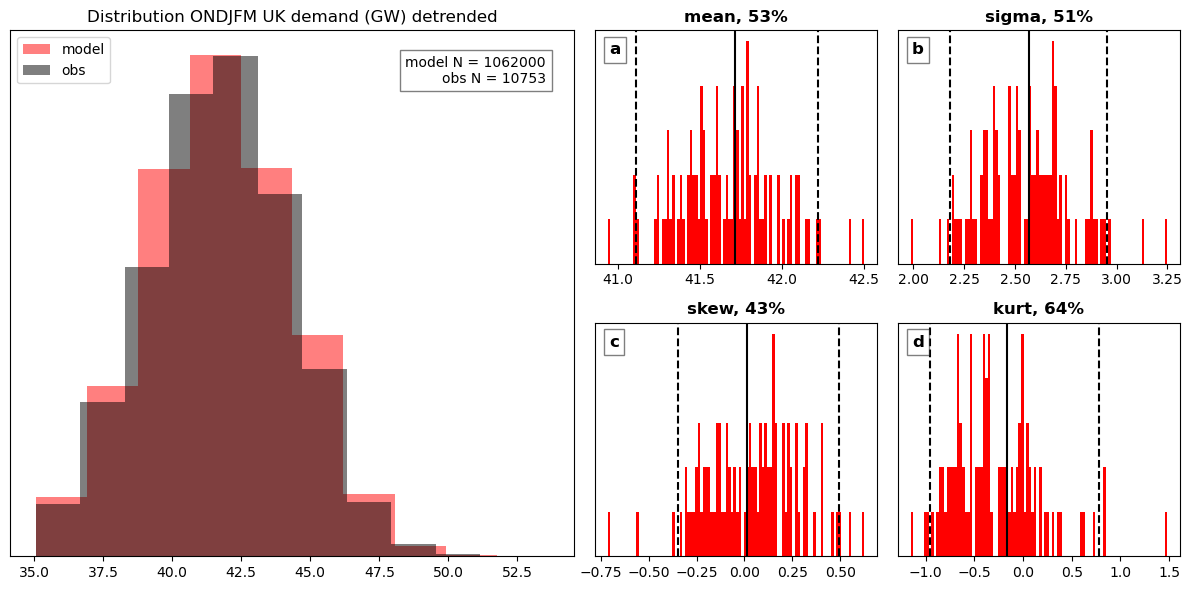

In [31]:
# Now validate the UK demand against the observed data
plot_distributions_fidelity(
    obs_df=df_obs_tas,
    model_df=df_model_tas,
    obs_val_name="UK_demand_dt",
    model_val_name="UK_demand_dt",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK demand (GW) detrended",
    nboot=100,
    figsize=(12, 6),
    fname_prefix="UK_detr_demand_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Looks similar before, but now detrend of obs still preserves cold 1960s.

### Demand net wind ###

Now merge the dataframes to look at the demand net wind.

In [32]:
# merge the obs data
df_obs = df_obs_sfcWind.merge(df_obs_tas, on="time", how="inner")

In [33]:
# rename data_x as "10m_wind_speed" and data_y as "temp_K"
df_obs.rename(columns={"data_x": "10m_wind_speed", "data_y": "temp_K"}, inplace=True)

In [34]:
df_model_ondjfm_sfcWind.head()

init_year  member  lead      data  wind_gen_sigmoid
330       1960       1   331  4.469876         11.806168
331       1960       1   332  5.489894         16.641298
332       1960       1   333  6.172364         19.457478
333       1960       1   334  4.134217         10.172521
334       1960       1   335  4.603901         12.460984

In [35]:
df_model_ondjfm_sfcWind.rename(columns={"data": "10m_wind_speed"}, inplace=True)
df_model_tas.rename(columns={"data": "temp_K"}, inplace=True)

In [36]:
# Merge the model data on "init_year", "lead", and "member"
df_model = df_model_ondjfm_sfcWind.merge(
    df_model_tas, on=["init_year", "lead", "member"], how="inner"
)

In [37]:
df_ch.head()

date  solar_power  100m_wind_speed  10m_wind_speed  solar_irradiance  \
0  1960-01-01     0.017302         7.625868        5.137020         47.696808   
1  1960-01-02     0.016300         4.930154        3.186221         44.535210   
2  1960-01-03     0.014511         7.249626        4.753627         39.765705   
3  1960-01-04     0.016632         9.558028        6.228839         46.044937   
4  1960-01-05     0.026247         8.874397        6.005377         71.949350   

    ofs_cfs   ons_cfs  t2m_no_detrend  t2m_2020_detrend  \
0  0.766016  0.298726        6.577980          7.835584   
1  0.161353  0.101100        3.956466          5.214012   
2  0.298246  0.266276        5.730921          6.988410   
3  0.526643  0.363619        7.894082          9.151514   
4  0.798906  0.376032        5.362875          6.620249   

   United_Kingdom_demand  United_Kingdom_wd_demand   wind_gen  \
0              40.766836                 41.666578  15.744187   
1              40.019199                 43.863111   3.883881   
2              37.949476                 42.640292   8.359369   
3              39.775870                 40.584140  13.176714   
4              42.761398                 42.761398  17.378747   

   demand_net_wind  wd_demand_net_wind  
0        25.022648           25.922391  
1        36.135318           39.979230  
2        29.590107           34.280923  
3        26.599156           27.407426  
4        25.382651           25.382651

In [38]:
# Calculate the demand_dt_net_wind
df_model["demand_dt_net_wind"] = df_model["UK_demand_dt"] - df_model["wind_gen_sigmoid"]

In [39]:
# Calculate the demand_dt_net_wind for the obs
df_obs["demand_dt_net_wind"] = df_obs["UK_demand_dt"] - df_ch["wind_gen"]

Calculating bootstrap statistics:   6%|▌         | 6/100 [00:00<00:08, 11.05it/s]

Calculating bootstrap statistics: 100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


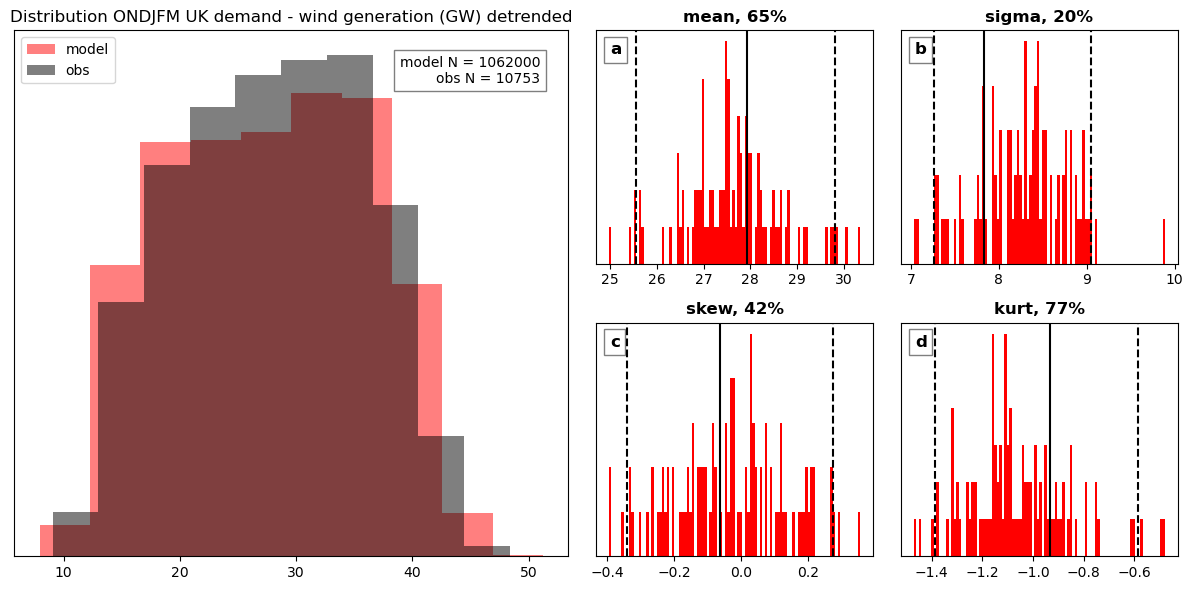

In [40]:
# Compare the demand_dt_net_wind distribution from the model and the obs
plot_distributions_fidelity(
    obs_df=df_obs,
    model_df=df_model,
    obs_val_name="demand_dt_net_wind",  # Empirical demand - CH wind generation
    model_val_name="demand_dt_net_wind",
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK demand - wind generation (GW) detrended",
    nboot=100,
    figsize=(12, 6),
    fname_prefix="UK_detr_demand_net_wind_ONDJFM_fidelity",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Looks pretty good! No bias correction needed either!!

Now do the conversion into the number of exceedance days for the winter to look at the overall severity.

In [41]:
# If time is a column for obs df
df_obs["time"] = pd.to_datetime(df_obs["time"])

# Set time as the index
df_obs.set_index("time", inplace=True)

In [42]:
df_obs.columns

Index(['10m_wind_speed', 'wind_gen_sigmoid', 'temp_K', 'data_c', 'data_c_dt',
       'hdd_dt', 'cdd_dt', 'UK_demand_dt', 'demand_dt_net_wind'],
      dtype='object')

In [43]:
df_ch.columns

Index(['date', 'solar_power', '100m_wind_speed', '10m_wind_speed',
       'solar_irradiance', 'ofs_cfs', 'ons_cfs', 't2m_no_detrend',
       't2m_2020_detrend', 'United_Kingdom_demand', 'United_Kingdom_wd_demand',
       'wind_gen', 'demand_net_wind', 'wd_demand_net_wind'],
      dtype='object')

In [44]:
df_ch["date"] = pd.to_datetime(df_ch["date"])

df_ch.set_index("date", inplace=True)

Plot the histograms of wind generation. To decide the obs threshold to use for wind drought days.

Central 95th percentile: 2.4498330207156 to 25.92396703464
95th percentile obs: 23.4741340139244


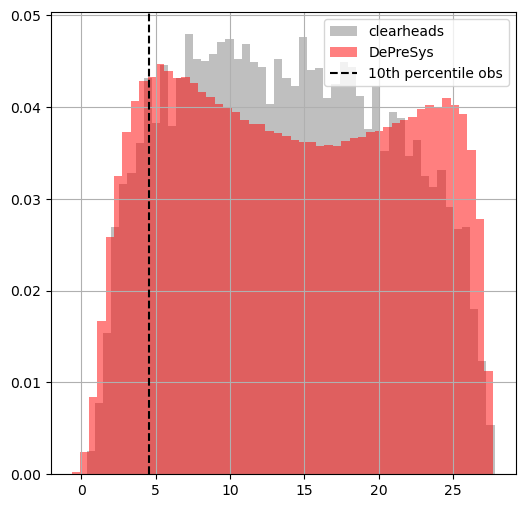

In [45]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the wind generation clearheads
df_ch["wind_gen"].hist(
    bins=50, ax=ax, alpha=0.5, label="clearheads", color="gray", density=True
)

# Plot a histogram of the wind generation obs
df_model["wind_gen_sigmoid"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# # plot the mean of the clearheads
# ax.axvline(df_ch["wind_gen"].mean(), color="black", linestyle="--", label="clearheads mean")

# # plot the mean of the obs
# ax.axvline(
#     df_model["wind_gen_sigmoid"].mean(), color="red", linestyle="--", label="DePreSys mean"
# )

# # plot a horizontal line for the 10th percentile of the obs
ax.axvline(
    df_ch["wind_gen"].quantile(0.10),
    color="black",
    linestyle="--",
    label="10th percentile obs",
)

# print the central 95th percentile
print(f"Central 95th percentile: {df_ch['wind_gen'].quantile(0.025)} to {df_ch['wind_gen'].quantile(0.975)}")

# print the difference between the 2.5th and 97.5th percentiles
print(f"95th percentile obs: {df_ch['wind_gen'].quantile(0.975) - df_ch['wind_gen'].quantile(0.025)}")

# include a legend
ax.legend()

2.5th percentile obs: 13.866298628207893
97.5th percentile obs: 41.53810898567864
95% confidence interval: 27.671810357470747


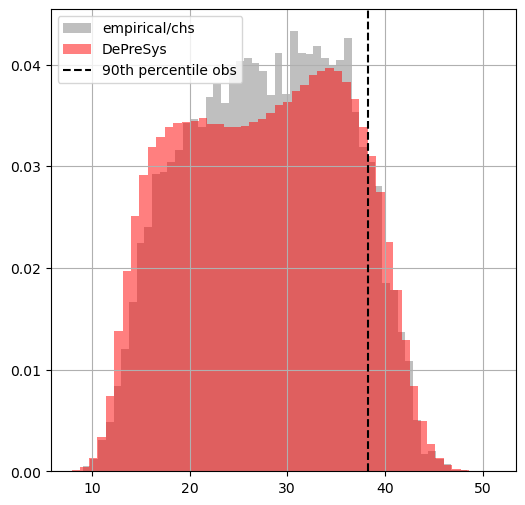

In [46]:
# Plot the distribution of the detrended demand - wind generation
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["demand_dt_net_wind"].hist(
    bins=50, ax=ax, alpha=0.5, label="empirical/chs", color="gray", density=True
)

# Plot a histogram of the demand net wind
df_model["demand_dt_net_wind"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# # plot the mean of the obs
# ax.axvline(df_obs["demand_dt_net_wind"].mean(), color="black", linestyle="--", label="mean obs")

# # plot the mean of the model
# ax.axvline(df_model["demand_dt_net_wind"].mean(), color="black", linestyle="-", label="mean model")

# # plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_obs["demand_dt_net_wind"].quantile(0.90),
    color="black",
    linestyle="--",
    label="90th percentile obs",
)

# print the 2.5th percentile of the obs
print(f"2.5th percentile obs: {df_obs['demand_dt_net_wind'].quantile(0.025)}")

# print the 97.5th percentile of the obs
print(f"97.5th percentile obs: {df_obs['demand_dt_net_wind'].quantile(0.975)}")

# take the difference between these two
print(
    f"95% confidence interval: {df_obs['demand_dt_net_wind'].quantile(0.975) - df_obs['demand_dt_net_wind'].quantile(0.025)}"
)

# include a legend in the top left
ax.legend(loc="upper left")

Central 95th percentile: 36.65643091128481 to 46.67479161033694
95th percentile obs: 10.018360699052131


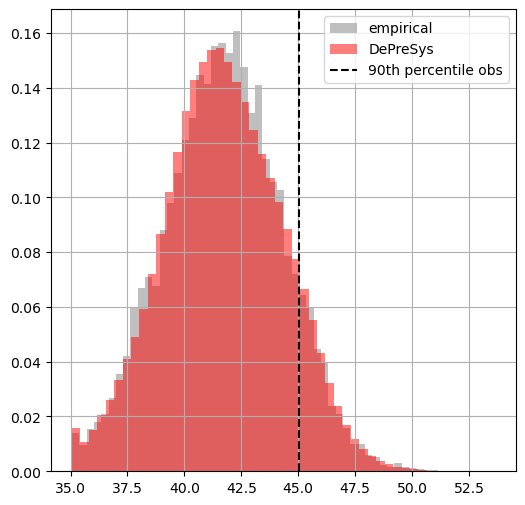

In [47]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["UK_demand_dt"].hist(
    bins=50, ax=ax, alpha=0.5, label="empirical", color="gray", density=True
)

# Plot a histogram of the demand net wind
df_model["UK_demand_dt"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# # plot the mean of the obs
# ax.axvline(df_obs["UK_demand_dt"].mean(), color="black", linestyle="--", label="mean obs")

# # plot the mean of the model
# ax.axvline(
#     df_model["UK_demand_dt"].mean(), color="black", linestyle="-", label="mean model"
# )

# # plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_obs["UK_demand_dt"].quantile(0.90),
    color="black",
    linestyle="--",
    label="90th percentile obs",
)

# print the range of the central 95th percentile
print(f"Central 95th percentile: {df_obs['UK_demand_dt'].quantile(0.025)} to {df_obs['UK_demand_dt'].quantile(0.975)}")

# print the difference between the 2.5th and 97.5th percentiles
print(f"95th percentile obs: {df_obs['UK_demand_dt'].quantile(0.975) - df_obs['UK_demand_dt'].quantile(0.025)}")

# include a legend in the top left
ax.legend(loc="upper right")

In [114]:
# First bias correct the mean of the DePreSys model data for the UK
from functions import bc_linear_scaling

# Correct the mean
# # Correct the mean
df_model_ondjfm_uk_bc = bc_linear_scaling(
    obs_df=df_obs_sfcWind_uk,
    model_df=df_model_ondjfm_uk,
    obs_val_name="data",
    model_val_name="data",
)

# same for the north sea depresys data
df_model_ondjfm_ns_bc = bc_linear_scaling(
    obs_df=df_obs_sfcWind_ns,
    model_df=df_model_ondjfm_ns,
    obs_val_name="data",
    model_val_name="data",
)

# same for the north sea canari data
df_model_ondjfm_ns_canari_bc = bc_linear_scaling(
    obs_df=df_obs_sfcWind_ns,
    model_df=df_canari_north_sea_daily_ondjfm,
    obs_val_name="data",
    model_val_name="sfcWind",
)


In [115]:
df_model_ondjfm_uk_bc.columns

Index(['init_year', 'member', 'lead', 'data', 'winter_year',
       'effective_dec_year', 'data_bc'],
      dtype='object')

Central 95th percentile: 2.3616663301473158 to 8.742772669126003
95th percentile obs: 6.381106338978688


Text(0.5, 1.0, 'Distribution of daily 10m wind speed UK (ONDJFM, DePreSys)')

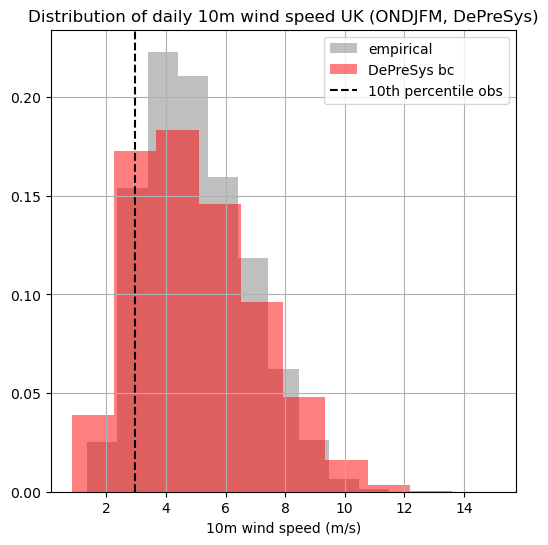

In [117]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the observed uk wind speed
df_obs_sfcWind_uk["data"].hist(
    ax=ax, alpha=0.5, label="empirical", color="gray", density=True
)

# Plot a histogram of the model uk wind speed
df_model_ondjfm_uk_bc["data_bc"].hist(
    ax=ax, alpha=0.5, label="DePreSys bc", color="red", density=True
)

# # plot the mean of the obs
# ax.axvline(df_obs["UK_demand_dt"].mean(), color="black", linestyle="--", label="mean obs")

# # plot the mean of the model
# ax.axvline(
#     df_model["UK_demand_dt"].mean(), color="black", linestyle="-", label="mean model"
# )

# # plot a horizontal line for the 10th percentile of the obs
ax.axvline(
    df_obs_sfcWind_uk["data"].quantile(0.10),
    color="black",
    linestyle="--",
    label="10th percentile obs",
)

# # print the range of the central 95th percentile
print(f"Central 95th percentile: {df_obs_sfcWind_uk['data'].quantile(0.025)} to {df_obs_sfcWind_uk['data'].quantile(0.975)}")

# # print the difference between the 2.5th and 97.5th percentiles
print(f"95th percentile obs: {df_obs_sfcWind_uk['data'].quantile(0.975) - df_obs_sfcWind_uk['data'].quantile(0.025)}")

# include a legend in the top left
ax.legend(loc="upper right")

# include an xlabel
ax.set_xlabel("10m wind speed (m/s)")

# include a title
ax.set_title("Distribution of daily 10m wind speed UK (ONDJFM, DePreSys)")

Text(0.5, 1.0, 'Distribution of daily 10m wind speed North Sea (ONDJFM, DePreSys and Canari)')

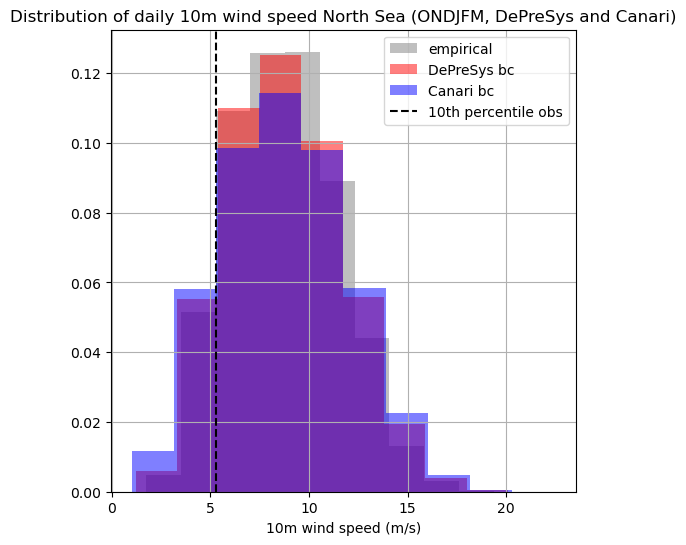

In [118]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the observed north sea wind speed
df_obs_sfcWind_ns["data"].hist(
    ax=ax, alpha=0.5, label="empirical", color="gray", density=True
)

# Plot a histogram of the model north sea wind speed
df_model_ondjfm_ns_bc["data_bc"].hist(
    ax=ax, alpha=0.5, label="DePreSys bc", color="red", density=True
)

# # plot a histogram of the model north sea wind speed
df_model_ondjfm_ns_canari_bc["sfcWind_bc"].hist(
    ax=ax, alpha=0.5, label="Canari bc", color="blue", density=True
)

# # plot the mean of the obs
# ax.axvline(df_obs["UK_demand_dt"].mean(), color="black", linestyle="--", label="mean obs")

# # plot the mean of the model
# ax.axvline(
#     df_model["UK_demand_dt"].mean(), color="black", linestyle="-", label="mean model"
# )

# # plot a horizontal line for the 10th percentile of the obs
ax.axvline(
    df_obs_sfcWind_ns["data"].quantile(0.10),
    color="black",
    linestyle="--",
    label="10th percentile obs",
)

# # # print the range of the central 95th percentile
# print(f"Central 95th percentile: {df_obs_sfcWind_uk['data'].quantile(0.025)} to {df_obs_sfcWind_uk['data'].quantile(0.975)}")

# # # print the difference between the 2.5th and 97.5th percentiles
# print(f"95th percentile obs: {df_obs_sfcWind_uk['data'].quantile(0.975) - df_obs_sfcWind_uk['data'].quantile(0.025)}")

# include a legend in the top left
ax.legend(loc="upper right")

# include an xlabel
ax.set_xlabel("10m wind speed (m/s)")

# include a title
ax.set_title("Distribution of daily 10m wind speed North Sea (ONDJFM, DePreSys and Canari)")

In [49]:
# # add the df_ch[Wind_gen] to the df_obs
# df_obs["wind_gen"] = df_ch["wind_gen"]

Now plot the variation in demand with wind power generation for the obs and model data.

In [50]:
from tqdm import tqdm
import numpy as np
import pandas as pd

# Set up the 1 %tile bins for demand
high_res_percentile = np.arange(1, 100, 0.25)
low_res_percentile = np.arange(1, 100, 5)

# Initialize an empty DataFrame
df_demand_percentiles_high_res = pd.DataFrame()

# Loop over the percentiles
for percentile in tqdm(high_res_percentile):
    # Calculate the threshold of demand
    threshold_obs = df_obs["UK_demand_dt"].quantile(percentile / 100)
    threshold_model = df_model["UK_demand_dt"].quantile(percentile / 100)

    # Subset the df to the days where the demand is above the threshold
    df_demand_percentile_this = df_obs[df_obs["UK_demand_dt"] > threshold_obs]

    # Subset the model to the days where the demand is above the threshold
    df_model_percentile_this = df_model[df_model["UK_demand_dt"] > threshold_model]

    # Set up a new dataframe
    df_this = pd.DataFrame(
        {
            "percentile": [percentile],
            "demand_threshold_obs": [threshold_obs],
            "mean_wind_obs": [df_demand_percentile_this["wind_gen"].mean()],
            "mean_wind_model": [df_model_percentile_this["wind_gen_sigmoid"].mean()],
        }
    )

    # Append to the new dataframe
    df_demand_percentiles_high_res = pd.concat(
        [df_demand_percentiles_high_res, df_this], ignore_index=True
    )

# Print the head of the new dataframe
print(df_demand_percentiles_high_res.head())

100%|██████████| 396/396 [00:10<00:00, 36.97it/s]

   percentile  demand_threshold_obs  mean_wind_obs  mean_wind_model
0        1.00             35.888304      13.786682        14.103682
1        1.25             36.018466      13.779131        14.106310
2        1.50             36.139549      13.778481        14.109193
3        1.75             36.288338      13.773969        14.111043
4        2.00             36.415148      13.775623        14.113183


In [51]:
df_demand_percentiles_high_res.tail()

percentile  demand_threshold_obs  mean_wind_obs  mean_wind_model
391       98.75             47.472873       9.805283         9.602651
392       99.00             47.632610       9.467066         9.267024
393       99.25             47.888045       9.742081         8.882104
394       99.50             48.279670       9.816193         8.382782
395       99.75             49.020141       9.138918         7.454384

In [52]:
# limit the percentiles to those over 90
df_demand_percentiles_high_res = df_demand_percentiles_high_res[
    df_demand_percentiles_high_res["percentile"] >= 90
]

Text(0, 0.5, 'Mean wind generation (GW)')

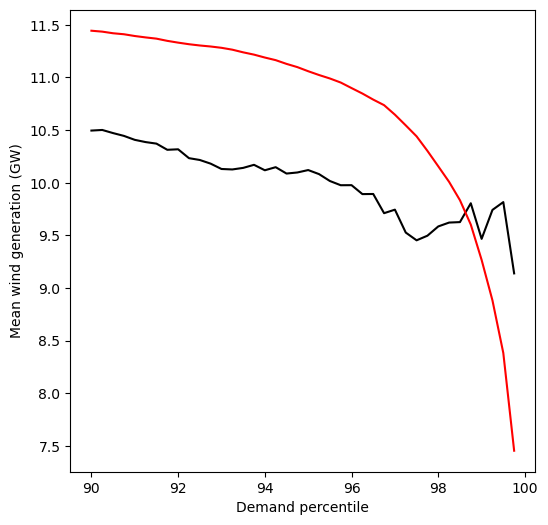

In [53]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# plot the demand percentile on trhe x-axis
ax.plot(
    df_demand_percentiles_high_res["percentile"],
    df_demand_percentiles_high_res["mean_wind_obs"],
    label="obs",
    color="black",
    linestyle="-",
)

# plot the demand percentile on trhe x-axis
ax.plot(
    df_demand_percentiles_high_res["percentile"],
    df_demand_percentiles_high_res["mean_wind_model"],
    label="model",
    color="red",
    linestyle="-",
)

# set the labels
ax.set_xlabel("Demand percentile")

# set the labels
ax.set_ylabel("Mean wind generation (GW)")

12th percentile of wind generation considered as ~5 GW of generation, which is very low/unusual during the winter. Can always test and adjust.

94th percentile of detrended demand net wind ~ 40 GW identified by Ben Sloman at NESO.

87th percentile of detrended demand ~ 45 GW which is high.

In [119]:
df_obs_sfcWind_ns.head()

time      data  effective_dec_year
639 1961-10-01  5.294339                1961
640 1961-10-02  6.969324                1961
641 1961-10-03  8.008130                1961
642 1961-10-04  8.267683                1961
643 1961-10-05  8.166202                1961

In [121]:
# set time as the index
df_obs_sfcWind_uk.set_index("time", inplace=True)

In [123]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.unique(df_obs_sfcWind_uk["effective_dec_year"])

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
no_exceedance_days_demand = []
severity_index_demand = []

# Same for wind speed
no_undershoot_days_wind = []
severity_index_wind = []

# # Same for demand net wind
no_exceedance_days_demand_net_wind = []
severity_index_demand_net_wind = []

# 92 just chosen to be in line with demand net wind
# 87th percentile for demand ~ 45 GW
# all_winters_high_demand = np.percentile(df_obs["UK_demand_dt"], 90)

# 94th percentile for demand net wind ~ 40 GW identified by Ben Sloman as being
# challenging
# all_winters_high_DnW = np.percentile(df_obs["demand_dt_net_wind"], 90)

# 12th percentile of wind generation ~ 5 GW
# Which is pretty low during the winter
# all_winters_low_wind = np.percentile(df_ch["wind_gen"], 10)
all_winters_low_wind_uk = np.percentile(df_obs_sfcWind_uk["data"], 10)
all_winters_low_wind_ns = np.percentile(df_obs_sfcWind_ns["data"], 10)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df_this = df_obs_sfcWind_uk.loc[winter_start:winter_end]
    # df_ch_this = df_ch.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df_this.index:
        print("Dropping 29th Feb")
        df_this = df_this.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    # mask_demand = df["UK_demand_dt"] > all_winters_high_demand
    # mask_DnW = df["demand_dt_net_wind"] > all_winters_high_DnW
    # mask_wind = df_ch_this["wind_gen"] < all_winters_low_wind
    mask_wind_uk = df_this["data"] < all_winters_low_wind_uk

    # # calculate the severity index
    # severity_index_demand_this = (
    #     df["UK_demand_dt"][mask_demand] - all_winters_high_demand
    # ).sum()
    # severity_index_demand_net_wind_this = (
    #     df["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
    # ).sum()
    # severity_index_wind_this = (
    #     all_winters_low_wind - df_ch_this["wind_gen"][mask_wind]
    # ).sum()

    # # append these to the list
    # severity_index_demand.append(severity_index_demand_this)
    # severity_index_demand_net_wind.append(severity_index_demand_net_wind_this)
    # severity_index_wind.append(severity_index_wind_this)

    # calculate the no. exceedance days
    # no_exceedance_days_demand_this = mask_demand.sum()
    # no_exceedance_days_demand_net_wind_this = mask_DnW.sum()
    # no_undershoot_days_wind_this = mask_wind.sum()
    no_low_wind_days_uk = mask_wind_uk.sum()

    # append these to the list
    # no_exceedance_days_demand.append(no_exceedance_days_demand_this)
    # no_exceedance_days_demand_net_wind.append(no_exceedance_days_demand_net_wind_this)
    no_undershoot_days_wind.append(no_low_wind_days_uk)

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "no_undershoot_days_wind": no_undershoot_days_wind,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [124]:
df_exceedance_days_obs_uk = df_exceedance_days_obs.copy()

In [125]:
df_exceedance_days_obs_uk.head()

no_undershoot_days_wind
1961                       27
1962                       29
1963                       22
1964                       25
1965                       21

<Axes: >

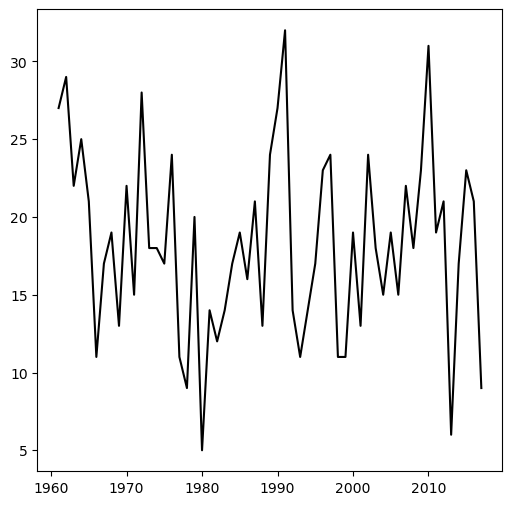

In [126]:
# plot the number of exceedance days
fig, ax = plt.subplots(figsize=(6, 6))

# plot the number of exceedance days
df_exceedance_days_obs_uk["no_undershoot_days_wind"].plot(ax=ax, color="black", label="UK")

No pre-bias correction of the model data necessary in this case.

In [128]:
df_model_ondjfm_uk_bc["winter_year"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [152]:
df_model_ondjfm_uk_bc.tail()

init_year  member  lead      data  winter_year  effective_dec_year  \
1800005       2007      10  3746  4.626839           10                2017   
1800006       2007      10  3747  6.676427           10                2017   
1800007       2007      10  3748  6.845234           10                2017   
1800008       2007      10  3749  7.471935           10                2017   
1800009       2007      10  3750  6.796074           10                2017   

          data_bc  
1800005  4.473289  
1800006  6.522878  
1800007  6.691684  
1800008  7.318386  
1800009  6.642525

In [135]:
# Extract the unique init years
init_years = df_model_ondjfm_uk_bc["init_year"].unique()
members = df_model_ondjfm_uk_bc["member"].unique()
winter_years = df_model_ondjfm_uk_bc["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for demand net wind
model_severity_index_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for wind generation
model_severity_index_wind = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_undershoot_days_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_ondjfm_uk_bc[
                (df_model_ondjfm_uk_bc["init_year"] == i_year)
                & (df_model_ondjfm_uk_bc["member"] == member)
                & (df_model_ondjfm_uk_bc["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            # mask_demand = df_this["UK_demand_dt"] > all_winters_high_demand
            # mask_DnW = df_this["demand_dt_net_wind"] > all_winters_high_DnW
            mask_wind = df_this["data_bc"] < all_winters_low_wind_uk

            # # calculate the severity index
            # model_severity_index_demand[i, j, k] = (
            #     df_this["UK_demand_dt"][mask_demand] - all_winters_high_demand
            # ).sum()
            # model_severity_index_demand_net_wind[i, j, k] = (
            #     df_this["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
            # ).sum()
            # model_severity_index_wind[i, j, k] = (
            #     all_winters_low_wind - df_this["wind_gen_sigmoid"][mask_wind]
            # ).sum()

            # # calculate the no. exceedance days
            # model_no_exceedance_days_demand[i, j, k] = mask_demand.sum()
            # model_no_exceedance_days_demand_net_wind[i, j, k] = mask_DnW.sum()
            model_no_undershoot_days_wind[i, j, k] = mask_wind.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "no_undershoot_days_wind": [model_no_undershoot_days_wind[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [136]:
df_model_exceedance_uk = df_model_exceedance.copy()

In [153]:
df_model_exceedance_uk[df_model_exceedance_uk["init_year"] == 2007]

init_year  member  winter_year  no_undershoot_days_wind
0        2007       1            1                     35.0
0        2007       1            2                     49.0
0        2007       1            3                     24.0
0        2007       1            4                     31.0
0        2007       1            5                     19.0
..        ...     ...          ...                      ...
0        2007      10            6                     35.0
0        2007      10            7                     36.0
0        2007      10            8                     40.0
0        2007      10            9                     38.0
0        2007      10           10                     34.0

[100 rows x 4 columns]

In [154]:
# add a column for the effctive dec year
df_model_exceedance_uk["effective_dec_year"] = (
    df_model_exceedance_uk["init_year"] + df_model_exceedance_uk["winter_year"]
)

In [156]:
df_model_exceedance_uk.tail()

init_year  member  winter_year  no_undershoot_days_wind  effective_dec_year
0       2016      10            6                      0.0                2022
0       2016      10            7                      0.0                2023
0       2016      10            8                      0.0                2024
0       2016      10            9                      0.0                2025
0       2016      10           10                      0.0                2026

In [57]:
# Create the effective_dec_year column
df_model_exceedance["effective_dec_year"] = (
    df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]
)

In [157]:
import importlib

importlib.reload(sys.modules["functions"])
from functions import dot_plot

In [158]:
df_exceedance_days_obs_uk.head()

no_undershoot_days_wind
1961                       27
1962                       29
1963                       22
1964                       25
1965                       21

In [160]:
# remove the 2018 effective dec years onwards from the model data
df_model_exceedance_uk = df_model_exceedance_uk[
    df_model_exceedance_uk["effective_dec_year"] < 2018
]

The worst event occurs in the year: 1991
The no. days for the worst event is: 32
Bad events have high values
The chance of a very bad event is: 32.266666666666666%
The chance of a very bad event is: 1 in 3 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2025-01-20-16-53-25.pdf


Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2025-01-20-16-53-25.pdf


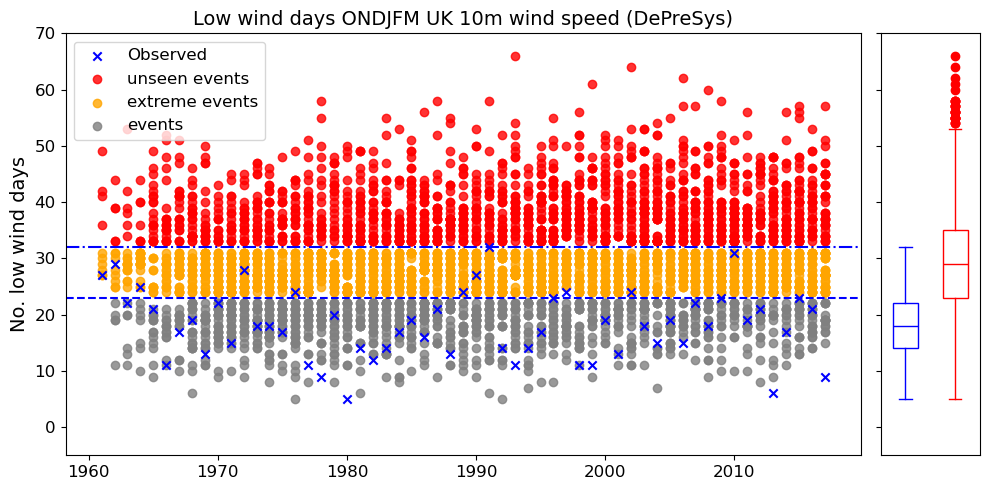

In [161]:
# plot the demand net wind exceedance days
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance_uk,
    obs_val_name="no_undershoot_days_wind",
    model_val_name="no_undershoot_days_wind",
    model_time_name="effective_dec_year",
    ylabel="No. low wind days",
    title="Low wind days ONDJFM UK 10m wind speed (DePreSys)",
    ylims=(-5, 60),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [164]:
df_obs_sfcWind_ns.head()

# set time as the index
df_obs_sfcWind_ns.set_index("time", inplace=True)

In [165]:
# process the obs for the north sea region
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.unique(df_obs_sfcWind_ns["effective_dec_year"])

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
no_exceedance_days_demand = []
severity_index_demand = []

# Same for wind speed
no_undershoot_days_wind = []
severity_index_wind = []

# # Same for demand net wind
no_exceedance_days_demand_net_wind = []
severity_index_demand_net_wind = []

# 92 just chosen to be in line with demand net wind
# 87th percentile for demand ~ 45 GW
# all_winters_high_demand = np.percentile(df_obs["UK_demand_dt"], 90)

# 94th percentile for demand net wind ~ 40 GW identified by Ben Sloman as being
# challenging
# all_winters_high_DnW = np.percentile(df_obs["demand_dt_net_wind"], 90)

# 12th percentile of wind generation ~ 5 GW
# Which is pretty low during the winter
# all_winters_low_wind = np.percentile(df_ch["wind_gen"], 10)
# all_winters_low_wind_uk = np.percentile(df_obs_sfcWind_ns["data"], 10)
all_winters_low_wind_ns = np.percentile(df_obs_sfcWind_ns["data"], 10)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df_this = df_obs_sfcWind_ns.loc[winter_start:winter_end]
    # df_ch_this = df_ch.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df_this.index:
        print("Dropping 29th Feb")
        df_this = df_this.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    # mask_demand = df["UK_demand_dt"] > all_winters_high_demand
    # mask_DnW = df["demand_dt_net_wind"] > all_winters_high_DnW
    # mask_wind = df_ch_this["wind_gen"] < all_winters_low_wind
    mask_wind_uk = df_this["data"] < all_winters_low_wind_ns

    # # calculate the severity index
    # severity_index_demand_this = (
    #     df["UK_demand_dt"][mask_demand] - all_winters_high_demand
    # ).sum()
    # severity_index_demand_net_wind_this = (
    #     df["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
    # ).sum()
    # severity_index_wind_this = (
    #     all_winters_low_wind - df_ch_this["wind_gen"][mask_wind]
    # ).sum()

    # # append these to the list
    # severity_index_demand.append(severity_index_demand_this)
    # severity_index_demand_net_wind.append(severity_index_demand_net_wind_this)
    # severity_index_wind.append(severity_index_wind_this)

    # calculate the no. exceedance days
    # no_exceedance_days_demand_this = mask_demand.sum()
    # no_exceedance_days_demand_net_wind_this = mask_DnW.sum()
    # no_undershoot_days_wind_this = mask_wind.sum()
    no_low_wind_days_uk = mask_wind_uk.sum()

    # append these to the list
    # no_exceedance_days_demand.append(no_exceedance_days_demand_this)
    # no_exceedance_days_demand_net_wind.append(no_exceedance_days_demand_net_wind_this)
    no_undershoot_days_wind.append(no_low_wind_days_uk)

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "no_undershoot_days_wind": no_undershoot_days_wind,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [166]:
df_exceedance_days_obs_ns = df_exceedance_days_obs.copy()

<Axes: >

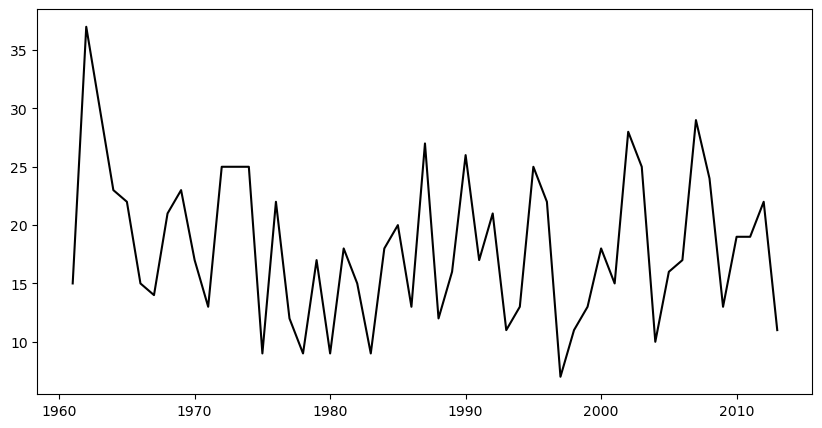

In [167]:
# plot th enumber of exceedance days
fig, ax = plt.subplots(figsize=(10, 5))

# plot the number of exceedance days
df_exceedance_days_obs_ns["no_undershoot_days_wind"].plot(ax=ax, color="black", label="North Sea")

In [168]:
# Extract the unique init years
init_years = df_model_ondjfm_ns_bc["init_year"].unique()
members = df_model_ondjfm_ns_bc["member"].unique()
winter_years = df_model_ondjfm_ns_bc["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for demand net wind
model_severity_index_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for wind generation
model_severity_index_wind = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_undershoot_days_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_ondjfm_ns_bc[
                (df_model_ondjfm_ns_bc["init_year"] == i_year)
                & (df_model_ondjfm_ns_bc["member"] == member)
                & (df_model_ondjfm_ns_bc["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            # mask_demand = df_this["UK_demand_dt"] > all_winters_high_demand
            # mask_DnW = df_this["demand_dt_net_wind"] > all_winters_high_DnW
            mask_wind = df_this["data_bc"] < all_winters_low_wind_ns

            # # calculate the severity index
            # model_severity_index_demand[i, j, k] = (
            #     df_this["UK_demand_dt"][mask_demand] - all_winters_high_demand
            # ).sum()
            # model_severity_index_demand_net_wind[i, j, k] = (
            #     df_this["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
            # ).sum()
            # model_severity_index_wind[i, j, k] = (
            #     all_winters_low_wind - df_this["wind_gen_sigmoid"][mask_wind]
            # ).sum()

            # # calculate the no. exceedance days
            # model_no_exceedance_days_demand[i, j, k] = mask_demand.sum()
            # model_no_exceedance_days_demand_net_wind[i, j, k] = mask_DnW.sum()
            model_no_undershoot_days_wind[i, j, k] = mask_wind.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "no_undershoot_days_wind": [model_no_undershoot_days_wind[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [180]:
df_model_exceedance_ns = df_model_exceedance.copy()

In [182]:
# set u-p effective dec year
df_model_exceedance_ns["effective_dec_year"] = (
    df_model_exceedance_ns["init_year"] + df_model_exceedance_ns["winter_year"]
)

In [183]:
# get rid of the years
df_model_exceedance_ns = df_model_exceedance_ns[
    df_model_exceedance_ns["effective_dec_year"] < 2014
]

The worst event occurs in the year: 1962
The no. days for the worst event is: 37
Bad events have high values
The chance of a very bad event is: 1.2164948453608249%
The chance of a very bad event is: 1 in 82 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2025-01-20-17-02-50.pdf


Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2025-01-20-17-02-50.pdf


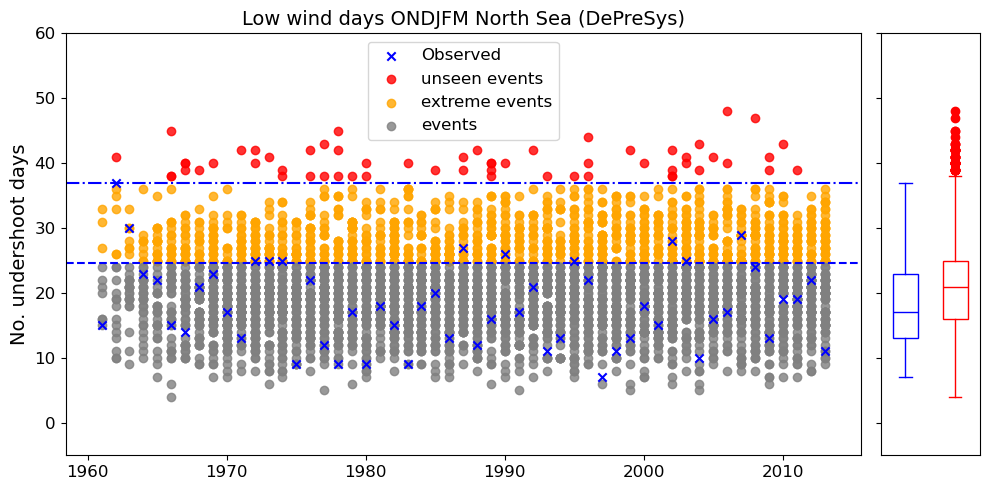

In [184]:
# Do the same but for wind power
dot_plot(
    obs_df=df_exceedance_days_obs_ns,
    model_df=df_model_exceedance_ns,
    obs_val_name="no_undershoot_days_wind",
    model_val_name="no_undershoot_days_wind",
    model_time_name="effective_dec_year",
    ylabel="No. undershoot days",
    title="Low wind days ONDJFM North Sea (DePreSys)",
    ylims=(-5, 60),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

In [185]:
df_model_ondjfm_ns_canari_bc.head()

date  member  sfcWind_u  sfcWind_v   sfcWind  \
154800  1960-10-01       1  -0.687105   6.651969  6.853761   
154801  1960-10-01       2  -4.793589  -5.596506  7.427539   
154802  1960-10-01       3   2.686068   5.191956  6.386104   
154803  1960-10-01       4  -5.741408   3.895118  6.965915   
154804  1960-10-01       5  -5.470882  -1.741642  5.756577   

        effective_dec_year  sfcWind_bc  
154800                1960    7.509383  
154801                1960    8.083161  
154802                1960    7.041727  
154803                1960    7.621537  
154804                1960    6.412199

In [186]:
# do the same but for canari
# extrcat the unique effective_dec_years
dec_years = df_model_ondjfm_ns_canari_bc["effective_dec_year"].unique()
members = df_model_ondjfm_ns_canari_bc["member"].unique()

# array for the no undershoot days wind
model_no_undershoot_days_wind_canari = np.zeros([len(dec_years), len(members)])

# set up an empty df
df_model_exceedance_canari = pd.DataFrame()

# loop over the dec years
for i, dec_year in enumerate(dec_years):
    for j, member in enumerate(members):
        # constrain to the dec year and member
        df_this = df_model_ondjfm_ns_canari_bc[
            (df_model_ondjfm_ns_canari_bc["effective_dec_year"] == dec_year)
            & (df_model_ondjfm_ns_canari_bc["member"] == member)
        ]

        # apply a boolean mask to the demand net wind value
        # which is true where the demand net wind is greater than the 80% tile value
        mask_wind = df_this["sfcWind_bc"] < all_winters_low_wind_ns

        # calculate the no. undershoot days
        model_no_undershoot_days_wind_canari[i, j] = mask_wind.sum()

        # Set up the df
        df_this_exceedance = pd.DataFrame(
            {
                "effective_dec_year": [dec_year],
                "member": [member],
                "no_undershoot_days_wind": [model_no_undershoot_days_wind_canari[i, j]],
            }
        )

        # Append to the df
        df_model_exceedance_canari = pd.concat([df_model_exceedance_canari, df_this_exceedance])

In [188]:
df_model_exceedance_canari.tail()

effective_dec_year  member  no_undershoot_days_wind
0                2013      36                     15.0
0                2013      37                     33.0
0                2013      38                     26.0
0                2013      39                     28.0
0                2013      40                     35.0

The worst event occurs in the year: 1962
The no. days for the worst event is: 37
Bad events have high values
The chance of a very bad event is: 7.361111111111112%
The chance of a very bad event is: 1 in 14 years
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2025-01-20-17-10-16.pdf


Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2025-01-20-17-10-16.pdf


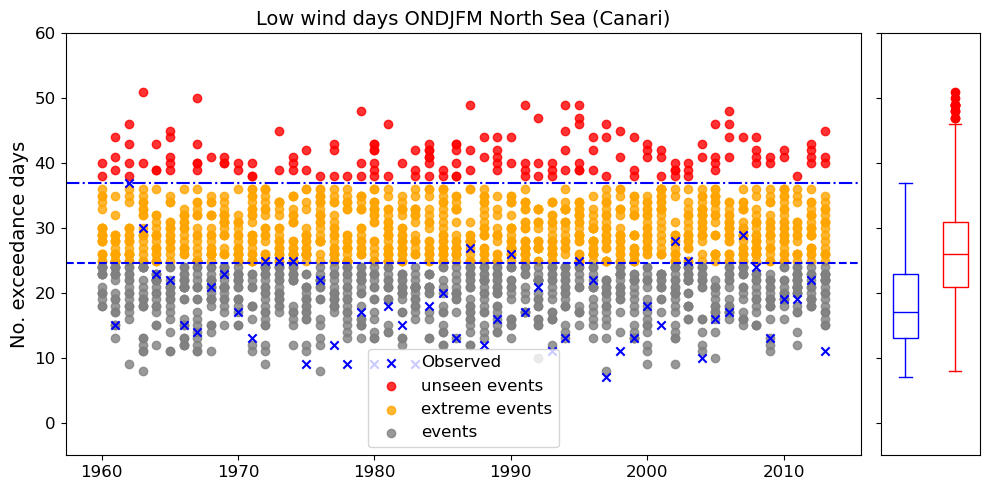

In [191]:
# Do the same but for canari
dot_plot(
    obs_df=df_exceedance_days_obs_ns,
    model_df=df_model_exceedance_canari,
    obs_val_name="no_undershoot_days_wind",
    model_val_name="no_undershoot_days_wind",
    model_time_name="effective_dec_year",
    ylabel="No. exceedance days",
    title="Low wind days ONDJFM North Sea (Canari)",
    ylims=(-5, 60),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now look at the return period for extremes.

In [48]:
# reset index of obs_df
df_exceedance_days_obs.reset_index(inplace=True)

In [49]:
df_exceedance_days_obs.tail()

index  severity_index_demand  no_exceedance_days_demand  \
54   2014               5.565327                         10   
55   2015               1.817664                          5   
56   2016               1.111685                          5   
57   2017              22.349360                         22   
58   2018               0.000000                          0   

    severity_index_demand_net_wind  no_exceedance_days_demand_net_wind  \
54                       23.509838                                  12   
55                       26.888722                                  11   
56                       19.725007                                  14   
57                        9.122758                                   7   
58                        5.377632                                   3   

    severity_index_wind  no_undershoot_days_wind  
54            16.702767                       16  
55            37.077866                       21  
56            28.249807                       24  
57            11.240656                       10  
58             5.197817                        6

In [50]:
# quantify the 99.9th percentile of the obs data for demand net wind
df_exceedance_days_obs["no_exceedance_days_demand_net_wind"].quantile(0.999)

np.float64(35.884000000000015)

In [51]:
np.max(df_exceedance_days_obs["no_exceedance_days_demand_net_wind"])

np.int64(36)

In [52]:
df_model_exceedance.head()

init_year  member  winter_year  severity_index_demand  \
0       1960       1            1               8.349354   
0       1960       1            2              30.571060   
0       1960       1            3              40.577661   
0       1960       1            4               4.076673   
0       1960       1            5              11.510319   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                        6.0                       46.931563   
0                       22.0                       68.247568   
0                       28.0                       19.736773   
0                       11.0                       33.757206   
0                       20.0                       28.429395   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                21.0            54.151586   
0                                22.0            35.703712   
0                                12.0            20.092229   
0                                16.0            21.906649   
0                                11.0            26.636936   

   no_undershoot_days_wind  effective_dec_year  
0                     30.0                1961  
0                     23.0                1962  
0                     19.0                1963  
0                     14.0                1964  
0                     19.0                1965

99.9th %tile ~ max(DnW exceedance days) ~ 26 days (1962/63 winter)

In [53]:
importlib.reload(sys.modules["functions"])
from functions import plot_rp_extremes

In [54]:
# # For demand net wind
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand_net_wind",
#     model_val_name="no_exceedance_days_demand_net_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 70),
#     percentile=99.9,
# )

In [55]:
# print the 99.9th percentile of the model data
print(np.max(df_exceedance_days_obs["no_undershoot_days_wind"]))
print(np.quantile(df_exceedance_days_obs["no_undershoot_days_wind"], 0.999))

31
31.0


In [56]:
# # Same for wind
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_undershoot_days_wind",
#     model_val_name="no_undershoot_days_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 60),
#     percentile=99.9,
# )

In [57]:
print(np.max(df_exceedance_days_obs["no_exceedance_days_demand"]))
print(np.quantile(df_exceedance_days_obs["no_exceedance_days_demand"], 0.999))

65
64.362


In [58]:
# # same for demand
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand",
#     model_val_name="no_exceedance_days_demand",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 120),
#     percentile=99.9,
# )

In [59]:
importlib.reload(sys.modules["functions"])
from functions import plot_rp_extremes_decades

In [60]:
df_exceedance_days_obs.head()

index  severity_index_demand  no_exceedance_days_demand  \
0   1960               0.008911                          1   
1   1961              19.385662                         19   
2   1962              93.614505                         54   
3   1963               5.480202                          8   
4   1964              14.515761                         19   

   severity_index_demand_net_wind  no_exceedance_days_demand_net_wind  \
0                       24.231988                                  16   
1                       57.196654                                  30   
2                      109.931359                                  36   
3                       23.417931                                  13   
4                       26.599745                                  18   

   severity_index_wind  no_undershoot_days_wind  
0            36.545218                       23  
1            39.575294                       27  
2            37.786112                       29  
3            23.847285                       27  
4            30.751375                       23

In [61]:
# set up the index column as the index
df_exceedance_days_obs.set_index("index", inplace=True)

In [62]:
# params, years = plot_rp_extremes_decades(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand_net_wind",
#     model_val_name="no_exceedance_days_demand_net_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
# )

In [63]:
# obs_df=df_exceedance_days_obs
# model_df=df_model_exceedance
# obs_val_name="no_exceedance_days_demand_net_wind"
# model_val_name="no_exceedance_days_demand_net_wind"
# worst_or_perc_rp="worst"
# percentile=99.9
# decades = np.arange(1960, 2030, 10)
# plot_rp_percentage=True
# years_period = (1960, 2028)
# save_prefix = "rp_extremes_decades"
# save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
# y_label = "No. exceedance days"

In [64]:
# # Set up the array for mean, 2.5th and 97.5th percentiles
# period_decade_mean = np.zeros([len(years)])
# period_decade_025 = np.zeros([len(years)])
# period_decade_975 = np.zeros([len(years)])

# if worst_or_perc_rp == "worst":
#     print("Calculating return period for worst (max) event")
#     obs_bad_event = obs_df[obs_val_name].max()
# elif worst_or_perc_rp == "perc":
#     print(f"Calculating return period for {percentile}th percentile event")
#     obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # loop over the unique years to fit the ppfs
# for i, decade in tqdm(enumerate(years)):
#     # Subset the params for the decade
#     params_decade = params[i, :, :]

#     # Estimate the period for the model mean data
#     period_decade_mean[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.mean(params_decade[:, 1]),
#         scale=np.mean(params_decade[:, 2]),
#         shape=np.mean(params_decade[:, 0]),
#     )

#     # model 025 percentile
#     period_decade_025[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 2.5),
#         scale=np.percentile(params_decade[:, 2], 2.5),
#         shape=np.percentile(params_decade[:, 0], 2.5),
#     )

#     # model 95 percentile
#     period_decade_975[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 97.5),
#         scale=np.percentile(params_decade[:, 2], 97.5),
#         shape=np.percentile(params_decade[:, 0], 97.5),
#     )

# # put these into a dataframe with the years
# model_df_rl = pd.DataFrame(
#     {
#         "decade": decades,
#         "mean": period_decade_mean,
#         "025": period_decade_025,
#         "975": period_decade_975,
#     }
# )

# # for each row of "mean", "025", "975" calculate the return period
# # 1 / (1 - (100 - value))
# model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
# model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
# model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# # calculate the return period in years of the observed worst event
# model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
# model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
# model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# # plot the mean rp values with error bars for the 025 and 975 percentiles
# plt.figure(figsize=(10, 5))

# # if we are plotting the return period as a percentage
# if plot_rp_percentage:
#     y_val_mean = model_df_rl["mean_rp (%)"]
#     y_val_025 = model_df_rl["025_rp (%)"]
#     y_val_975 = model_df_rl["975_rp (%)"]
#     y_label = "Return period (%)"

#     # Set up the error bars
#     upper_errs = abs(model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
#     lower_errs = abs(model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])

#     # set up the yticks
#     yticks_ints = [0.01, 0.1]
#     yticks_strs = ["1%", "10%"]

# else:
#     y_val_mean = model_df_rl["mean_rp (years)"]
#     y_val_025 = model_df_rl["025_rp (years)"]
#     y_val_975 = model_df_rl["975_rp (years)"]
#     y_label = "Return period (years)"

#     # Set up the error bars
#     upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
#     lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

#     # set up the yticks
#     yticks_ints = [1, 10, 100, 1000]
#     yticks_strs = ["1", "10", "100", "1000"]

# # print the upper and lower errors
# print(f"Upper errors: {upper_errs}")
# print(f"Lower errors: {lower_errs}")

# # assert that upper errs and lower errors are positive
# assert np.all(upper_errs > 0), "Upper errors must be positive"
# assert np.all(lower_errs > 0), "Lower errors must be positive"

# # Plot the mean
# plt.scatter(
#     model_df_rl["decade"],
#     y_val_mean,
#     color="red",
# )

# # Plot the 025 and 975 percentiles
# plt.errorbar(
#     model_df_rl["decade"],
#     y_val_mean,
#     yerr=[lower_errs, upper_errs],
#     fmt="none",
#     color="red",
#     capsize=5,
# )

# # Set up the yscale
# plt.yscale("log")

# # Set up the yticks
# plt.yticks(yticks_ints, yticks_strs)

# # Set up the ylabel
# plt.ylabel(y_label, fontsize=12)

# # Set up the title
# if worst_or_perc_rp == "worst":
#     plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# elif worst_or_perc_rp == "perc":
#     plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # Set up the fname
# fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# # Set up the savepath
# savepath = os.path.join(save_dir, fname)

# # if the savepath does not exist
# if not os.path.exists(savepath):
#     print(f"Saving plot to {savepath}")

#     # Save the plot
#     plt.savefig(savepath, bbox_inches="tight", dpi=800)
# else:
#     print(f"Savepath {savepath} already exists")

In [65]:
# params, years = plot_rp_extremes_decades(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand",
#     model_val_name="no_exceedance_days_demand",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
# )

In [66]:
# obs_val_name="no_exceedance_days_demand"
# model_val_name="no_exceedance_days_demand"

# obs_df=df_exceedance_days_obs
# model_df=df_model_exceedance
# worst_or_perc_rp="worst"
# percentile=99.9
# decades = np.arange(1960, 2030, 10)
# plot_rp_percentage=True
# years_period = (1960, 2028)
# save_prefix = "rp_extremes_decades"
# save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
# y_label = "No. exceedance days demand"

In [67]:
# # Set up the array for mean, 2.5th and 97.5th percentiles
# period_decade_mean = np.zeros([len(years)])
# period_decade_025 = np.zeros([len(years)])
# period_decade_975 = np.zeros([len(years)])

# if worst_or_perc_rp == "worst":
#     print("Calculating return period for worst (max) event")
#     obs_bad_event = obs_df[obs_val_name].max()
# elif worst_or_perc_rp == "perc":
#     print(f"Calculating return period for {percentile}th percentile event")
#     obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # loop over the unique years to fit the ppfs
# for i, decade in tqdm(enumerate(years)):
#     # Subset the params for the decade
#     params_decade = params[i, :, :]

#     # Estimate the period for the model mean data
#     period_decade_mean[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.mean(params_decade[:, 1]),
#         scale=np.mean(params_decade[:, 2]),
#         shape=np.mean(params_decade[:, 0]),
#     )

#     # model 025 percentile
#     period_decade_025[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 2.5),
#         scale=np.percentile(params_decade[:, 2], 2.5),
#         shape=np.percentile(params_decade[:, 0], 2.5),
#     )

#     # model 95 percentile
#     period_decade_975[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 97.5),
#         scale=np.percentile(params_decade[:, 2], 97.5),
#         shape=np.percentile(params_decade[:, 0], 97.5),
#     )

# # put these into a dataframe with the years
# model_df_rl = pd.DataFrame(
#     {
#         "decade": decades,
#         "mean": period_decade_mean,
#         "025": period_decade_025,
#         "975": period_decade_975,
#     }
# )

# # for each row of "mean", "025", "975" calculate the return period
# # 1 / (1 - (100 - value))
# model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
# model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
# model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# # calculate the return period in years of the observed worst event
# model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
# model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
# model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# # plot the mean rp values with error bars for the 025 and 975 percentiles
# plt.figure(figsize=(10, 5))

# # if we are plotting the return period as a percentage
# if plot_rp_percentage:
#     y_val_mean = model_df_rl["mean_rp (%)"]
#     y_val_025 = model_df_rl["025_rp (%)"]
#     y_val_975 = model_df_rl["975_rp (%)"]
#     y_label = "Return period (%)"

#     # Set up the error bars
#     upper_errs = (model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
#     lower_errs = (model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])

#     # set up the yticks
#     yticks_ints = [0.001, 0.01, 0.1]
#     yticks_strs = ["0.1%", "1%", "10%"]

# else:
#     y_val_mean = model_df_rl["mean_rp (years)"]
#     y_val_025 = model_df_rl["025_rp (years)"]
#     y_val_975 = model_df_rl["975_rp (years)"]
#     y_label = "Return period (years)"

#     # Set up the error bars
#     upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
#     lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

#     # set up the yticks
#     yticks_ints = [1, 10, 100, 1000]
#     yticks_strs = ["1", "10", "100", "1000"]

# # print the upper and lower errors
# print(f"Upper errors: {upper_errs}")
# print(f"Lower errors: {lower_errs}")

# # assert that upper errs and lower errors are positive
# assert np.all(upper_errs > 0), "Upper errors must be positive"
# assert np.all(lower_errs > 0), "Lower errors must be positive"

# # Plot the mean
# plt.scatter(
#     model_df_rl["decade"],
#     y_val_mean,
#     color="red",
# )

# # Plot the 025 and 975 percentiles
# plt.errorbar(
#     model_df_rl["decade"],
#     y_val_mean,
#     yerr=[lower_errs, upper_errs],
#     fmt="none",
#     color="red",
#     capsize=5,
# )

# # Set up the yscale
# plt.yscale("log")

# # Set up the yticks
# plt.yticks(yticks_ints, yticks_strs)

# # Set up the ylabel
# plt.ylabel(y_label, fontsize=12)

# # Set up the title
# if worst_or_perc_rp == "worst":
#     plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# elif worst_or_perc_rp == "perc":
#     plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # Set up the fname
# fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# # Set up the savepath
# savepath = os.path.join(save_dir, fname)

# # if the savepath does not exist
# if not os.path.exists(savepath):
#     print(f"Saving plot to {savepath}")

#     # Save the plot
#     plt.savefig(savepath, bbox_inches="tight", dpi=800)
# else:
#     print(f"Savepath {savepath} already exists")

In [68]:
# params, years = plot_rp_extremes_decades(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_undershoot_days_wind",
#     model_val_name="no_undershoot_days_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
# )

In [69]:
# obs_val_name="no_undershoot_days_wind"
# model_val_name="no_undershoot_days_wind"

# obs_df=df_exceedance_days_obs
# model_df=df_model_exceedance
# worst_or_perc_rp="worst"
# percentile=99.9
# decades = np.arange(1960, 2030, 10)
# plot_rp_percentage=True
# years_period = (1960, 2028)
# save_prefix = "rp_extremes_decades"
# save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
# y_label = "No. exceedance days wind"

In [70]:
# # Set up the array for mean, 2.5th and 97.5th percentiles
# period_decade_mean = np.zeros([len(years)])
# period_decade_025 = np.zeros([len(years)])
# period_decade_975 = np.zeros([len(years)])

# if worst_or_perc_rp == "worst":
#     print("Calculating return period for worst (max) event")
#     obs_bad_event = obs_df[obs_val_name].max()
# elif worst_or_perc_rp == "perc":
#     print(f"Calculating return period for {percentile}th percentile event")
#     obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # loop over the unique years to fit the ppfs
# for i, decade in tqdm(enumerate(years)):
#     # Subset the params for the decade
#     params_decade = params[i, :, :]

#     # Estimate the period for the model mean data
#     period_decade_mean[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.mean(params_decade[:, 1]),
#         scale=np.mean(params_decade[:, 2]),
#         shape=np.mean(params_decade[:, 0]),
#     )

#     # model 025 percentile
#     period_decade_025[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 2.5),
#         scale=np.percentile(params_decade[:, 2], 2.5),
#         shape=np.percentile(params_decade[:, 0], 2.5),
#     )

#     # model 95 percentile
#     period_decade_975[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 97.5),
#         scale=np.percentile(params_decade[:, 2], 97.5),
#         shape=np.percentile(params_decade[:, 0], 97.5),
#     )

# # put these into a dataframe with the years
# model_df_rl = pd.DataFrame(
#     {
#         "decade": decades,
#         "mean": period_decade_mean,
#         "025": period_decade_025,
#         "975": period_decade_975,
#     }
# )

# # for each row of "mean", "025", "975" calculate the return period
# # 1 / (1 - (100 - value))
# model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
# model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
# model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# # calculate the return period in years of the observed worst event
# model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
# model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
# model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# # plot the mean rp values with error bars for the 025 and 975 percentiles
# plt.figure(figsize=(10, 5))

# # if we are plotting the return period as a percentage
# if plot_rp_percentage:
#     y_val_mean = model_df_rl["mean_rp (%)"]
#     y_val_025 = model_df_rl["025_rp (%)"]
#     y_val_975 = model_df_rl["975_rp (%)"]
#     y_label = "Return period (%)"

#     # Set up the error bars
#     # upper_errs = (model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
#     # lower_errs = (model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])
#     upper_errs = model_df_rl["975_rp (%)"] - model_df_rl["mean_rp (%)"]
#     lower_errs = model_df_rl["mean_rp (%)"] - model_df_rl["025_rp (%)"]

#     # set up the yticks
#     yticks_ints = [0.001, 0.01, 0.1]
#     yticks_strs = ["0.1%", "1%", "10%"]

# else:
#     y_val_mean = model_df_rl["mean_rp (years)"]
#     y_val_025 = model_df_rl["025_rp (years)"]
#     y_val_975 = model_df_rl["975_rp (years)"]
#     y_label = "Return period (years)"

#     # Set up the error bars
#     upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
#     lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

#     # set up the yticks
#     yticks_ints = [1, 10, 100, 1000]
#     yticks_strs = ["1", "10", "100", "1000"]

# # print the upper and lower errors
# print(f"Upper errors: {upper_errs}")
# print(f"Lower errors: {lower_errs}")

# # assert that upper errs and lower errors are positive
# assert np.all(upper_errs > 0), "Upper errors must be positive"
# assert np.all(lower_errs > 0), "Lower errors must be positive"

# # Plot the mean
# plt.scatter(
#     model_df_rl["decade"],
#     y_val_mean,
#     color="red",
# )

# # Plot the 025 and 975 percentiles
# plt.errorbar(
#     model_df_rl["decade"],
#     y_val_mean,
#     yerr=[lower_errs, upper_errs],
#     fmt="none",
#     color="red",
#     capsize=5,
# )

# # Set up the yscale
# plt.yscale("log")

# # Set up the yticks
# plt.yticks(yticks_ints, yticks_strs)

# # Set up the ylabel
# plt.ylabel(y_label, fontsize=12)

# # Set up the title
# if worst_or_perc_rp == "worst":
#     plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# elif worst_or_perc_rp == "perc":
#     plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # Set up the fname
# fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# # Set up the savepath
# savepath = os.path.join(save_dir, fname)

# # if the savepath does not exist
# if not os.path.exists(savepath):
#     print(f"Saving plot to {savepath}")

#     # Save the plot
#     plt.savefig(savepath, bbox_inches="tight", dpi=800)
# else:
#     print(f"Savepath {savepath} already exists")

Now move onto looking at the drivers.

In [71]:
importlib.reload(sys.modules["functions"])
from functions import plot_composite_obs_model_exceed, load_file_composites

In [72]:
composite, years, members, leads, lats, lons = load_file_composites(
   psl_variable="psl",
)

Loading the file from /gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-2018/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-2018.npy


Time taken to load the file: 143.12 seconds
Shape of the composite: (59, 10, 125, 324, 432)


In [75]:
importlib.reload(sys.modules["functions"])
from functions import plot_composite_obs_model_exceed, load_file_composites

In [73]:
# %%time

# composite_anoms, composite_pvals = plot_composite_obs_model_exceed(
#     composite=composite,
#     years=years,
#     members=members,
#     leads=leads,
#     lats=lats,
#     lons=lons,
#     model_df=df_model_exceedance,
#     model_val_name="no_exceedance_days_demand_net_wind",
#     exceedance_days=[40, 50, 52],
#     nboot=1000,
#     psl_variable="tas",
#     calc_anoms=True,
#     detrend=True,
# )

Calculate the ENSO and La Nina years by quantifying the Nino 3.4 index.

* -170 to -120 degrees longitude
* 5 *N to 5 *S latitude

Will need to be detrended first

In [76]:
winter_years = np.arange(1, 10 + 1, 1)

# Set up the composite array
composite_array = np.zeros([
    len(years),
    len(members),
    len(winter_years),
    len(lats),
    len(lons),
])

# Loop over the winter years in hadgem
for i, wyear in enumerate(winter_years):
    # Set up the lead values to extract
    leads_values_this = np.arange((wyear * 12), (wyear * 12) + 6, 1)

    # Find the index of the lead values in leads
    idx = np.where(np.isin(leads, leads_values_this))[0]

    # Extract the values and take the mean along axis 2
    composite_mean = np.mean(composite[:, :, idx, :, :], axis=2)

    # Assign the mean values to the composite array
    composite_array[:, :, i, :, :] = composite_mean

In [77]:
composite_array.shape

(59, 10, 10, 324, 432)

In [78]:
members

array([10,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [79]:
winter_years

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [80]:
# %%time

# from scipy.stats import linregress

# # set up an empty array for detrended
# detrend_composite_array = np.zeros_like(composite_array)

# # print the shape of detrended composite array
# print(detrend_composite_array.shape)

# print("Detrending the composite means")
# # Loop over the lats
# for ilat in tqdm(range(len(lats))):
#     # Loop over the lons
#     for ilon in range(len(lons)):
#         # Detrend the composite means
#         slope, intercept, _, _, _ = linregress(
#             years,
#             np.mean(composite_array[:, :, :, ilat, ilon], axis=(1, 2))
#         )

#         # Calculate the trend line
#         trend_line = slope * years + intercept

#         # Calculate the trend line to pivot around the final point
#         trend_final = slope * years[-1] + intercept

#         # loop over the unique members
#         for m, member in enumerate(members):
#             for wy, winter_year in enumerate(winter_years):
#                 # set up the composite array
#                 detrend_composite_array[:, m, wy, ilat, ilon] = composite_array[:, m, wy, ilat, ilon] - (trend_line - trend_final)

In [81]:
composite_array.shape

(59, 10, 10, 324, 432)

In [82]:
# define the nino 3.4 index
nino34 = {
    "lat1": -5,
    "lat2": 5,
    "lon1": -170,
    "lon2": -120,
}

# Set up the uk clark gridbox
uk_clark = {
    "lat1": 50,
    "lat2": 60,
    "lon1": -10,
    "lon2": 3,
}

# Define the dimensions for the gridbox for the azores
azores_grid_corrected = {"lon1": -28, "lon2": -20, "lat1": 36, "lat2": 40}

# Define the dimensions for the gridbox for the azores
iceland_grid_corrected = {"lon1": -25, "lon2": -16, "lat1": 63, "lat2": 70}

# Define this but corrected
uk_n_box_corrected = {"lon1": -27, "lon2": 21, "lat1": 57, "lat2": 70}

# Define this but corrected
uk_s_box_corrected = {"lon1": -27, "lon2": 21, "lat1": 38, "lat2": 51}

# # Find the indices of the nino 3.4 region
# lat1_idx = np.argmin(np.abs(lats - nino34["lat1"]))
# lat2_idx = np.argmin(np.abs(lats - nino34["lat2"]))
# lon1_idx = np.argmin(np.abs(lons - nino34["lon1"]))
# lon2_idx = np.argmin(np.abs(lons - nino34["lon2"]))

# # Find the indices of the uk clark region
# uk_lat1_idx = np.argmin(np.abs(lats - uk_clark["lat1"]))
# uk_lat2_idx = np.argmin(np.abs(lats - uk_clark["lat2"]))
# uk_lon1_idx = np.argmin(np.abs(lons - uk_clark["lon1"]))
# uk_lon2_idx = np.argmin(np.abs(lons - uk_clark["lon2"]))

# find the indices of the azores region
azores_lat1_idx = np.argmin(np.abs(lats - azores_grid_corrected["lat1"]))
azores_lat2_idx = np.argmin(np.abs(lats - azores_grid_corrected["lat2"]))
azores_lon1_idx = np.argmin(np.abs(lons - azores_grid_corrected["lon1"]))
azores_lon2_idx = np.argmin(np.abs(lons - azores_grid_corrected["lon2"]))

# Find the indicies of the iceland region
iceland_lat1_idx = np.argmin(np.abs(lats - iceland_grid_corrected["lat1"]))
iceland_lat2_idx = np.argmin(np.abs(lats - iceland_grid_corrected["lat2"]))
iceland_lon1_idx = np.argmin(np.abs(lons - iceland_grid_corrected["lon1"]))
iceland_lon2_idx = np.argmin(np.abs(lons - iceland_grid_corrected["lon2"]))

# Find the indices of the uk n box region
uk_n_lat1_idx = np.argmin(np.abs(lats - uk_n_box_corrected["lat1"]))
uk_n_lat2_idx = np.argmin(np.abs(lats - uk_n_box_corrected["lat2"]))
uk_n_lon1_idx = np.argmin(np.abs(lons - uk_n_box_corrected["lon1"]))
uk_n_lon2_idx = np.argmin(np.abs(lons - uk_n_box_corrected["lon2"]))

# Find the indices of the uk s box region
uk_s_lat1_idx = np.argmin(np.abs(lats - uk_s_box_corrected["lat1"]))
uk_s_lat2_idx = np.argmin(np.abs(lats - uk_s_box_corrected["lat2"]))
uk_s_lon1_idx = np.argmin(np.abs(lons - uk_s_box_corrected["lon1"]))
uk_s_lon2_idx = np.argmin(np.abs(lons - uk_s_box_corrected["lon2"]))

In [84]:
composite_array.shape

(59, 10, 10, 324, 432)

In [83]:
%%time

# Remove the climatology from the detrended composite array
# final 30 years of the climatology
# detrend_composite_anoms = detrend_composite_array - np.mean(detrend_composite_array[-30:, :, :, :, :], axis=(0, 1, 2))

# remove all years from the climatology
composite_anoms = composite_array - np.mean(composite_array, axis=(0, 1, 2))

CPU times: user 740 ms, sys: 422 ms, total: 1.16 s
Wall time: 1.17 s


In [106]:
# Set up an empty dataframe
# df_nino34 = pd.DataFrame()
df_nao_delta_p = pd.DataFrame()

# loop over the years
for y, year in tqdm(enumerate(years)):
    # loop over the members
    for m, member in enumerate(members):
        # loop over the winter years
        for wy, winter_year in enumerate(winter_years):
            # Calculate the nao index
            azores_mean = np.mean(composite_anoms[y, m, wy, azores_lat1_idx:azores_lat2_idx, azores_lon1_idx:azores_lon2_idx])
            iceland_mean = np.mean(composite_anoms[y, m, wy, iceland_lat1_idx:iceland_lat2_idx, iceland_lon1_idx:iceland_lon2_idx])

            # Calculate the difference
            nao_index = azores_mean - iceland_mean

            # Calculate the n and s box means for the delta P index
            uk_n_mean = np.mean(composite_anoms[y, m, wy, uk_n_lat1_idx:uk_n_lat2_idx, uk_n_lon1_idx:uk_n_lon2_idx])
            uk_s_mean = np.mean(composite_anoms[y, m, wy, uk_s_lat1_idx:uk_s_lat2_idx, uk_s_lon1_idx:uk_s_lon2_idx])

            # Calculate the difference
            delta_p = uk_s_mean - uk_n_mean

            # Set up the df
            df_this = pd.DataFrame(
                {
                    "year": [year],
                    "member": [member],
                    "winter_year": [winter_year],
                    "nao_index": [nao_index],
                    "delta_p": [delta_p],
                }
            )

            # Append to the df
            df_nao_delta_p = pd.concat([df_nao_delta_p, df_this])

12it [00:00, 37.44it/s]

59it [00:01, 37.61it/s]


In [107]:
# reset the index of nao delta p
df_nao_delta_p.reset_index(drop=True, inplace=True)

In [108]:
df_nao_delta_p.tail()

year  member  winter_year    nao_index     delta_p
5895  2018       9            6   278.749812   -4.501455
5896  2018       9            7 -1018.630629 -478.655105
5897  2018       9            8   134.372859    2.827935
5898  2018       9            9   412.304453  554.631422
5899  2018       9           10  -144.943417 -463.523897

In [109]:
# set up new columns for the nao index and delta p in hpa
df_nao_delta_p["nao_index_hpa"] = df_nao_delta_p["nao_index"] / 100
df_nao_delta_p["delta_p_hpa"] = df_nao_delta_p["delta_p"] / 100

In [110]:
# # add a new column for the nino34 index
# # for el nino or la nina or neutral (EN, LN, N)
# # if value is greater than 0.4 then el nino
# # if value is less than -0.4 then la nina
# # otherwise neutral
# df_nino34["nino34"] = np.where(
#     df_nino34["nino34_index"] > 0.4,
#     "EN",
#     np.where(
#         df_nino34["nino34_index"] < -0.4,
#         "LN",
#         "N",
#     )
# )

In [111]:
# # add a new column for the strength of the nino34 index
# # if value is greater than 0.4 then weak (weak)
# # if value is greater than 0.8 then moderate (mod)
# # if value is greater than 1.5 then strong (strong)
# # if value is greater than 2.0 then very strong (vstrong)
# # if value is less than -0.4 then weak (weak)
# # if value is less than -0.8 then moderate (mod)
# # if value is less than -1.5 then strong (strong)
# # if value is less than -2.0 then very strong (vstrong)
# # otherwise neutral
# df_nino34["nino34_strength"] = np.where(
#     df_nino34["nino34_index"] > 2.0,
#     "vstrong",
#     np.where(
#         df_nino34["nino34_index"] > 1.5,
#         "strong",
#         np.where(
#             df_nino34["nino34_index"] > 0.8,
#             "mod",
#             np.where(
#                 df_nino34["nino34_index"] > 0.4,
#                 "weak",
#                 np.where(
#                     df_nino34["nino34_index"] < -2.0,
#                     "vstrong",
#                     np.where(
#                         df_nino34["nino34_index"] < -1.5,
#                         "strong",
#                         np.where(
#                             df_nino34["nino34_index"] < -0.8,
#                             "mod",
#                             np.where(
#                                 df_nino34["nino34_index"] < -0.4,
#                                 "weak",
#                                 "neutral",
#                             )
#                         )
#                     )
#                 )
#             )
#         )
#     )
# )

In [112]:
# rename the year column to init_year
# df_nino34.rename(columns={"year": "init_year"}, inplace=True)
df_nao_delta_p.rename(columns={"year": "init_year"}, inplace=True)

In [113]:
df_model_exceedance.head()

init_year  member  winter_year  severity_index_demand  \
0       1960       1            1               8.349354   
0       1960       1            2              30.571060   
0       1960       1            3              40.577661   
0       1960       1            4               4.076673   
0       1960       1            5              11.510319   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                        6.0                       46.931563   
0                       22.0                       68.247568   
0                       28.0                       19.736773   
0                       11.0                       33.757206   
0                       20.0                       28.429395   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                21.0            54.151586   
0                                22.0            35.703712   
0                                12.0            20.092229   
0                                16.0            21.906649   
0                                11.0            26.636936   

   no_undershoot_days_wind            effective_dec_year  
0                     30.0 1970-01-01 00:00:00.000001961  
0                     23.0 1970-01-01 00:00:00.000001962  
0                     19.0 1970-01-01 00:00:00.000001963  
0                     14.0 1970-01-01 00:00:00.000001964  
0                     19.0 1970-01-01 00:00:00.000001965

In [114]:
# join the two dataframes, according to the init_year, member, and winter_year column
# join df_nino34 to df_model_exceedance
df_model_exceedance_nao_delta_p = pd.merge(
    df_model_exceedance,
    df_nao_delta_p,
    how="inner",
    on=["init_year", "member", "winter_year"],
)

In [115]:
df_model_exceedance_nao_delta_p.tail()

init_year  member  winter_year  severity_index_demand  \
5895       2018      10            6              39.011519   
5896       2018      10            7               4.474989   
5897       2018      10            8              15.954029   
5898       2018      10            9              10.691384   
5899       2018      10           10              28.561322   

      no_exceedance_days_demand  severity_index_demand_net_wind  \
5895                       33.0                       81.644421   
5896                        7.0                       28.126268   
5897                       14.0                       55.648008   
5898                       12.0                       35.972193   
5899                       29.0                       54.210144   

      no_exceedance_days_demand_net_wind  severity_index_wind  \
5895                                28.0            40.771192   
5896                                16.0            28.360798   
5897                                31.0            34.057377   
5898                                19.0            71.706628   
5899                                25.0            33.235908   

      no_undershoot_days_wind            effective_dec_year   nao_index  \
5895                     23.0 1970-01-01 00:00:00.000002024  460.567195   
5896                     19.0 1970-01-01 00:00:00.000002025  650.363539   
5897                     26.0 1970-01-01 00:00:00.000002026  935.059698   
5898                     39.0 1970-01-01 00:00:00.000002027  508.860582   
5899                     17.0 1970-01-01 00:00:00.000002028 -411.628230   

         delta_p  nao_index_hpa  delta_p_hpa  
5895  337.820093       4.605672     3.378201  
5896  234.483061       6.503635     2.344831  
5897  199.067411       9.350597     1.990674  
5898 -198.199139       5.088606    -1.981991  
5899 -448.159848      -4.116282    -4.481598

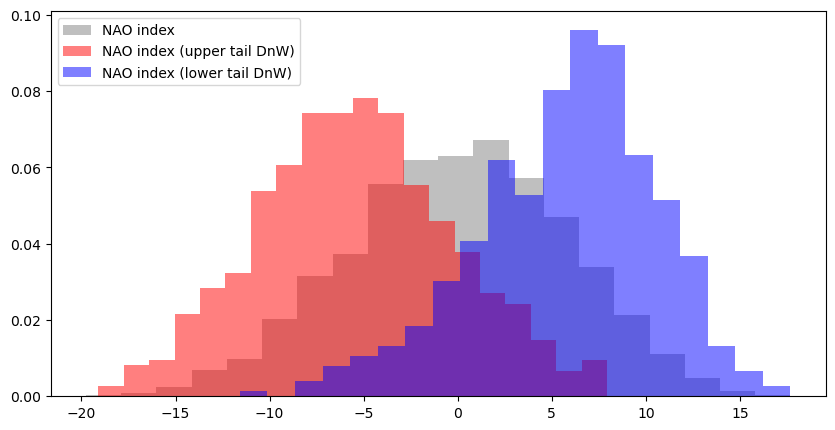

In [116]:
# set up a figure
plt.figure(figsize=(10, 5))

# plot the distribution of the nao index
plt.hist(df_model_exceedance_nao_delta_p["nao_index_hpa"], bins=20, color="grey", alpha=0.5, label="NAO index", density=True)

# Calculate the 90th percentile
percentile_90 = df_model_exceedance_nao_delta_p["no_exceedance_days_demand_net_wind"].quantile(0.90)
percentile_10 = df_model_exceedance_nao_delta_p["no_exceedance_days_demand_net_wind"].quantile(0.10)

# Subset the DataFrame to the upper tail where values are greater than the 90th percentile
df_model_exceedance_nao_delta_p_upper = df_model_exceedance_nao_delta_p[
    df_model_exceedance_nao_delta_p["no_exceedance_days_demand_net_wind"] > percentile_90
]

# Subset the df to the lower tail of the no exceedance days demand net wind
df_model_exceedance_nao_delta_p_lower = df_model_exceedance_nao_delta_p[
    df_model_exceedance_nao_delta_p["no_exceedance_days_demand_net_wind"] < percentile_10
]

# plot the distribution of the nao index for the upper tail
plt.hist(df_model_exceedance_nao_delta_p_upper["nao_index_hpa"], bins=20, color="red", alpha=0.5, label="NAO index (upper tail DnW)", density=True)

# plot the distribution of the nao index for the lower tail
plt.hist(df_model_exceedance_nao_delta_p_lower["nao_index_hpa"], bins=20, color="blue", alpha=0.5, label="NAO index (lower tail DnW)", density=True)

# set up the legend
plt.legend()

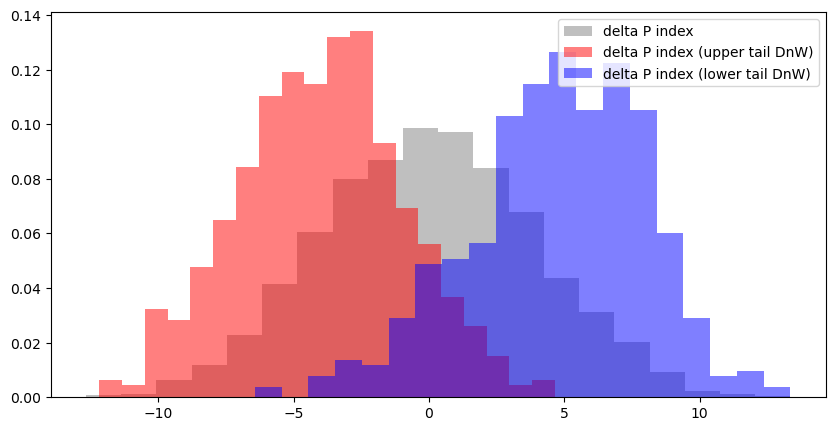

In [117]:
# set up a figure
plt.figure(figsize=(10, 5))

# plot the distribution of the nao index
plt.hist(df_model_exceedance_nao_delta_p["delta_p_hpa"], bins=20, color="grey", alpha=0.5, label="delta P index", density=True)

# plot the distribution of the nao index for the upper tail
plt.hist(df_model_exceedance_nao_delta_p_upper["delta_p_hpa"], bins=20, color="red", alpha=0.5, label="delta P index (upper tail DnW)", density=True)

# plot the distribution of the nao index for the lower tail
plt.hist(df_model_exceedance_nao_delta_p_lower["delta_p_hpa"], bins=20, color="blue", alpha=0.5, label="delta P index (lower tail DnW)", density=True)

# set up the legend
plt.legend()

In [ ]:
# Create some kind of arbitrary threshold for the NAO index
# e.g. nao positive about 

In [99]:
# drop effective dec year
df_model_exceedance_nao_delta_p.drop(columns="effective_dec_year", inplace=True)

In [95]:
# # subset the dataframe to only include the el nino years
# df_model_exceedance_nino34_en = df_model_exceedance_nino34[
#     df_model_exceedance_nino34["nino34"] == "EN"
# ]

# # Same for la nina
# df_model_exceedance_nino34_ln = df_model_exceedance_nino34[
#     df_model_exceedance_nino34["nino34"] == "LN"
# ]

# # Same for neutral
# df_model_exceedance_nino34_n = df_model_exceedance_nino34[
#     df_model_exceedance_nino34["nino34"] == "N"
# ]

In [96]:
# # reset the index of the dataframes
# df_model_exceedance_nino34_en.reset_index(drop=True, inplace=True)

In [97]:
# # Same for la nina
# df_model_exceedance_nino34_ln.reset_index(drop=True, inplace=True)

# # Same for neutral
# df_model_exceedance_nino34_n.reset_index(drop=True, inplace=True)

In [98]:
# # reset the index of the obs data
# df_exceedance_days_obs.reset_index(inplace=True)

In [100]:
# df_model_exceedance_nino34.head()

init_year  member  winter_year  severity_index_demand  \
0       1960       1            1               8.349354   
1       1960       1            2              30.571060   
2       1960       1            3              40.577661   
3       1960       1            4               4.076673   
4       1960       1            5              11.510319   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                        6.0                       46.931563   
1                       22.0                       68.247568   
2                       28.0                       19.736773   
3                       11.0                       33.757206   
4                       20.0                       28.429395   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                21.0            54.151586   
1                                22.0            35.703712   
2                                12.0            20.092229   
3                                16.0            21.906649   
4                                11.0            26.636936   

   no_undershoot_days_wind  effective_dec_year  nino34_index   uk_temp nino34  \
0                     30.0                1961      1.723616  1.310329     EN   
1                     23.0                1962     -0.351488  0.429445      N   
2                     19.0                1963     -1.005609  0.219321     LN   
3                     14.0                1964      0.091913  0.306391      N   
4                     19.0                1965      1.152664 -0.199013     EN   

  nino34_strength  
0          strong  
1         neutral  
2             mod  
3         neutral  
4             mod

In [105]:
# set up a new dataframe for looking at extreme decades
df_model_exceedance_nino34_decades = pd.DataFrame()

# Loop over the unique years
for y, year in tqdm(enumerate(np.unique(df_model_exceedance_nino34["init_year"]))):
    for m, member in enumerate(np.unique(df_model_exceedance_nino34["member"])):
        # subset the dataframe
        df_this = df_model_exceedance_nino34[
            (df_model_exceedance_nino34["init_year"] == year) &
            (df_model_exceedance_nino34["member"] == member)
        ]

        # # print df this
        # print(df_this)

        df_new_this = pd.DataFrame(
            {
                "init_year": [year],
                "member": [member],
                "no_exceedance_days_demand": [df_this["no_exceedance_days_demand"].sum()],
                "no_exceedance_days_demand_net_wind": [df_this["no_exceedance_days_demand_net_wind"].sum()],
                "no_undershoot_days_wind": [df_this["no_undershoot_days_wind"].sum()],
                "nino34_index": [df_this["nino34_index"].mean()],
                "uk_temp": [df_this["uk_temp"].mean()],
            }
        )

        # concat the dataframes
        df_model_exceedance_nino34_decades = pd.concat([df_model_exceedance_nino34_decades, df_new_this], ignore_index=True)

59it [00:00, 158.67it/s]


In [109]:
# categorise the nino34 index into EN, LN, N
df_model_exceedance_nino34_decades["nino34"] = np.where(
    df_model_exceedance_nino34_decades["nino34_index"] > 0.4,
    "EN",
    np.where(
        df_model_exceedance_nino34_decades["nino34_index"] < -0.4,
        "LN",
        "N",
    )
)

In [ ]:
df_model_exceedance_nino34_decades

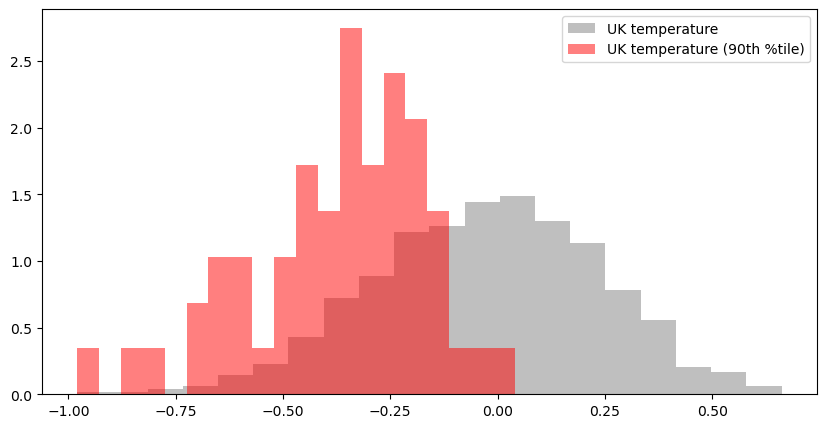

In [110]:
# set up a figure
plt.figure(figsize=(10, 5))

# plto a histogram of the distribution of UK temperature
plt.hist(df_model_exceedance_nino34_decades["uk_temp"], bins=20, color="grey", alpha=0.5, label="UK temperature", density=True)

# subset the df to values of no exceedance days demand net wind exceeding the 90th percentile
df_model_exceedance_nino34_decades_90 = df_model_exceedance_nino34_decades[
    df_model_exceedance_nino34_decades["no_exceedance_days_demand_net_wind"] > np.percentile(df_model_exceedance_nino34_decades["no_exceedance_days_demand_net_wind"], 90)
]

# plot the distribution of UK temperature for values of no exceedance days demand net wind exceeding the 90th percentile
plt.hist(df_model_exceedance_nino34_decades_90["uk_temp"], bins=20, color="red", alpha=0.5, label="UK temperature (90th %tile)", density=True)

# include a legend
plt.legend()

Look at the return periods for demand net wind extremes.

                          index  severity_index_demand  \
0 1970-01-01 00:00:00.000001960               0.008911   
1 1970-01-01 00:00:00.000001961              19.385662   
2 1970-01-01 00:00:00.000001962              93.614505   
3 1970-01-01 00:00:00.000001963               5.480202   
4 1970-01-01 00:00:00.000001964              14.515761   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                          1                       24.231988   
1                         19                       57.196654   
2                         54                      109.931359   
3                          8                       23.417931   
4                         19                       26.599745   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                  16            36.545218   
1                                  30            39.575294   
2                                  36            37.786112   
3                 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:55<00:00,  8.66it/s]


Model estimate for obs 99.9th %tile event: 95.3220480810679
Model estimate for obs 99.9th %tile event 2.5th percentile: 95.5098520497651
Model estimate for obs 99.9th %tile event 97.5th percentile: 95.16785766728246
Return period for obs 99.9th %tile event: 21.376876405097462
Return period for obs 99.9th %tile event 2.5th percentile: 22.270981069737026
Return period for obs 99.9th %tile event 97.5th percentile: 20.6947546480406


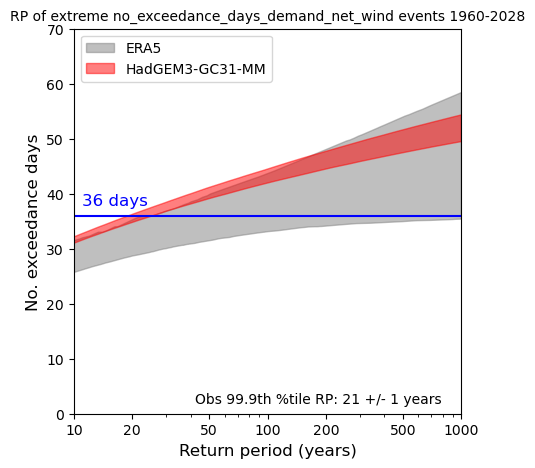

In [139]:
# For demand net wind - el nino conditions
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance_nino34_en,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
    ylim=(0, 70),
    percentile=99.9,
)

                          index  severity_index_demand  \
0 1970-01-01 00:00:00.000001960               0.008911   
1 1970-01-01 00:00:00.000001961              19.385662   
2 1970-01-01 00:00:00.000001962              93.614505   
3 1970-01-01 00:00:00.000001963               5.480202   
4 1970-01-01 00:00:00.000001964              14.515761   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                          1                       24.231988   
1                         19                       57.196654   
2                         54                      109.931359   
3                          8                       23.417931   
4                         19                       26.599745   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                  16            36.545218   
1                                  30            39.575294   
2                                  36            37.786112   
3                 

100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]


Model estimate for obs 99.9th %tile event: 95.88607320326307
Model estimate for obs 99.9th %tile event 2.5th percentile: 96.0867426659834
Model estimate for obs 99.9th %tile event 97.5th percentile: 95.75394682983048
Return period for obs 99.9th %tile event: 24.30767608196567
Return period for obs 99.9th %tile event 2.5th percentile: 25.554158968983263
Return period for obs 99.9th %tile event 97.5th percentile: 23.551283036808428


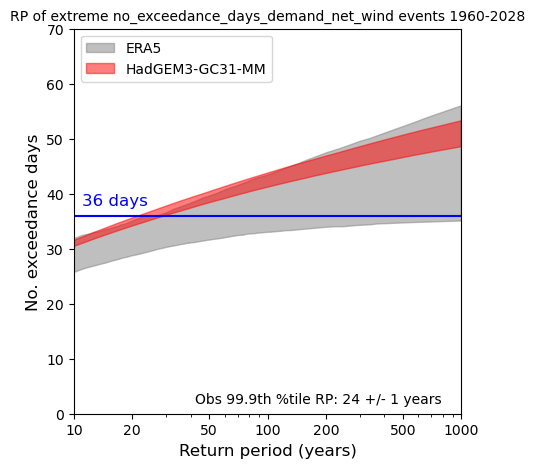

In [140]:
# same for la nina
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance_nino34_ln,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
    ylim=(0, 70),
    percentile=99.9,
)

                          index  severity_index_demand  \
0 1970-01-01 00:00:00.000001960               0.008911   
1 1970-01-01 00:00:00.000001961              19.385662   
2 1970-01-01 00:00:00.000001962              93.614505   
3 1970-01-01 00:00:00.000001963               5.480202   
4 1970-01-01 00:00:00.000001964              14.515761   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                          1                       24.231988   
1                         19                       57.196654   
2                         54                      109.931359   
3                          8                       23.417931   
4                         19                       26.599745   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                  16            36.545218   
1                                  30            39.575294   
2                                  36            37.786112   
3                 

100%|██████████| 1000/1000 [01:57<00:00,  8.53it/s]


Model estimate for obs 99.9th %tile event: 93.5372092218286
Model estimate for obs 99.9th %tile event 2.5th percentile: 93.86632441635709
Model estimate for obs 99.9th %tile event 97.5th percentile: 93.14356170772572
Return period for obs 99.9th %tile event: 15.473191602884329
Return period for obs 99.9th %tile event 2.5th percentile: 16.303438066838208
Return period for obs 99.9th %tile event 97.5th percentile: 14.584831910859362


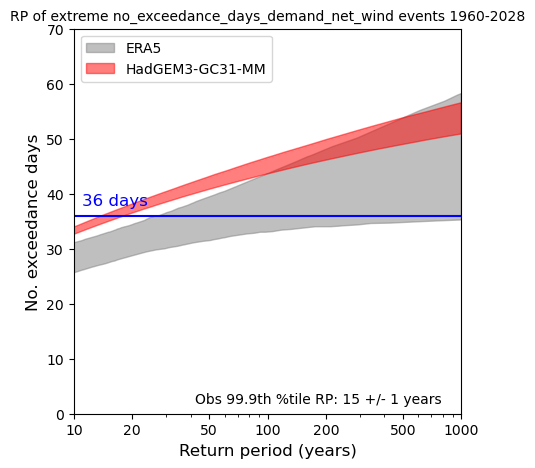

In [141]:
# same for neutral
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance_nino34_n,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
    ylim=(0, 70),
    percentile=99.9,
)

In [142]:
# subset the el nino dataframe to only include the strong el nino years
df_model_exceedance_nino34_en_strong = df_model_exceedance_nino34_en[
    df_model_exceedance_nino34_en["nino34_strength"] == "strong"
]

# same for la nina
df_model_exceedance_nino34_ln_strong = df_model_exceedance_nino34_ln[
    df_model_exceedance_nino34_ln["nino34_strength"] == "strong"
]

# print the len of these dataframes
print(len(df_model_exceedance_nino34_en_strong))
print(len(df_model_exceedance_nino34_ln_strong))

175
246


                          index  severity_index_demand  \
0 1970-01-01 00:00:00.000001960               0.008911   
1 1970-01-01 00:00:00.000001961              19.385662   
2 1970-01-01 00:00:00.000001962              93.614505   
3 1970-01-01 00:00:00.000001963               5.480202   
4 1970-01-01 00:00:00.000001964              14.515761   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                          1                       24.231988   
1                         19                       57.196654   
2                         54                      109.931359   
3                          8                       23.417931   
4                         19                       26.599745   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                  16            36.545218   
1                                  30            39.575294   
2                                  36            37.786112   
3                 

100%|██████████| 1000/1000 [01:14<00:00, 13.41it/s]


Model estimate for obs 99.9th %tile event: 97.60131449224416
Model estimate for obs 99.9th %tile event 2.5th percentile: 97.71039463534696
Model estimate for obs 99.9th %tile event 97.5th percentile: 97.69939984097017
Return period for obs 99.9th %tile event: 41.689500218625156
Return period for obs 99.9th %tile event 2.5th percentile: 43.675648888581904
Return period for obs 99.9th %tile event 97.5th percentile: 43.46691866794022


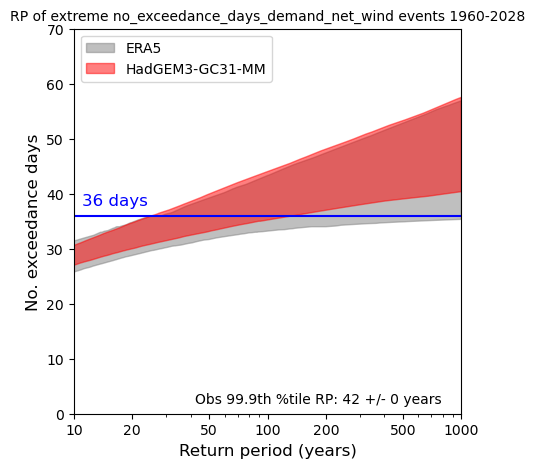

In [143]:
# For demand net wind - el nino conditions
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance_nino34_en_strong,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
    ylim=(0, 70),
    percentile=99.9,
)

                          index  severity_index_demand  \
0 1970-01-01 00:00:00.000001960               0.008911   
1 1970-01-01 00:00:00.000001961              19.385662   
2 1970-01-01 00:00:00.000001962              93.614505   
3 1970-01-01 00:00:00.000001963               5.480202   
4 1970-01-01 00:00:00.000001964              14.515761   

   no_exceedance_days_demand  severity_index_demand_net_wind  \
0                          1                       24.231988   
1                         19                       57.196654   
2                         54                      109.931359   
3                          8                       23.417931   
4                         19                       26.599745   

   no_exceedance_days_demand_net_wind  severity_index_wind  \
0                                  16            36.545218   
1                                  30            39.575294   
2                                  36            37.786112   
3                 

100%|██████████| 1000/1000 [01:17<00:00, 12.88it/s]


Model estimate for obs 99.9th %tile event: 96.86742962526847
Model estimate for obs 99.9th %tile event 2.5th percentile: 96.77843158540391
Model estimate for obs 99.9th %tile event 97.5th percentile: 97.09904871905711
Return period for obs 99.9th %tile event: 31.92266670419829
Return period for obs 99.9th %tile event 2.5th percentile: 31.040781113611008
Return period for obs 99.9th %tile event 97.5th percentile: 34.471451022609834


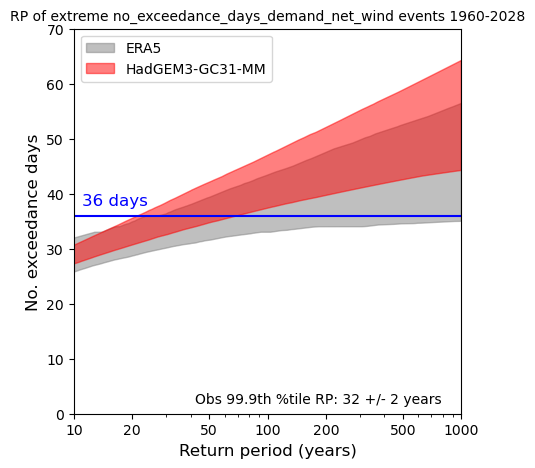

In [144]:
# for strong la ninas
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance_nino34_ln_strong,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    obs_time_name="index",
    model_time_name="effective_dec_year",
    ylim=(0, 70),
    percentile=99.9,
)

In [149]:
# Subset the dataframe to only include the no exceedance days demand net wind > 40
df_model_exceedance_40 = df_model_exceedance_nino34[
    df_model_exceedance_nino34["no_exceedance_days_demand_net_wind"] > 40
]

# same for 50
df_model_exceedance_50 = df_model_exceedance_nino34[
    df_model_exceedance_nino34["no_exceedance_days_demand_net_wind"] > 50
]

# same for 52
df_model_exceedance_52 = df_model_exceedance_nino34[
    df_model_exceedance_nino34["no_exceedance_days_demand_net_wind"] > 52
]

In [153]:
df_model_exceedance_48 = df_model_exceedance_nino34[
    df_model_exceedance_nino34["no_exceedance_days_demand_net_wind"] > 48
]

In [150]:
df_model_exceedance_40.head()

init_year  member  winter_year  severity_index_demand  \
10        1960       2            1             108.797195   
11        1960       2            2              50.119272   
109       1961       1           10              50.212735   
137       1961       4            8              59.893045   
206       1962       1            7              64.385285   

     no_exceedance_days_demand  severity_index_demand_net_wind  \
10                        42.0                      154.070366   
11                        48.0                      118.062663   
109                       40.0                      111.995511   
137                       43.0                      117.029615   
206                       38.0                      107.737750   

     no_exceedance_days_demand_net_wind  severity_index_wind  \
10                                 45.0            57.709959   
11                                 41.0            49.280796   
109                                41.0            48.363630   
137                                47.0            46.190060   
206                                41.0            69.962196   

     no_undershoot_days_wind  effective_dec_year  nino34_index   uk_temp  \
10                      38.0                1961      0.811740 -0.672734   
11                      30.0                1962      1.685112 -0.615535   
109                     30.0                1971     -0.044316 -1.066438   
137                     29.0                1969      1.297589 -0.838153   
206                     42.0                1969     -0.483879 -0.416496   

    nino34 nino34_strength  
10      EN             mod  
11      EN          strong  
109      N         neutral  
137     EN             mod  
206     LN            weak

In [151]:
df_model_exceedance_50.head()

init_year  member  winter_year  severity_index_demand  \
1106       1971       1            7              81.264833   
2136       1981       4            7              63.899802   
3284       1992       9            5              80.825128   
3289       1992       9           10             148.460337   
4345       2003       5            6              70.533711   

      no_exceedance_days_demand  severity_index_demand_net_wind  \
1106                       61.0                      165.150440   
2136                       58.0                      179.643210   
3284                       46.0                      158.297355   
3289                       96.0                      209.430519   
4345                       45.0                      138.465918   

      no_exceedance_days_demand_net_wind  severity_index_wind  \
1106                                60.0            76.227704   
2136                                51.0            80.153443   
3284                                54.0            65.630108   
3289                                51.0            68.731271   
4345                                52.0            80.924966   

      no_undershoot_days_wind  effective_dec_year  nino34_index   uk_temp  \
1106                     42.0                1978      0.381277 -1.046578   
2136                     45.0                1988      0.008758 -1.325274   
3284                     38.0                1997      0.912587 -1.418758   
3289                     38.0                2002      0.847694 -2.566214   
4345                     45.0                2009      0.832562 -1.085361   

     nino34 nino34_strength  
1106      N         neutral  
2136      N         neutral  
3284     EN             mod  
3289     EN             mod  
4345     EN             mod

In [154]:
df_model_exceedance_48.head()

init_year  member  winter_year  severity_index_demand  \
1106       1971       1            7              81.264833   
2136       1981       4            7              63.899802   
2511       1985       2            2              15.506606   
3089       1990       9           10              52.845550   
3174       1991       8            5              25.243238   

      no_exceedance_days_demand  severity_index_demand_net_wind  \
1106                       61.0                      165.150440   
2136                       58.0                      179.643210   
2511                       20.0                      107.974503   
3089                       38.0                      152.881069   
3174                       29.0                      124.369803   

      no_exceedance_days_demand_net_wind  severity_index_wind  \
1106                                60.0            76.227704   
2136                                51.0            80.153443   
2511                                50.0            82.764114   
3089                                50.0            72.002319   
3174                                49.0            60.631372   

      no_undershoot_days_wind  effective_dec_year  nino34_index   uk_temp  \
1106                     42.0                1978      0.381277 -1.046578   
2136                     45.0                1988      0.008758 -1.325274   
2511                     48.0                1987     -0.331319 -0.538925   
3089                     42.0                2000     -1.959986 -0.910844   
3174                     34.0                1996      0.496291 -0.829638   

     nino34 nino34_strength  
1106      N         neutral  
2136      N         neutral  
2511      N         neutral  
3089     LN          strong  
3174     EN            weak

Now we want to merge this with the df for demand net wind.

Run locally

In [72]:
exceedance_days = [20, 30, 40]
model_df = df_model_exceedance
model_val_name = "no_exceedance_days_demand_net_wind"
months = [10, 11, 12, 1, 2, 3]
psl_variable = "psl"
model = "HadGEM3-GC31-MM"
freq = "Amon"

In [73]:
import glob

# Set up a dictionary for the exceedance
exceed_dict = {}

# Loop over the exceedance days
for exceed_day in exceedance_days:
    # print the threshold
    print(f"Threshold: {exceed_day}")

    # Filter the model df to be only the 
    # days greater than the threshold
    model_df_exceedance = model_df[model_df[model_val_name] > exceed_day]

    # extract a list of len three tuples
    # containing the init year, member and winter year
    exceedance_list = list(zip(model_df_exceedance["init_year"], model_df_exceedance["winter_year"], model_df_exceedance["member"]))

    # Append the threshold to the dictionary
    exceed_dict[exceed_day] = exceedance_list

# Set up the base path for loading the numpy array
base_path = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/"

# if months = 10, 11, 12, 1, 2, 3
# then season is ONDJFM
if months == [10, 11, 12, 1, 2, 3]:
    season = "ONDJFM"
else:
    raise NotImplementedError("Only ONDJFM implemented")

# Form the path to the file dir
path = os.path.join(
    base_path,
    model,
    psl_variable,
    freq,
    season,
    "1960-2018", # hardcoded for now
)

# Form the fname
fname = f"{model}_{psl_variable}_{season}_{freq}_1960-2018.npy"

# # extract the other np array
years_file = glob.glob(os.path.join(path, "*_years.npy"))
members_file = glob.glob(os.path.join(path, "*_members.npy"))
leads_file = glob.glob(os.path.join(path, "*_leads.npy"))
lats_file = glob.glob(os.path.join(path, "*_lats.npy"))
lons_file = glob.glob(os.path.join(path, "*_lons.npy"))

# import the other np arrays
years = np.load(years_file[0])
members = np.load(members_file[0])
leads = np.load(leads_file[0])
lats = np.load(lats_file[0])
lons = np.load(lons_file[0])

# Form the output file shape
full_file_shape = (len(years), len(members), len(leads), len(lats), len(lons))

# Set up an intermediate time
start_time = time.time()

# If the file exists, import the file
if os.path.exists(os.path.join(path, fname)):
    print(f"Loading the file from {os.path.join(path, fname)}")

    # Load the numpy file
    composite = np.load(os.path.join(path, fname))
else:
    raise FileNotFoundError(f"File {os.path.join(path, fname)} does not exist")

# End the time
end_time = time.time()

# Calculate and print how long this has taken
duration = end_time - start_time
print(f"Time taken to load the file: {duration:.2f} seconds")

# print the shape of the composite
print(f"Shape of the composite: {composite.shape}")

Threshold: 20
Threshold: 30
Threshold: 40
Loading the file from /gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-2018/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-2018.npy
Time taken to load the file: 143.07 seconds
Shape of the composite: (59, 10, 125, 324, 432)


In [74]:
# Set up composite winter years
winter_years = np.arange(1, 10 + 1, 1)

# Set up the composite array
composite_array = np.zeros([len(years), len(members), len(winter_years), len(lats), len(lons)])

# print the shape of the composite array
print(composite_array.shape)

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the lead values to extract
    leads_values_this = np.arange((wyear * 12), (wyear * 12) + 6, 1)

    # Find the index of the lead values in leads
    idx = np.where(np.isin(leads, leads_values_this))[0]

    # Extract the values and take the mean along axis 2
    composite_mean = np.mean(composite[:, :, idx, :, :], axis=2)

    # Assign the mean values to the composite array
    composite_array[:, :, i, :, :] = composite_mean

(59, 10, 10, 324, 432)


In [75]:
composite_array.shape

(59, 10, 10, 324, 432)

In [76]:
# Set up a dictionary to store the arrsy
composite_dict = {}

# Loop over the thresholds in exceedance dict
for thresh in exceed_dict:
    # print the len of the exceed dict
    print(len(exceed_dict[thresh]))

    # Set up the composite array
    composite_array_thresh_this = np.zeros(
        [len(exceed_dict[thresh]), len(lats), len(lons)]
    )

    # Loop over the init_years, winter_year, members
    for i, (init_year, winter_year, member) in tqdm(enumerate(exceed_dict[thresh])):
        # Print the init year, winter year and member
        # print(f"init_year: {init_year}, winter_year: {winter_year}, member: {member}")

        # Find the index of the init year in years
        idx_year_this = np.where(years == init_year)[0][0]

        # Find the index of the member in members
        idx_member_this = np.where(members == member)[0][0]

        # Find the index of the winter year in winter years
        idx_winter_this = np.where(winter_years == winter_year)[0][0]

        # print the idx year, member and winter
        # print(f"idx_year: {idx_year_this}, idx_member: {idx_member_this}, idx_winter: {idx_winter_this}")

        # Assign the values to the composite array
        composite_array_thresh_this[i, :, :] = composite_array[
            idx_year_this, idx_member_this, idx_winter_this, :, :
        ]

    # Assign the composite array to the dictionary
    composite_dict[thresh] = composite_array_thresh_this

744


744it [00:00, 2111.68it/s]


73


73it [00:00, 2229.97it/s]


3


3it [00:00, 6750.49it/s]


In [79]:
composite_dict[30].shape

(73, 324, 432)

Now calculate a 30 year climatology to remove

E.g. 1990-2018, all members, all winter years

In [80]:
# Set up the years for the climatology
years_clim = np.arange(1990, 2018 + 1, 1)

# Find the index of the years in the years array
idx_years_clim = np.where(np.isin(years, years_clim))[0]

# Extract the values from the composite array
composite_clim = np.mean(composite_array[idx_years_clim, :, :, :, :], axis=(0, 1, 2))

Now do the bootstrapping

In [81]:
# Reshape data to be 3d
# Multiply init years * members * winter years
reshaped_composite_arr = composite_array.reshape(
    composite_array.shape[0] * composite_array.shape[1] * composite_array.shape[2],
    composite_array.shape[3],
    composite_array.shape[4],
)

In [82]:
reshaped_composite_arr[0]

array([[100214.9765625, 100214.4921875, 100213.9375   , ...,
        100216.5      , 100215.9765625, 100215.4453125],
       [100141.7109375, 100140.4296875, 100139.15625  , ...,
        100145.6484375, 100144.3515625, 100143.0078125],
       [100062.5703125, 100060.8203125, 100060.28125  , ...,
        100079.3359375, 100079.03125  , 100076.6328125],
       ...,
       [102317.84375  , 102317.3046875, 102316.7265625, ...,
        102319.3203125, 102318.8671875, 102318.3671875],
       [102274.6640625, 102274.3125   , 102273.9609375, ...,
        102275.6015625, 102275.28125  , 102274.9921875],
       [102233.5078125, 102233.4140625, 102233.28125  , ...,
        102233.8203125, 102233.71875  , 102233.625    ]])

In [83]:
# Set up a dictionary for compoosite anomalies
composite_anoms_dict = {}

# Qunatify both as anomalies
for thresh in composite_dict:
    composite_array_this = composite_dict[thresh]

    # Take the mean over the first dimension
    composite_anoms_this = np.mean(composite_array_this, axis=0) - composite_clim

    # Assign to the dictionary
    composite_anoms_dict[thresh] = composite_anoms_this

# Quantify the composite anomalies
reshaped_composite_arr_anoms = reshaped_composite_arr - composite_clim

In [84]:
reshaped_composite_arr_anoms.shape

(5900, 324, 432)

In [85]:
composite_anoms_dict[40].shape

(324, 432)

In [86]:
# Divide both by 100 to get in hPa
for thresh in composite_anoms_dict:
    composite_anoms_dict[thresh] = composite_anoms_dict[thresh] / 100

# Divide reshaped composite array by 100
reshaped_composite_arr_anoms = reshaped_composite_arr_anoms / 100

In [87]:
import random

# Set up the nboot
nboot = 1000

# Set up the index for the model data to be bootstrapped
index_ens = range(reshaped_composite_arr_anoms.shape[0])

# Set up an empty dict for the composite means
composite_means_dict = {}

for thresh in composite_dict:
    print(f"Processing threshold {thresh}")
    
    # Find the n events
    n_events_this = composite_dict[thresh].shape[0]

    # print the n events
    print(f"n events: {n_events_this}")

    # Set up an empty array for the bootstrapped means
    composite_means_this = np.zeros([nboot, composite_dict[thresh].shape[1], composite_dict[thresh].shape[2]])

    # Loop over the nboot
    for iboot in tqdm(range(nboot)):
        # Set up the random indices
        ind_ens_this = np.array([random.choice(index_ens) for i in range(n_events_this)])

        # Take the mean over the random indices
        composite_means_this[iboot, :, :] = np.mean(reshaped_composite_arr_anoms[ind_ens_this, :, :], axis=0)

    # Assign to the dictionary
    composite_means_dict[thresh] = composite_means_this

Processing threshold 20
n events: 744


  0%|          | 1/1000 [00:39<10:54:15, 39.29s/it]


KeyboardInterrupt: 

In [136]:
composite_means_dict[40].shape

(1000, 324, 432)

Now process the p values from this

E.g. value of 1 if the event mean lies outside of the 2.5th or 97.5th percentile.

value of 0 is the event means lies between the 2.5th and 97.5th percentile.

In [140]:
# Set up a p value dict
p_value_dict = {}

# Loop over the thresholds
for thresh in composite_means_dict:
    print(f"Processing threshold {thresh}")

    # Set up the composite means
    composite_means_this = composite_means_dict[thresh]

    # Set up the composite anomalies
    composite_anoms_this = composite_anoms_dict[thresh]

    # Set up the p values
    p_values_this = np.zeros([composite_means_this.shape[1], composite_means_this.shape[2]])

    # Loop over the lats
    for ilat in tqdm(range(composite_means_this.shape[1])):
        # Loop over the lons
        for ilon in range(composite_means_this.shape[2]):
            # Calculate the 2.5th and 97.5th percentiles
            lower_025 = np.percentile(composite_means_this[:, ilat, ilon], 2.5)
            higher_975 = np.percentile(composite_means_this[:, ilat, ilon], 97.5)

            # E.g. value of 1 if the event mean lies outside of the 2.5th or 97.5th percentile.
            # value of 0 is the event means lies between the 2.5th and 97.5th percentile.
            if composite_anoms_this[ilat, ilon] < lower_025 or composite_anoms_this[ilat, ilon] > higher_975:
                p_values_this[ilat, ilon] += 1
            else:
                p_values_this[ilat, ilon] += 0

    # Assign to the p value dict
    p_value_dict[thresh] = p_values_this

Processing threshold 35


100%|██████████| 324/324 [00:16<00:00, 20.06it/s]


Processing threshold 38


100%|██████████| 324/324 [00:16<00:00, 19.90it/s]


Processing threshold 40


100%|██████████| 324/324 [00:16<00:00, 20.20it/s]


In [142]:
# loop over the thresholds and print the sum of the p values
for thresh in p_value_dict:
    print(f"Threshold {thresh}")
    print(np.sum(p_value_dict[thresh]))

Threshold 35
31129.0
Threshold 38
23016.0
Threshold 40
19768.0


In [145]:
# print the lons
# convert the lons from 0-360 to -180 to 180
lons_conv = np.where(lons > 180, lons - 360, lons)

In [150]:
lons_conv.max()

np.float64(179.5833282470703)

In [151]:
# All imports for plotting
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

In [155]:
test = composite_anoms_dict[40]

In [156]:
test

(324, 432)

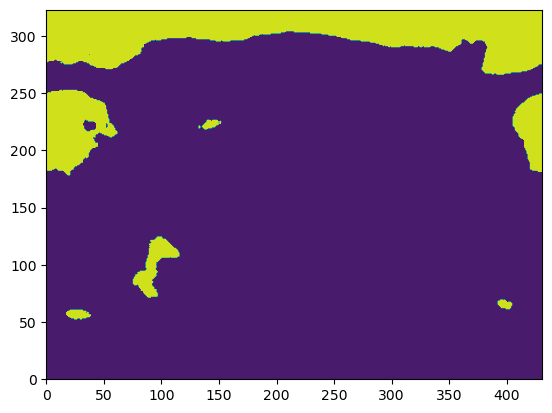

In [175]:
plt.contourf(p_value_dict[40])

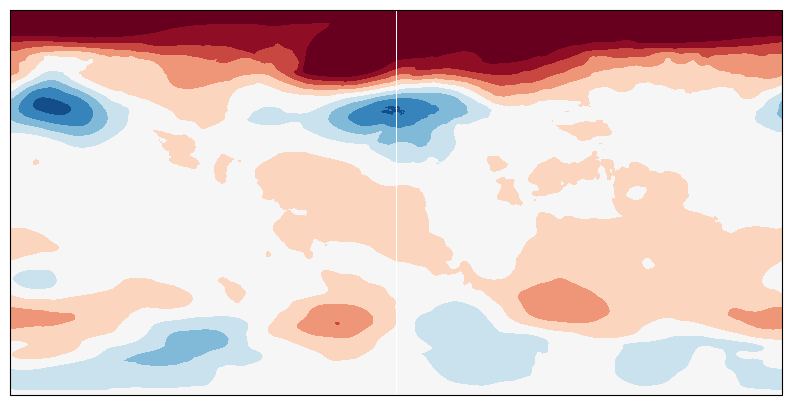

In [169]:
# make a simmple plot with test
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)

# Set up the contour levels
clevs = np.arange(-5, 5, 1)

# Set up the contourf
cf = ax.contourf(
    lons,
    lats,
    test,
    levels=clevs,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree(),
)

[[0.17307524 0.17288227 0.17277    ... 0.17332375 0.17314577 0.17320318]
 [0.14255678 0.14223383 0.14189258 ... 0.14358063 0.14332024 0.1429448 ]
 [0.14593378 0.14557189 0.14522179 ... 0.14728056 0.14681289 0.14639627]
 ...
 [2.87178173 2.87078598 2.86977141 ... 2.87449887 2.87362808 2.87268619]
 [2.79723148 2.79654444 2.79587301 ... 2.79908746 2.79848686 2.79781898]
 [2.72593388 2.72570765 2.72544746 ... 2.726624   2.7264087  2.72616844]]
[[-0.30134663 -0.30169585 -0.30182896 ... -0.30090541 -0.3012136
  -0.3012187 ]
 [-0.30146926 -0.30246409 -0.30333658 ... -0.29918499 -0.29980997
  -0.30058645]
 [-0.28115997 -0.28226665 -0.28321571 ... -0.2779434  -0.2791142
  -0.28012977]
 ...
 [ 4.90776611  4.91127557  4.91460474 ...  4.89768637  4.90102912
   4.90433723]
 [ 4.95134607  4.95317465  4.95499801 ...  4.94599892  4.9477004
   4.94946482]
 [ 4.99281409  4.99331703  4.99385892 ...  4.99123338  4.99176808
   4.99229865]]
[[-0.82299767 -0.82309168 -0.82300604 ... -0.82291062 -0.82297923
 

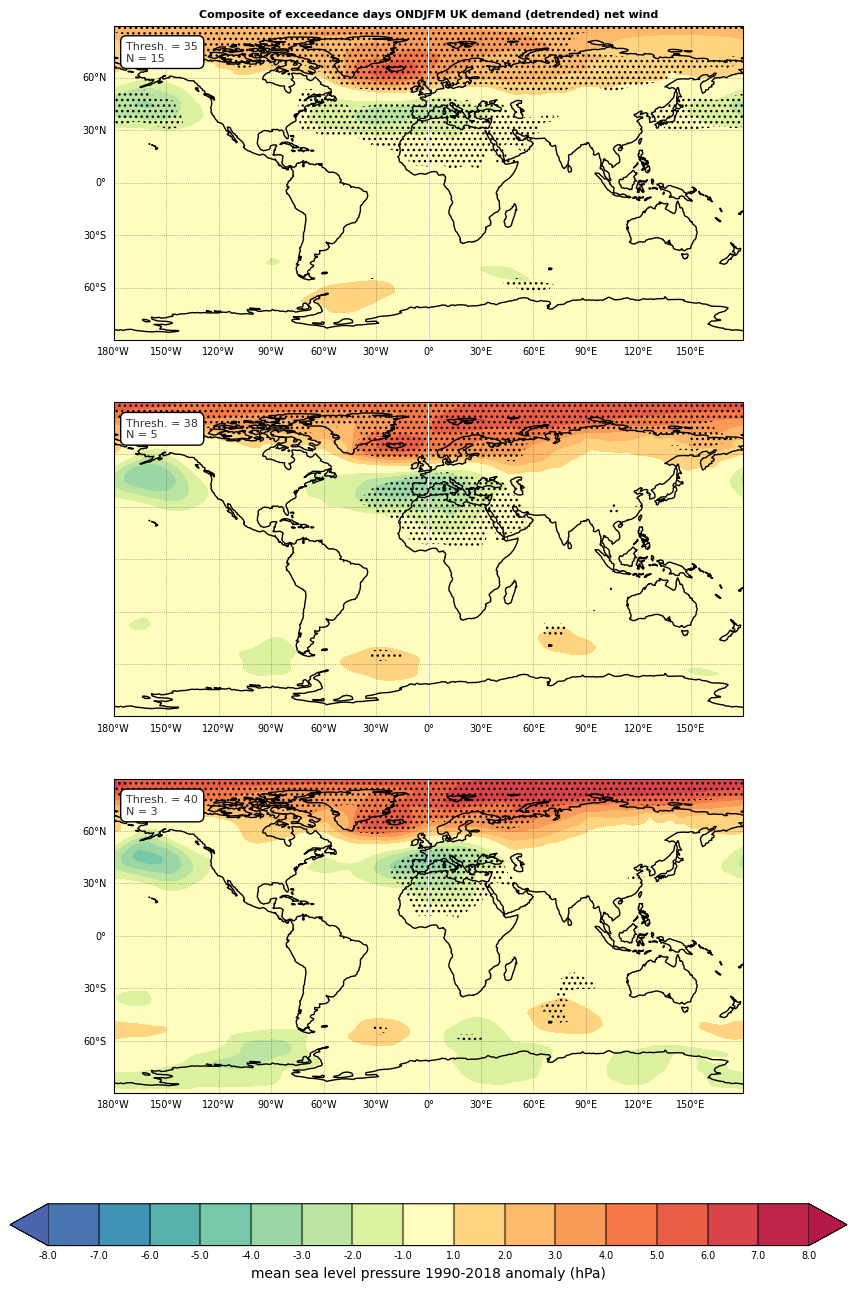

In [176]:
# # N events from tqdm above
n_events_list = [15, 5, 3]

# hard code the climatology period
climatology_period = (1990, 2018)

# Set up the figure as 3 rows and 1 column
fig, axs = plt.subplots(
    3, 1, figsize=(12, 18), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Assuming we are plotting anoms
clevs = np.array(
    [
        -8.0,
        -7.0,
        -6.0,
        -5.0,
        -4.0,
        -3.0,
        -2.0,
        -1.0,
        1.0,
        2.0,
        3.0,
        4.0,
        5.0,
        6.0,
        7.0,
        8.0,
    ]
)
ticks = clevs

# ensure that these are floats
clevs = clevs.astype(float)
ticks = ticks.astype(float)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# loop over the fields
for i, thresh in enumerate(composite_anoms_dict.keys()):
    
    # Extract the field for this
    field_this = composite_anoms_dict[thresh]

    # print the field this
    print(field_this)

    mymap = axs[i].contourf(
        lons,
        lats,
        field_this,
        clevs,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
    )

    # # contour lines
    # contours = axs[i].contour(
    #     lons,
    #     lats,
    #     field_this,
    #     clevs,
    #     colors="black",
    #     transform=ccrs.PlateCarree(),
    #     linewidth=0.2,
    #     alpha=0.5,
    # )

    # Set the labels for the contours
    axs[i].clabel(
        contours,
        clevs,
        fmt="%.4g",
        fontsize=8,
        inline=True,
        inline_spacing=0.0,
    )

for i, ax in enumerate(axs):
    # Set up the number of events
    num_event = n_events_list[i]

    # Set up the threshold
    thresh = list(composite_anoms_dict.keys())[i]

    # add coastlines
    ax.coastlines()

    # format the gridlines and labels
    gl = ax.gridlines(
        draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
    )
    gl.xlabels_top = False
    gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {"size": 7, "color": "black"}
    gl.ylabels_right = False
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {"size": 7, "color": "black"}

    # get rid of the top labels
    gl.top_labels = False

    # get rid of the right labels
    gl.right_labels = False

    # if the iteration is 1
    if i == 1:
        gl.left_labels = False

    # include a textbox in the top left
    ax.text(
        0.02,
        0.95,
        f"""Thresh. = {thresh}\nN = {num_event}""",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        color="black",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
        alpha=0.8,
    )

    # ===================================
    # TODO: add significance p-field here
    # ===================================

    # Extract the pfield for this
    pfield_this = p_value_dict[thresh]

    # Where pfield_this is zero, set to nan
    pfield_this = np.where(pfield_this == 0, np.nan, pfield_this)

    # # plot the pfield
    axs[i].contourf(
        lons,
        lats,
        pfield_this,
        transform=ccrs.PlateCarree(),
        hatches=["..."],
        alpha=0.0,
    )


# Set up the colorbar
cbar = fig.colorbar(
    mymap,
    ax=axs,
    orientation="horizontal",
    shrink=0.9,
    pad=0.08,
    format=FuncFormatter(format_func_one_decimal),
)
# add colorbar label
cbar.set_label(
    f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
    rotation=0,
    fontsize=10,
)

# add contour lines to the colorbar
cbar.add_lines(contours)

# Set up the title
axs[0].set_title(
    "Composite of exceedance days ONDJFM UK demand (detrended) net wind",
    fontsize=8,
    fontweight="bold",
)

cbar.ax.tick_params(labelsize=7, length=0)
cbar.set_ticks(ticks)

In [137]:
# All imports for plotting
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

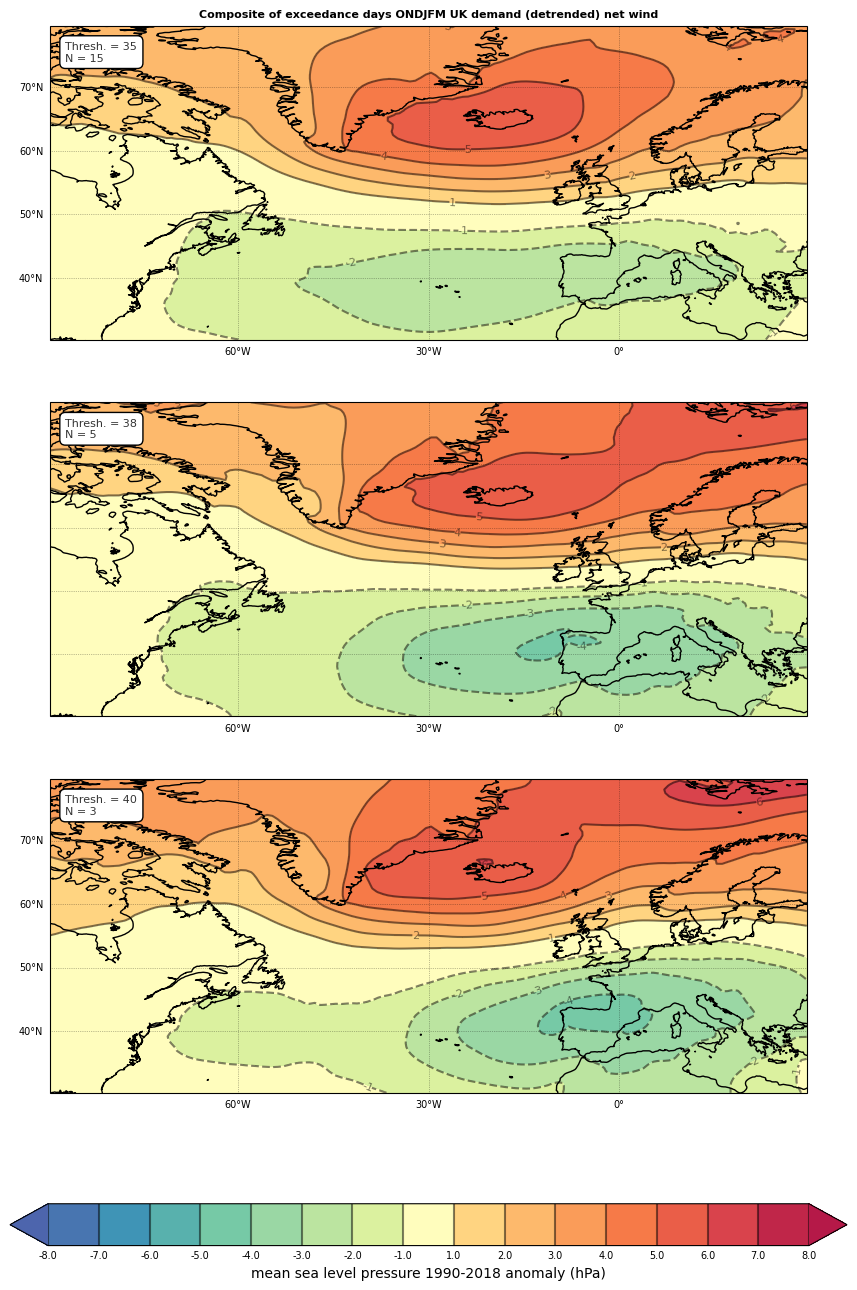

In [138]:
# N events from tqdm above
n_events_list = [15, 5, 3]

# hard code the climatology period
climatology_period = (1990, 2018)

# Set up the figure as 3 rows and 1 column
fig, axs = plt.subplots(
    3, 1, figsize=(12, 18), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Assuming we are plotting anoms
clevs = np.array(
    [
        -8.0,
        -7.0,
        -6.0,
        -5.0,
        -4.0,
        -3.0,
        -2.0,
        -1.0,
        1.0,
        2.0,
        3.0,
        4.0,
        5.0,
        6.0,
        7.0,
        8.0,
    ]
)
ticks = clevs

# ensure that these are floats
clevs = clevs.astype(float)
ticks = ticks.astype(float)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# loop over the fields
for i, thresh in enumerate(fields.keys()):
    mymap = axs[i].contourf(
        lons,
        lats,
        fields[thresh],
        clevs,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
    )

    # contour lines
    contours = axs[i].contour(
        lons,
        lats,
        fields[thresh],
        clevs,
        colors="black",
        transform=ccrs.PlateCarree(),
        linewidth=0.2,
        alpha=0.5,
    )

    # Set the labels for the contours
    axs[i].clabel(
        contours,
        clevs,
        fmt="%.4g",
        fontsize=8,
        inline=True,
        inline_spacing=0.0,
    )

for i, ax in enumerate(axs):
    # Set up the number of events
    num_event = n_events_list[i]

    # Set up the threshold
    thresh = list(fields.keys())[i]

    # add coastlines
    ax.coastlines()

    # format the gridlines and labels
    gl = ax.gridlines(
        draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
    )
    gl.xlabels_top = False
    gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {"size": 7, "color": "black"}
    gl.ylabels_right = False
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {"size": 7, "color": "black"}

    # get rid of the top labels
    gl.top_labels = False

    # get rid of the right labels
    gl.right_labels = False

    # if the iteration is 1
    if i == 1:
        gl.left_labels = False

    # include a textbox in the top left
    ax.text(
        0.02,
        0.95,
        f"""Thresh. = {thresh}\nN = {num_event}""",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        color="black",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
        alpha=0.8,
    )

    # ===================================
    # TODO: add significance p-field here
    # ===================================

# Set up the colorbar
cbar = fig.colorbar(
    mymap,
    ax=axs,
    orientation="horizontal",
    shrink=0.9,
    pad=0.08,
    format=FuncFormatter(format_func_one_decimal),
)
# add colorbar label
cbar.set_label(
    f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
    rotation=0,
    fontsize=10,
)

# add contour lines to the colorbar
cbar.add_lines(contours)

# Set up the title
axs[0].set_title(
    "Composite of exceedance days ONDJFM UK demand (detrended) net wind",
    fontsize=8,
    fontweight="bold",
)

cbar.ax.tick_params(labelsize=7, length=0)
cbar.set_ticks(ticks)

In [11]:
# test the bootstrapping
test_file = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-1961/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-1961.npy"
test_file_lats = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-1961/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-1961_lats.npy"
test_file_lons = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-1961/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-1961_lons.npy"

# load the data
test_data = np.load(test_file)
test_lats = np.load(test_file_lats)
test_lons = np.load(test_file_lons)

# print the data
print(test_data.shape)
print(test_lats.shape)
print(test_lons.shape)

# subset and take the mean over the winters
# e.g. mean over indices [12, 13, 14, 15, 16, 17]
# [24, 25, 26, 27, 28, 29]
# [36, 37, 38, 39, 40, 41]
winter_years = np.arange(1, 10 + 1, 1)

# set up the new shape for the test data
new_test_data = np.zeros([test_data.shape[0], 10, len(winter_years), test_data.shape[3], test_data.shape[4]])

# print the shape of the test data
print(new_test_data.shape)

# # loop over the winter years
for i, year in enumerate(winter_years):
    # print the index
    print("index: ", i)
    
    # Set up the leads to extract
    leads_idx_this = np.arange((year * 12) - 1, (year * 12) - 1 + 6, 1)

    # print the shape of the leads idx this
    print(new_test_data[:, :, i, :, :].shape)
    print(new_test_data.shape)

    # print the shape of the test data
    print(test_data[:, :, leads_idx_this, :, :].shape)

    new_test_data[:, :, i, :, :] = np.mean(test_data[:, :, leads_idx_this, :, :], axis=2)

# # if test lons does not contain negative values, and the model lons do
# if not np.any(test_lons < 0) and np.any(lons > 0):
#     # print that we are converting the test lons to -180 to 180
#     print("Converting test lons to -180 to 180")

#     # convert the test lons to -180 to 180
#     test_lons = np.where(test_lons > 180, test_lons - 360, test_lons)

# # Find the indices of the test lats and test lons
# # which orrespond to the model lats and lons
# lats_idxs = np.argmin(np.abs(test_lats[:, None] - lats), axis=0)
# lons_idxs = np.argmin(np.abs(test_lons[:, None] - lons), axis=0)

# # # print the lats indices
# # print(lats_idxs)

# # subset the test lats to the model lats
# test_lats_subset = test_lats[lats_idxs]
# test_lons_subset = test_lons[lons_idxs]

# # print the model lats
# # print(lats)
# # print(test_lats_subset)

# # # print the model lons
# # print(lons)
# # print(test_lons_subset)

# # apply the indices to the test data
# test_data_subset = new_test_data[:, :, lats_idxs, :][:, :, :, lons_idxs]

# # print the shape of the test data subset
# print(test_data_subset.shape)

(2, 10, 125, 324, 432)
(324,)
(432,)
(2, 10, 10, 324, 432)
index:  0
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  1
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  2
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  3
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  4
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  5
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  6
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  7
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  8
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  9
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)


In [13]:
new_test_data.shape

(2, 10, 10, 324, 432)

In [15]:
test_lons

array([-179.58332825, -178.75      , -177.91667175, -177.08332825,
       -176.25      , -175.41667175, -174.58332825, -173.75      ,
       -172.91667175, -172.08332825, -171.25      , -170.41667175,
       -169.58332825, -168.75      , -167.91667175, -167.08332825,
       -166.25      , -165.41667175, -164.58332825, -163.75      ,
       -162.91667175, -162.08332825, -161.25      , -160.41667175,
       -159.58332825, -158.75      , -157.91667175, -157.08332825,
       -156.25      , -155.41667175, -154.58332825, -153.75      ,
       -152.91667175, -152.08332825, -151.25      , -150.41667175,
       -149.58332825, -148.75      , -147.91667175, -147.08332825,
       -146.25      , -145.41667175, -144.58332825, -143.75      ,
       -142.91667175, -142.08332825, -141.25      , -140.41667175,
       -139.58332825, -138.75      , -137.91667175, -137.08332825,
       -136.25      , -135.41667175, -134.58332825, -133.75      ,
       -132.91667175, -132.08332825, -131.25      , -130.41667

In [14]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import importlib

sys.path.append("/home/users/benhutch/unseen_functions/")
import functions

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

In [22]:
calc_anoms = False

NameError: name 'title' is not defined

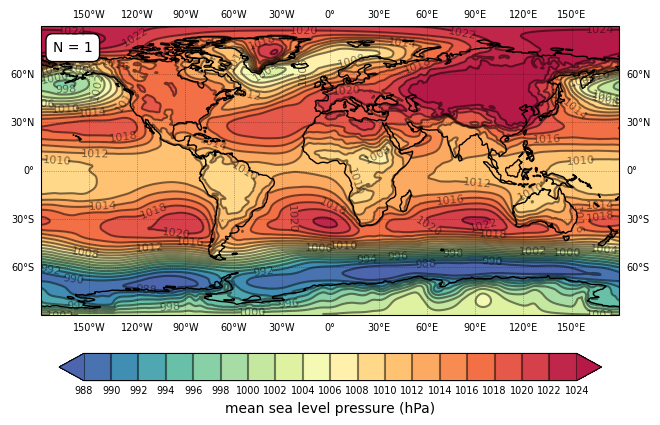

In [26]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Set up the field
field = new_test_data[0, 0, 0, :, :]

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    clevs = np.array(np.arange(988, 1024 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"test_lons shape: {test_lons.shape}")
# print(f"test_lats shape: {test_lats.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    test_lons, test_lats, field / 100, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
contours = ax.contour(
    test_lons,
    test_lats,
    field / 100,
    clevs,
    colors="black",
    transform=ccrs.PlateCarree(),
    linewidth=0.2,
    alpha=0.5,
)
if calc_anoms:
    ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)
else:
    ax.clabel(contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0)

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# # set up the num events
# num_events = len(cube_psl.coord("number").points)
num_events = 1

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()

In [2]:
# Test the ocean files
base_dir = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/tos/Omon/ONDJFM/1960-1960"

# Set up the fnames
fnames = [
    "HadGEM3-GC31-MM_tos_ONDJFM_Omon_1960-1960.npy",
    "HadGEM3-GC31-MM_tos_ONDJFM_Omon_1960-1960_lats.npy",
    "HadGEM3-GC31-MM_tos_ONDJFM_Omon_1960-1960_lons.npy",
]

# Imoprt the data
tos_data = np.load(os.path.join(base_dir, fnames[0]))
tos_lats = np.load(os.path.join(base_dir, fnames[1]))
tos_lons = np.load(os.path.join(base_dir, fnames[2]))

In [4]:
# Subset to winter years
tos_data.shape

wyear_tos_data = np.zeros([tos_data.shape[0], 10, tos_data.shape[2], tos_data.shape[3]])

# loop over the winter years
for i, year in enumerate(np.arange(1, 10 + 1, 1)):
    # Set up the leads to extract
    leads_idx_this = np.arange((year * 12) - 1, (year * 12) - 1 + 6, 1)

    wyear_tos_data[:, i, :, :] = np.mean(tos_data[:, leads_idx_this, :, :], axis=1)

In [5]:
# print the min and max of wyer tos data
# assert that not all values of tos data are nan
assert not np.all(np.isnan(wyear_tos_data)), "All values of wyear_tos_data are nan"

In [6]:
# print the max of wyear_tos_data (it contains nans)
print(np.nanmax(wyear_tos_data))
print(np.nanmin(wyear_tos_data))

33.86183166503906
-2.1040632724761963


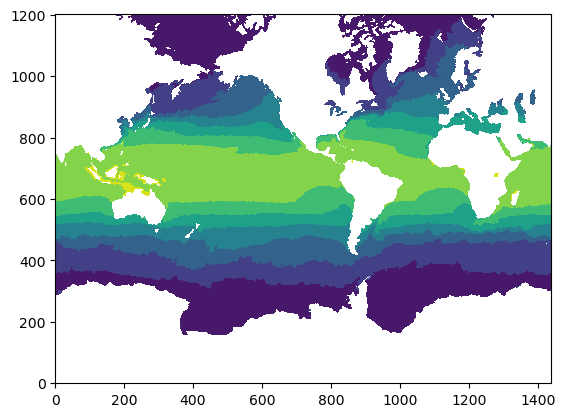

In [8]:
plt.contourf(wyear_tos_data[0, 0, :, :])

In [9]:
tos_lons.shape

(1205, 1440)

In [10]:
field.shape

NameError: name 'field' is not defined

In [17]:
tos_lons_1d = tos_lons[0, :]
tos_lats_1d = tos_lats[:, 0]

# print the shape of these
print(tos_lons_1d.shape)
print(tos_lats_1d.shape)

(1440,)
(1205,)


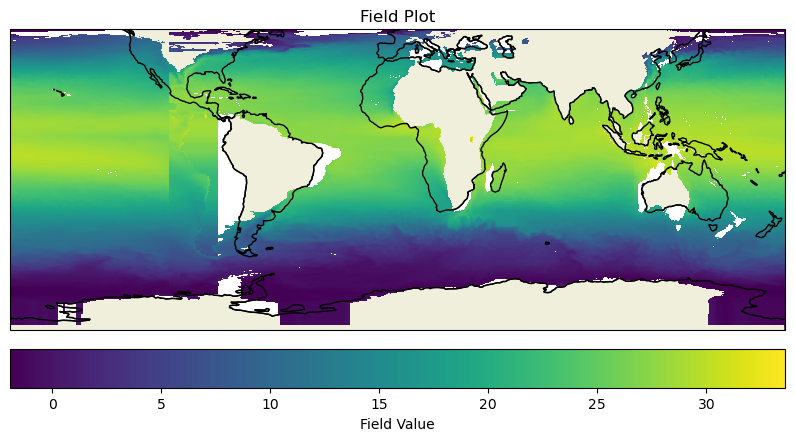

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assuming tos_lats and tos_lons are 2D arrays with shape (1205, 1440)
# Convert tos_lats and tos_lons to 1D arrays
# tos_lats_1d = tos_lats[:, 0]  # Take the first column
# tos_lons_1d = tos_lons[0, :]  # Take the first row

# Create a figure and axis with a specific projection
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and other features
ax.coastlines()
# ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
# ax.add_feature(cfeature.OCEAN)

# Plot the data using pcolormesh
mesh = ax.pcolormesh(tos_lons_1d, tos_lats_1d, field, transform=ccrs.PlateCarree(), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Field Value')

# Set the title
ax.set_title('Field Plot')

# Show the plot
plt.show()

In [31]:
import iris

# Set up the test file
fname = "tos_Omon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1p1f2_gn_196011-196012.nc"

# set up the dir
dir = "/badc/cmip6/data/CMIP6/DCPP/MOHC/HadGEM3-GC31-MM/dcppA-hindcast/s1960-r1i1p1f2/Omon/tos/gn/files/d20200417/"

# assert that this file exists
assert os.path.exists(os.path.join(dir, fname)), "File does not exist"

# import this file
test_cube = iris.load_cube(os.path.join(dir, fname))

In [37]:
test_cube.coords()

[<DimCoord: time / (days since 1850-01-01)  [1960-11-16 00:00:00, ...]+bounds  shape(2,)>,
 <DimCoord: cell index along second dimension / (1)  [0, ...]  shape(1205,)>,
 <DimCoord: cell index along first dimension / (1)  [ 0, 1, ..., 1438, 1439]  shape(1440,)>,
 <AuxCoord: latitude / (degrees)  <lazy>+bounds  shape(1205, 1440)>,
 <AuxCoord: longitude / (degrees)  <lazy>+bounds  shape(1205, 1440)>]

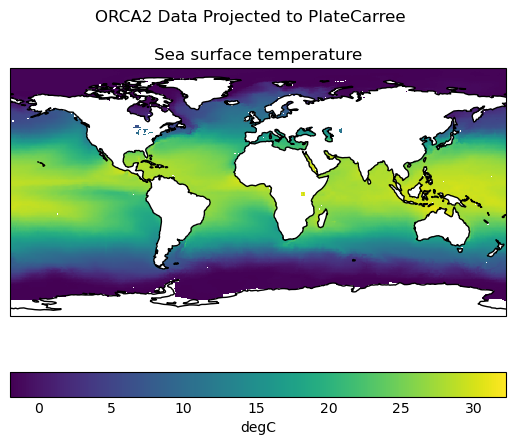

In [41]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.quickplot as qplt


# Choose plot projections
projections = {}
projections["Mollweide"] = ccrs.Mollweide()
projections["PlateCarree"] = ccrs.PlateCarree()
projections["NorthPolarStereo"] = ccrs.NorthPolarStereo()
projections["Orthographic"] = ccrs.Orthographic(
    central_longitude=-90, central_latitude=45
)

test_cube_2d = test_cube[0, :, :]

pcarree = projections["PlateCarree"]
# Transform cube to target projection
new_cube, extent = iris.analysis.cartography.project(test_cube_2d, pcarree, nx=400, ny=200)

fig = plt.figure()
fig.suptitle("ORCA2 Data Projected to {}".format("PlateCarree"))
# Set up axes and title
ax = plt.subplot(projection=projections["PlateCarree"])
# Set limits
ax.set_global()
# plot with Iris quickplot pcolormesh
qplt.pcolormesh(new_cube)
# Draw coastlines
ax.coastlines()

iplt.show()

In [60]:
def _get_lon_lat_coords(cube):
    lat_coords = [
        coord for coord in cube.coords() if "latitude" in coord.name()
    ]
    lon_coords = [
        coord for coord in cube.coords() if "longitude" in coord.name()
    ]
    if len(lat_coords) > 1 or len(lon_coords) > 1:
        raise ValueError(
            "Calling `_get_lon_lat_coords` with multiple lat or lon coords"
            " is currently disallowed"
        )
    lat_coord = lat_coords[0]
    lon_coord = lon_coords[0]
    return (lon_coord, lat_coord)


lon_coord, lat_coord = _get_lon_lat_coords(test_cube)

In [70]:
lat_coord

<AuxCoord: latitude / (degrees)  [...]+bounds  shape(1205, 1440)>

In [73]:
target_proj = ccrs.PlateCarree()

source_x = lon_coord.points
source_y = lat_coord.points

# Determine source coordinate system
if lat_coord.coord_system is None:
    # Assume WGS84 latlon if unspecified
    warnings.warn(
        "Coordinate system of latitude and longitude "
        "coordinates is not specified. Assuming WGS84 Geodetic."
    )
    orig_cs = iris.coord_systems.GeogCS(
        semi_major_axis=6378137.0, inverse_flattening=298.257223563
    )
else:
    orig_cs = lat_coord.coord_system

source_cs = orig_cs.as_cartopy_crs()

# Calculate target grid
target_cs = None
if isinstance(target_proj, iris.coord_systems.CoordSystem):
    target_cs = target_proj
    target_proj = target_proj.as_cartopy_projection()

target_x, target_y, extent = cartopy.img_transform.mesh_projection(
    target_proj, nx, ny
)

In [77]:
xdim = 1
ydim = 0

nx=400
ny=200

import numpy as np
import cartopy.img_transform

# Assuming the following variables are already defined:
# test_cube_2d, tos_lats, tos_lons, new_shape, xdim, ydim, nx, ny, source_x, source_y, source_cs, target_proj, target_x, target_y

# Create array to store regridded data
new_shape = list(test_cube_2d.shape)
new_shape[xdim] = nx
new_shape[ydim] = ny
new_data = np.ma.zeros(new_shape, test_cube_2d.data.dtype)

# Create iterators to step through cube data in lat long slices
new_shape[xdim] = 1
new_shape[ydim] = 1
index_it = np.ndindex(*new_shape)

# Set up an iterator which slices over the data in latitudes
lat_it = np.linspace(np.min(tos_lats), np.max(tos_lats), ny)

# Step through cube data, regrid onto desired projection and insert results in new_data array
for index, ll_slice in zip(index_it, lat_it):
    # Print the index
    print(f"Index: {index}")

    # Set up the lat slice
    lat_slice = np.where(tos_lats_1d == ll_slice)[0][0]

    # Print the lat slice
    print(f"Lat slice: {lat_slice}")

    # Set up the data slice
    data_slice = test_cube_2d[lat_slice, :]

    # Print the data slice shape
    print(f"Data slice shape: {data_slice.shape}")

    # Regrid source data onto target grid
    index = list(index)
    index[xdim] = slice(None, None)
    index[ydim] = slice(None, None)
    index = tuple(index)  # Numpy>=1.16 : index with tuple, *not* list.

    # # Ensure the index is within bounds
    # if any(i >= s for i, s in zip(index, new_data.shape)):
    #     print(f"Index out of bounds: {index}")
    #     continue

    new_data[index] = cartopy.img_transform.regrid(
        data_slice.data,
        source_x,
        source_y,
        source_cs,
        target_proj,
        target_x,
        target_y,
    )

    # Print the new data slice shape
    print(f"New data slice shape: {new_data[index].shape}")



Index: (0, 0)
Lat slice: 0
Data slice shape: (1440,)


IndexError: index 97842 is out of bounds for axis 0 with size 1440

In [44]:
new_field = new_cube.data

<iris 'Cube' of sea_surface_temperature / (degC) (projection_y_coordinate: 200; projection_x_coordinate: 400)>

In [18]:
print(f"min tos lons: {tos_lons_1d.min()}")
print(f"max tos lons: {tos_lons_1d.max()}")

print(f"min tos lats: {tos_lats_1d.min()}")
print(f"max tos lats: {tos_lats_1d.max()}")

min tos lons: -179.65109252929688
max tos lons: 179.9067840576172
min tos lats: -89.48750305175781
max tos lats: 50.0


In [42]:
test_cube

<iris 'Cube' of sea_surface_temperature / (degC) (time: 2; cell index along second dimension: 1205; cell index along first dimension: 1440)>

In [43]:
import iris
import numpy as np

# Example data
data = field  # Replace with your actual data array
lats = tos_lats_1d  # Replace with your actual latitude array
lons = tos_lons_1d  # Replace with your actual longitude array

# Create DimCoord objects for latitude and longitude
latitude = iris.coords.DimCoord(lats, standard_name='latitude', units='degrees')
longitude = iris.coords.DimCoord(lons, standard_name='longitude', units='degrees')

# Create the Iris cube
cube = iris.cube.Cube(data, 
                      dim_coords_and_dims=[(latitude, 0), (longitude, 1)],
                      standard_name='sea_surface_temperature',  # Replace with the appropriate standard name
                      units='degC')  # Replace with the appropriate units

# Print the cube to verify
print(cube)

ValueError: The 'longitude' DimCoord points array must be strictly monotonic.

Not calculating contours


NameError: name 'contours' is not defined

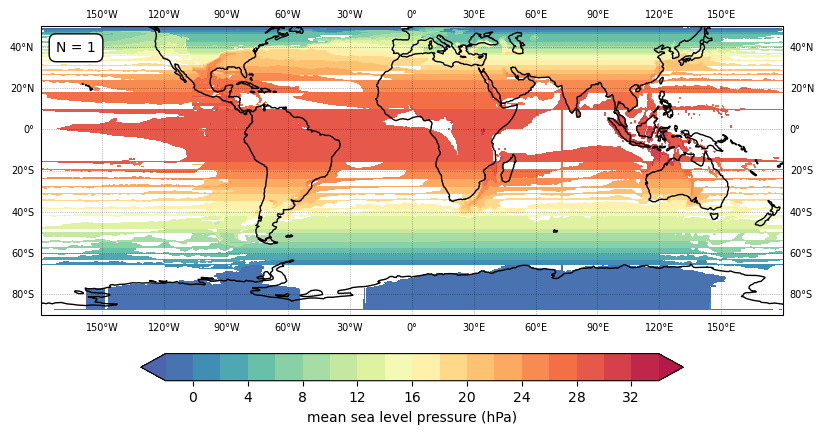

In [22]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Set up the field
field = wyear_tos_data[0, 0, :, :]
title="HadGEM3-GC31-MM sea surface temperature ONDJFM 1960-1960"
calc_anoms=False

tos_lons_flat = tos_lons.flatten()
tos_lats_flat = tos_lats.flatten()
field_flat = field.flatten()

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    # clevs = np.array(np.arange(988, 1024 + 1, 2))
    clevs = np.array(np.arange(-2, 34 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"tos_lons_1d shape: {tos_lons_1d.shape}")
# print(f"tos_lats_1d shape: {tos_lats_1d.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    tos_lons_1d, tos_lats_1d, field, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
# contours = ax.contour(
#     tos_lons_1d,
#     tos_lats_1d,
#     field,
#     clevs,
#     colors="black",
#     transform=ccrs.PlateCarree(),
#     linewidth=0.2,
#     alpha=0.5,
# )
if calc_anoms:
    ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)
else:
    print("Not calculating contours")
    # ax.clabel(contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0)

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# # set up the num events
# num_events = len(cube_psl.coord("number").points)
num_events = 1

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()

In [27]:
from functions import load_model_data_xarray

In [ ]:
# Test importing zg500


Now test the bootstrapping

Fields 40 is the mean of three winters

We want to generate 1000x 3 winter samples

And identify whether the mean lies outside the central 2.5th-97.5th %tile of the distribution.

In [140]:
# Reshape the test data subset
# from 10, 10, 90, 144
# to 100, 90, 144
# by reshaping the first two dimensions

test_data_subset_reshape = np.reshape(test_data_subset, (100, 90, 144))

In [144]:
np.shape(clim_field.data)

(90, 144)

In [149]:
# calculate the test data subset reshape anoms
test_data_subset_reshape_anoms = test_data_subset_reshape - (clim_field.data * 100)

In [150]:
test_data_subset_reshape_anoms

array([[[-2.66242188e+02, -2.72031250e+02, -2.73546875e+02, ...,
          8.30781250e+01,  8.40078125e+01,  8.62890625e+01],
        [-2.66851562e+02, -2.71398438e+02, -2.73078125e+02, ...,
          7.94843750e+01,  7.74531250e+01,  7.86953125e+01],
        [-2.65859375e+02, -2.70070312e+02, -2.71734375e+02, ...,
          7.25234375e+01,  7.00546875e+01,  7.05625000e+01],
        ...,
        [ 1.07656250e+01,  1.05234375e+01,  1.22343750e+01, ...,
          1.07054688e+02,  1.06507812e+02,  1.07320312e+02],
        [ 1.60781250e+01,  1.58515625e+01,  6.82031250e+00, ...,
          1.27429688e+02,  1.29335938e+02,  1.32257812e+02],
        [ 2.11328125e+01,  2.17343750e+01,  1.51718750e+01, ...,
          1.50328125e+02,  1.47429688e+02,  1.50906250e+02]],

       [[-6.25937500e+01, -6.72578125e+01, -7.39843750e+01, ...,
          1.33273438e+02,  1.26679688e+02,  1.20453125e+02],
        [-6.58750000e+01, -6.96250000e+01, -7.46796875e+01, ...,
          1.33710938e+02,  1.22117188e

In [151]:
%%time

import random

# Fields 40 is the mean of 3 winters
n_events = 3
nboot = 1000 # for testing purposes

# Set up the index for members and winter years
index_ens = range(test_data_subset_reshape_anoms.shape[0])

# Set up the composite means
composite_means = np.zeros([nboot, test_data_subset_reshape_anoms.shape[1], test_data_subset_reshape_anoms.shape[2]])

# Loop over the number of bootstraps
for iboot in tqdm(np.arange(nboot)):
    # Create an array containing random indices
    ind_ens_this = np.array([random.choice(index_ens) for i in range(n_events)])

    # Set up the composite mean
    composite_means[iboot, :, :] = np.mean(test_data_subset_reshape_anoms[ind_ens_this, :, :], axis=0)

# print the shape of the composite means
print(composite_means.shape)

# # print the composite means
# print(composite_means)

100%|██████████| 1000/1000 [00:00<00:00, 10941.33it/s]

(1000, 90, 144)
CPU times: user 78.3 ms, sys: 16.9 ms, total: 95.2 ms
Wall time: 94.3 ms


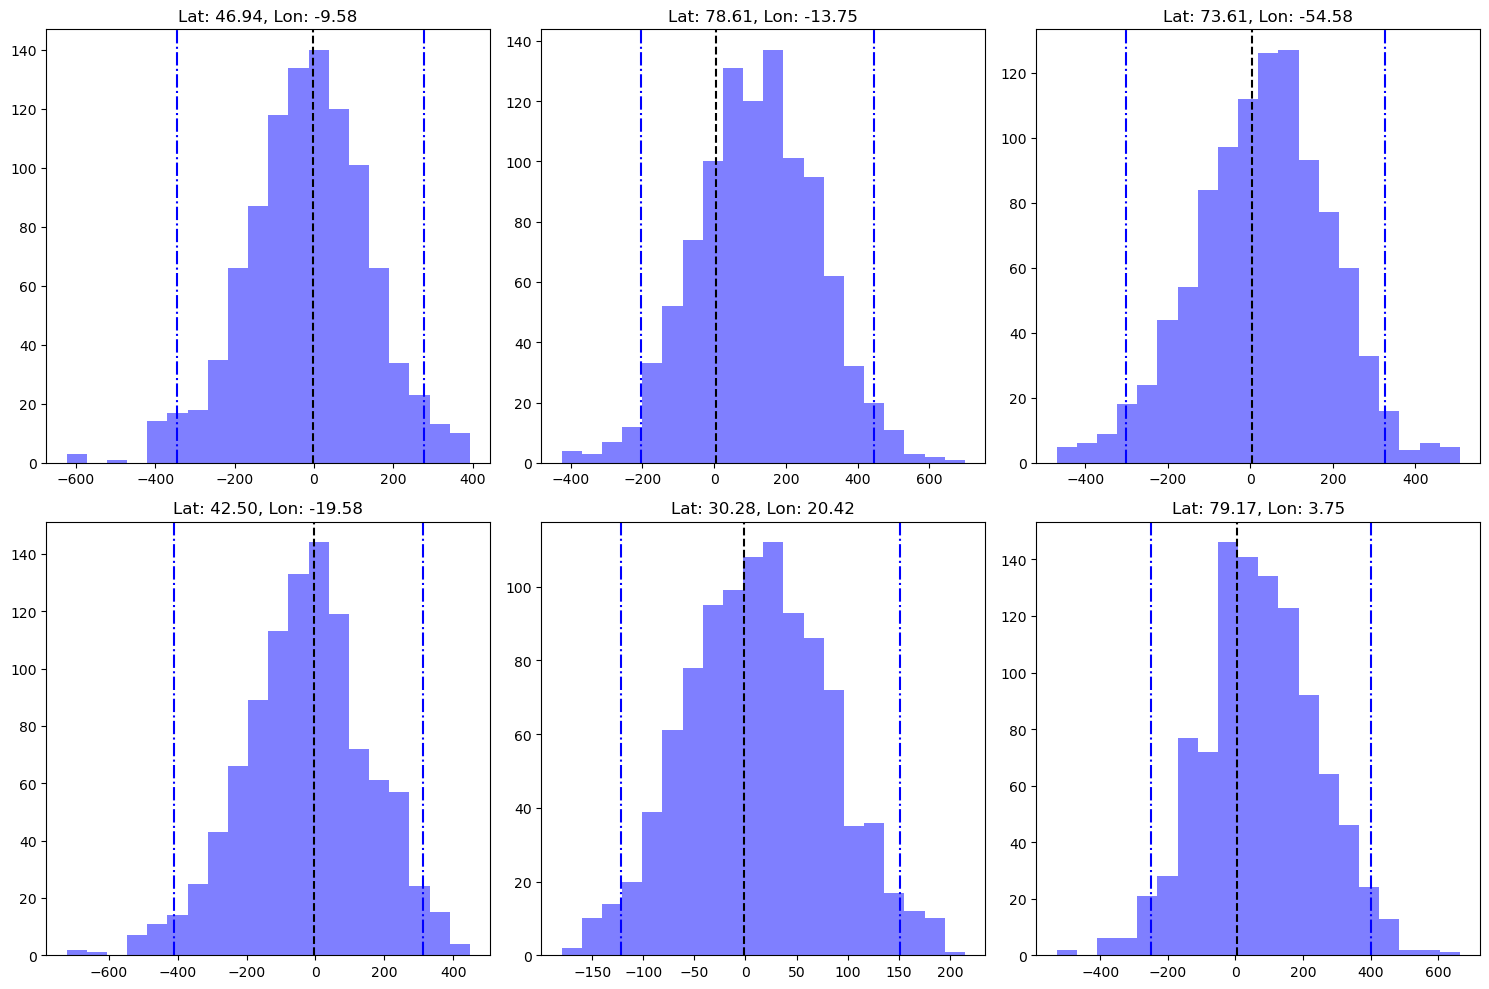

In [160]:
# choose 6 random lats and lons
random_lats = np.random.choice(test_lats_subset, 6)
random_lons = np.random.choice(test_lons_subset, 6)

# Set up a figure with 3 columns and 2 rows
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# flatten the axes
axs = axs.flatten()

# Loop over the random lats and lons
for k, (lat, lon) in enumerate(zip(random_lats, random_lons)):
    # Find the indices of the lat and lon
    lat_indices = np.where(test_lats_subset == lat)[0]
    lon_indices = np.where(test_lons_subset == lon)[0]

    # do the same for the model lats and lons
    model_lat_indices = np.where(lats == lat)[0]
    model_lon_indices = np.where(lons == lon)[0]

    # Check if indices are found
    if len(lat_indices) > 0 and len(lon_indices) > 0:
        lat_idx = lat_indices[0]
        lon_idx = lon_indices[0]

        # Set up the data
        data = composite_means[:, lat_idx, lon_idx]

        # Set up the histogram
        axs[k].hist(data, bins=20, color="blue", alpha=0.5)

        # plot a vertical black line for the model mean
        model_mean = (fields[40][model_lat_indices, model_lon_indices])

        # plot the model mean
        axs[k].axvline(model_mean, color="black", linestyle="--")

        # Set up the title
        axs[k].set_title(f"Lat: {lat:.2f}, Lon: {lon:.2f}")

        # include the 2.5th and 97.5th percentiles of the distribution
        axs[k].axvline(np.percentile(data, 2.5), color="blue", linestyle="-.")
        axs[k].axvline(np.percentile(data, 97.5), color="blue", linestyle="-.")
    else:
        # Handle the case where the lat or lon is not found
        axs[k].set_title(f"Lat: {lat:.2f}, Lon: {lon:.2f}" + "\nData not found")
        axs[k].text(0.5, 0.5, 'Data not found', horizontalalignment='center', verticalalignment='center', transform=axs[k].transAxes)

# Adjust layout
plt.tight_layout()
plt.show()

In [105]:
exceedance_days = [20, 30, 40]
model_df = df_model_exceedance
model_val_name = "no_exceedance_days_demand_net_wind"

In [108]:
# First subset the data to specific thresholds
# Set up a dictionary for the exceedance
exceed_dict = {}

# Loop over the exceedance days
for exceed_day in exceedance_days:
    # print the threshold
    print(f"Threshold: {exceed_day}")

    # Filter the model df to be only the
    # days greater than the threshold
    model_df_exceedance = model_df[model_df[model_val_name] > exceed_day]

    # # print the head of the model df
    # print(model_df_exceedance.head())

    # # print the shape of the model df
    # print(model_df_exceedance.shape)

    # extract a list of len three tuples
    # containing the init year, member and winter year
    exceedance_list = list(
        zip(
            model_df_exceedance["init_year"],
            model_df_exceedance["winter_year"],
            model_df_exceedance["member"],
        )
    )

    # # # print the first 5 elements of the list
    # print(exceedance_list[:5])

    # # print the len of the list
    # print(len(exceedance_list))

    # Append the threshold to the dictionary
    exceed_dict[exceed_day] = exceedance_list

Threshold: 20
Threshold: 30
Threshold: 40


In [113]:
nboot = 1000
obs_variable = "msl"
model = "HadGEM3-GC31-MM"
psl_variable = "psl"
freq = "Amon"
experiment = "dcppA-hindcast"
calc_anoms = False
months = [10, 11, 12, 1, 2, 3]
climatology_period = [1990, 2018]
lat_bounds = [30, 80]
lon_bounds = [-90, 30]
files_loc_path = (
    "/home/users/benhutch/unseen_multi_year/paths/paths_20240117T122513.csv"
)
save_prefix = "composite_obs_model"
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots/unseen"
regrid_file = "/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc"

In [124]:
import glob

# Load the files location
files_loc = pd.read_csv(files_loc_path)

# print the data we seek
print(f"model: {model}")
print(f"experiment: {experiment}")
print(f"freq: {freq}")
print(f"psl_variable: {psl_variable}")

# Extract the path for the given model, experiment, freq, and variable
model_path_psl = files_loc.loc[
    (files_loc["model"] == model)
    & (files_loc["experiment"] == experiment)
    & (files_loc["frequency"] == freq)
    & (files_loc["variable"] == psl_variable)
]["path"].values[0]

# asser that the model path psl exists
assert os.path.exists(model_path_psl), "The model path psl does not exist"

# extract the model path root
model_path_root_psl = model_path_psl.split("/")[1]

# Set up an empty list of files
files_list = []

files_list_exceed = {}

# Loop over the exceedance days
for thresh in exceed_dict:
    # print the threshold
    print(f"Threshold: {thresh}")

    # Set up an empty list for the files for this threshold
    files_list = []

    # Loop over the exceedance list
    for i, (init_year, winter_year, member) in enumerate(exceed_dict[thresh]):
        # print the init year, winter year and member
        print(f"Init year: {init_year}, Winter year: {winter_year}, Member: {member}")

        if model_path_root_psl == "work":
            raise NotImplementedError("work path not implemented yet")
        elif model_path_root_psl == "gws":
            # Create the path
            path = f"{model_path_psl}/{psl_variable}_{freq}_{model}_{experiment}_s{init_year}-r{member}i*_*_{init_year}??-*.nc"

            # glob this path
            files = glob.glob(path)

            # assert that files has length 1
            assert len(files) == 1, f"files has length {len(files)}"

            # extract the file
            file = files[0]

            # assert that this file exists
            assert os.path.exists(file), f"{file} does not exist"

        elif model_path_root_psl == "badc":
            raise NotImplementedError("home path not implemented yet")
        else:
            raise ValueError(f"Unknown model path root {model_path_root_psl}")

        # append the file to the files list
        files_list.append(file)

    # assign the files list to the files_list_exceed dictionary for this threshold
    files_list_exceed[thresh] = files_list

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
freq: Amon
psl_variable: psl
Threshold: 20
Init year: 1960, Winter year: 8, Member: 1
Init year: 1960, Winter year: 10, Member: 1
Init year: 1960, Winter year: 1, Member: 2
Init year: 1960, Winter year: 2, Member: 2
Init year: 1960, Winter year: 8, Member: 2
Init year: 1960, Winter year: 6, Member: 4
Init year: 1960, Winter year: 3, Member: 5
Init year: 1960, Winter year: 3, Member: 7
Init year: 1960, Winter year: 10, Member: 7
Init year: 1960, Winter year: 7, Member: 8
Init year: 1960, Winter year: 1, Member: 9
Init year: 1960, Winter year: 5, Member: 10
Init year: 1961, Winter year: 2, Member: 1
Init year: 1961, Winter year: 10, Member: 1
Init year: 1961, Winter year: 5, Member: 2
Init year: 1961, Winter year: 7, Member: 4
Init year: 1961, Winter year: 8, Member: 4
Init year: 1961, Winter year: 9, Member: 6
Init year: 1961, Winter year: 4, Member: 10
Init year: 1961, Winter year: 6, Member: 10
Init year: 1962, Winter year: 5, Member: 

In [131]:
files_list_exceed[40]

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1981-r4i1_gn_198111-199203.nc',
 '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i1_gn_199211-200303.nc',
 '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s2013-r2i1_gn_201311-202403.nc']

In [134]:
importlib.reload(sys.modules["functions"])
from functions import set_integer_time_axis

In [137]:
df_model_exceedance["winter_year"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [210]:
def preprocess_leads(
    ds,
    winter_year,
    freq,
    idx,
):
    """
    Preprocess the leads of the model data
    """

    # format the lead as an int
    ds = set_integer_time_axis(
        xro=ds,
        frequency=freq,
    )

    # # print the leads in ds
    # print(ds.time)

    # Use the winter year to find the leads to extract
    # for ONDJFM
    leads_extract = np.arange(winter_year * 12, winter_year * 12 + 6, 1)

    # # print the leads extract
    # print(leads_extract)

    # # print the indexes of time
    # print(ds.time)

    # Extract the leads
    ds = ds.sel(time=leads_extract).mean("time")

    # Add a new coordinate 'number' with a unique value
    ds = ds.expand_dims({"number": [idx]})

    return ds

In [223]:
# Form the concatenated dataset for the exceedance days
# loop over the thresholds
for thresh in [20]:
    # extract the files list
    files_list = files_list_exceed[thresh]

    # extract the exceedance list
    exceed_list = exceed_dict[thresh]

    # print both
    print(files_list)
    print(exceed_list)

    ds_list = []

    # Loop over the files
    for idx, (file, (init_year, winter_year, member)) in tqdm(
        enumerate(zip(files_list, exceed_list))
    ):
        # print the file, init year, winter year and member
        # print(f"File: {file}, Init year: {init_year}, Winter year: {winter_year}, Member: {member}")

        # Load the data
        ds = xr.open_mfdataset(
            file,
            preprocess=lambda ds: preprocess_leads(
                ds=ds,
                winter_year=winter_year,
                freq=freq,
                idx=idx,
            ),
        )

        # append the ds_extract to the list
        ds_list.append(ds[psl_variable])

    # Concatenate the list of datasets
    combined_ds = xr.concat(ds_list, dim="number")

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-

44it [05:29,  7.49s/it]


KeyboardInterrupt: 

In [212]:
# convert to a cube
cube_psl = combined_ds.to_iris()

# subset to teh correct grid
cube_psl = cube_psl.intersection(longitude=(-180, 180), latitude=(-90, 90))

# subset to the region of interest
cube_psl = cube_psl.intersection(
    longitude=(lon_bounds[0], lon_bounds[1]),
    latitude=(lat_bounds[0], lat_bounds[1]),
)

In [213]:
calc_anoms = True

In [214]:
# if calc anoms is true
if calc_anoms:

    # set up a save directory for the climatologies
    save_dir_clim = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_clim"

    # assert that this directory exists
    assert os.path.exists(save_dir_clim), "The save directory does not exist"

    # set up the fname
    fname = f"climatology_{model}_{experiment}_{freq}_{psl_variable}_{climatology_period[0]}-{climatology_period[1]}_{lat_bounds[0]}-{lat_bounds[1]}_{lon_bounds[0]}-{lon_bounds[1]}_{months[0]}-{months[-1]}.nc"

    # set up the full climatology path
    climatology_path = os.path.join(save_dir_clim, fname)

    # if the climatology path exists
    if os.path.exists(climatology_path):
        print("The climatology file exists")
        print("Loading the climatology file")

        # load the file using iris
        cube_clim = iris.load_cube(climatology_path)

    else:
        print("The climatology file does not exist")
        print("Calculating the climatology")

        # Set up a list for the full ds's
        clim_dss = []
        # Loop over the years
        for year in tqdm(range(climatology_period[0], climatology_period[1] + 1)):
            member_list = []
            for member in unique_members:
                start_time = time.time()

                path = f"{model_path_psl}/{psl_variable}_{freq}_{model}_{experiment}_s{year}-r{member}i*_*_{year}??-*.nc"

                # glob this path
                glob_start = time.time()
                files = glob.glob(path)
                glob_end = time.time()

                # assert
                assert (
                    len(files) == 1
                ), f"files has length {len(files)} for year {year} and member {member} and path {path}"

                # open all of the files
                # open_start = time.time()
                member_ds = xr.open_mfdataset(
                    files[0],
                    combine="nested",
                    concat_dim="time",
                    preprocess=lambda ds: preprocess(
                        ds=ds,
                        year=year,
                        variable=psl_variable,
                        months=months,
                    ),
                    parallel=True,
                    engine="netcdf4",
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                ).squeeze()
                # open_end = time.time()

                # id init year == climatology_period[0]
                # and member == unique_members[0]
                # set_time_start = time.time()
                if year == climatology_period[0] and member == unique_members[0]:
                    # set the new integer time
                    member_ds = set_integer_time_axis(
                        xro=member_ds,
                        frequency=freq,
                        first_month_attr=True,
                    )
                else:
                    # set the new integer time
                    member_ds = set_integer_time_axis(
                        xro=member_ds,
                        frequency=freq,
                    )
                # set_time_end = time.time()

                # take the mean over the time axis
                # mean_start = time.time()
                member_ds = member_ds.mean(dim="time")
                # mean_end = time.time()

                # append the member_ds to the member_list
                member_list.append(member_ds)

                # end_time = time.time()

                # # Print timing information
                # print(f"Year: {year}, Member: {member}")
                # print(f"  Total time: {end_time - start_time:.2f} seconds")
                # print(f"  glob time: {glob_end - glob_start:.2f} seconds")
                # print(f"  open_mfdataset time: {open_end - open_start:.2f} seconds")
                # print(f"  set_integer_time_axis time: {set_time_end - set_time_start:.2f} seconds")
                # print(f"  mean time: {mean_end - mean_start:.2f} seconds")

            # Concatenate with a new member dimension using xarray
            member_ds = xr.concat(member_list, dim="member")
            # append the member_ds to the init_year_list
            clim_dss.append(member_ds)
        # Concatenate the init_year list along the init dimension
        # and rename as lead time
        ds = xr.concat(clim_dss, "init")

        # print ds
        print(ds)

        # set up the members
        ds["member"] = unique_members
        ds["init"] = np.arange(climatology_period[0], climatology_period[1] + 1)

        # extract the variable
        ds_var = ds[psl_variable]

        # # take the mean over lead dimension
        # ds_clim = ds_var.mean(dim="lead")

        # take the mean over member dimension
        ds_clim = ds_var.mean(dim="member")

        # take the mean over init dimension
        ds_clim = ds_clim.mean(dim="init")

        # convert to a cube
        cube_clim = ds_clim.to_iris()

        # # regrid the model data to the obs grid
        # cube_clim_regrid = cube_clim.regrid(cube_obs, iris.analysis.Linear())

        # subset to the correct grid
        cube_clim = cube_clim.intersection(longitude=(-180, 180), latitude=(-90, 90))

        # subset to the region of interest
        cube_clim = cube_clim.intersection(
            latitude=(lat_bounds[0], lat_bounds[1]),
            longitude=(lon_bounds[0], lon_bounds[1]),
        )

        # if the climatology file does not exist
        print("Saving the climatology file")

        # save the cube_clim
        iris.save(cube_clim, climatology_path)

The climatology file exists
Loading the climatology file


In [215]:
cube_clim

<iris 'Cube' of psl / (unknown) (latitude: 90; longitude: 144)>

In [216]:
cube_psl

<iris 'Cube' of psl / (unknown) (number: 73; latitude: 90; longitude: 144)>

In [217]:
# take the mean of cube_psl over number and time
cube_psl_mean = cube_psl.collapsed(["number"], iris.analysis.MEAN)

In [218]:
# calculate the anomalies
field = (cube_psl_mean.data - cube_clim.data) / 100

In [219]:
lons = cube_psl.coord("longitude").points
lats = cube_psl.coord("latitude").points

In [220]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

NameError: name 'title' is not defined

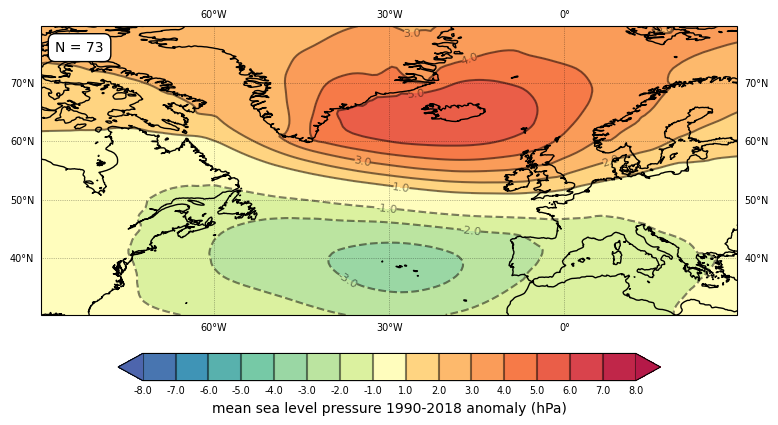

In [222]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    clevs = np.array(np.arange(988, 1024 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"lons shape: {lons.shape}")
# print(f"lats shape: {lats.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    lons, lats, field, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
contours = ax.contour(
    lons,
    lats,
    field,
    clevs,
    colors="black",
    transform=ccrs.PlateCarree(),
    linewidth=0.2,
    alpha=0.5,
)
if calc_anoms:
    ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)
else:
    ax.clabel(contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0)

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# set up the num events
num_events = len(cube_psl.coord("number").points)

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()